# First attempt to predict uplift with a neural network
The model will have two inputs: one for time-dependent data (client purchases) and one for time-independent data (client data).

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

2022-12-23 19:27:02.450081: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-23 19:27:02.450114: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-23 19:27:04.036525: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-23 19:27:04.036676: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-23 19:27:04.036687: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT War

In [2]:
import chime

In [3]:
%load_ext chime

In [4]:
clients_train = np.load('clients_train.npy')
clients_train.shape

(140027, 6)

In [5]:
train = pd.read_csv('train_modified.csv')\
    .drop(columns='client_id')
train

,Z
0,0
1,1
2,1
3,1
4,0
...,...
140022,1
140023,1
140024,0
140025,1


In [6]:
train_purch = np.load('train_purch_np.npy')
train_purch.shape

(140027, 118, 9)

# Train-validation split

In [7]:
train_indices, val_indices = train_test_split(train.index.to_list(),
                                              test_size=0.2,
                                              random_state=8,
                                              shuffle=True,
                                              stratify=train.Z)

In [8]:
X_indep_train = clients_train[train_indices, :]
X_indep_train.shape

(112021, 6)

In [9]:
X_indep_val = clients_train[val_indices, :]
X_indep_val.shape

(28006, 6)

In [10]:
X_dep_train = train_purch[train_indices, :, :]
X_dep_train.shape

(112021, 118, 9)

In [11]:
X_dep_val = train_purch[val_indices, :, :]
X_dep_val.shape

(28006, 118, 9)

In [12]:
y_train = train.values[train_indices]
y_train.shape

(112021, 1)

In [13]:
y_val = train.values[val_indices]
y_val.shape

(28006, 1)

# Basic model

In [14]:
time_dependent_input = keras.Input(
    shape=(118, 9),
    name='time_dependent'
)
time_independent_input = keras.Input(
    shape=(6),
    name='time_independent'
)
dep = layers.Dense(128, activation='relu')(time_dependent_input)
dep = layers.LSTM(16)(dep)

indep = layers.Dense(6, activation='relu')(time_independent_input)

x = layers.concatenate([dep, indep])

x = layers.Dense(8,  activation='relu')(x)
pred = layers.Dense(1)(x)

model = keras.Model(
    inputs = [time_dependent_input, time_independent_input],
    outputs = [pred]
)

2022-12-23 19:27:09.084412: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2022-12-23 19:27:09.084457: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: denis-Z68XP-UD3
2022-12-23 19:27:09.084466: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: denis-Z68XP-UD3
2022-12-23 19:27:09.084573: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 390.157.0
2022-12-23 19:27:09.084598: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 390.157.0
2022-12-23 19:27:09.084606: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 390.157.0


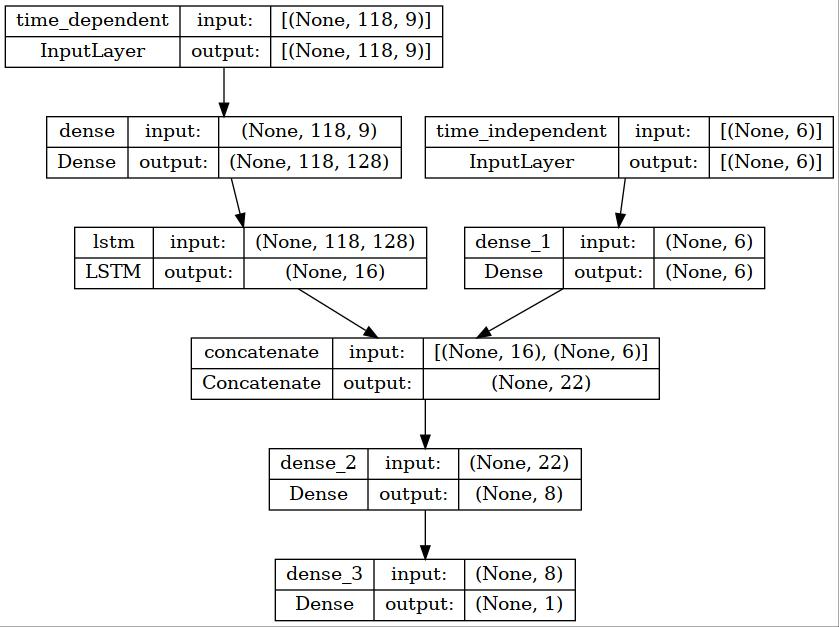

In [15]:
keras.utils.plot_model(model, 'model_1.jpg', show_shapes=True)

In [16]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer="adam",
    metrics=[tf.keras.metrics.AUC()]
)

In [ ]:
%%time
%%chime
history=model.fit(
    {'time_dependent': X_dep_train,
    'time_independent': X_indep_train},
    y_train,
    batch_size=8,
    epochs=30,
    verbose=1,
    validation_split=0.1
)

Epoch 1/30


2022-12-23 19:27:17.670801: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 428274864 exceeds 10% of free system memory.


12603/12603 [==============================] - 345s 27ms/step - loss: 0.6926 - auc: 0.5052 - val_loss: 0.6935 - val_auc: 0.5073
Epoch 2/30
 3237/12603 [======>.......................] - ETA: 4:14 - loss: 0.6927 - auc: 0.5021

<AxesSubplot:>

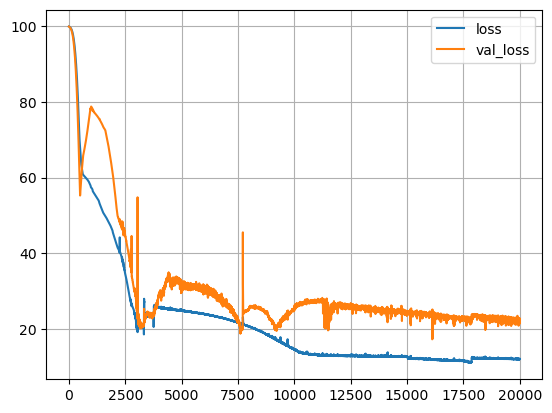

In [14]:
pd.DataFrame({'loss': history.history['loss'], 'val_loss': history.history['val_loss']})\
    .plot.line(grid=True)

In [15]:
min(history.history['val_loss'])

17.31126594543457

In [16]:
model.evaluate({'time_dependent': X_test,
    'time_independent': well_data_test},
    y_test)

1/1 [==============================] - 0s 16ms/step - loss: 62.9911 - mape: 62.9911


[62.99110794067383, 62.99110794067383]

# Более сложная сеть

In [17]:
time_dependent_input = keras.Input(
    shape=(n_days, 9),
    name='time_dependent'
)
time_independent_input = keras.Input(
    shape=(23),
    name='time_independent'
)
dep = layers.Bidirectional(tf.keras.layers.LSTM(8,  return_sequences=True))(time_dependent_input)
dep = layers.Bidirectional(tf.keras.layers.LSTM(4,  return_sequences=False))(dep)
dep = layers.Dense(4, activation='relu')(dep)

indep = layers.Dense(12, activation='relu')(time_independent_input)

x = layers.concatenate([dep, indep])

x = layers.Dense(32,  activation='relu')(x)
pred = layers.Dense(1)(x)

model_30 = keras.Model(
    inputs = [time_dependent_input, time_independent_input],
    outputs = [pred]
)

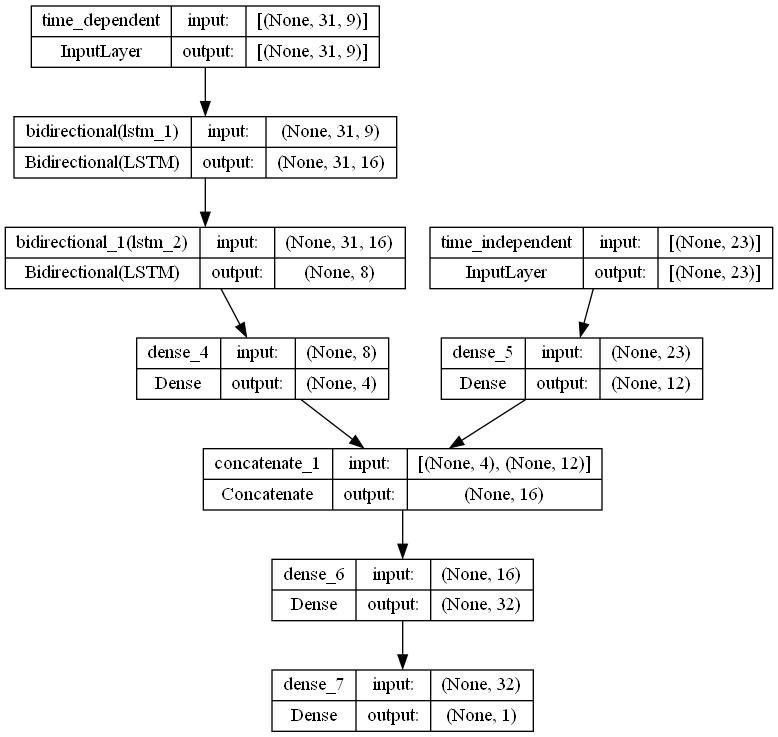

In [18]:
keras.utils.plot_model(model_30, 'model_30.jpg', show_shapes=True)

In [19]:
model_30.compile(
    loss="mape",
    optimizer="adam",
    metrics=['mape']
)

In [20]:
%%time
%%chime
history_30=model_30.fit(
    {'time_dependent': X_train,
    'time_independent': well_data_train},
    y_train,
    epochs=5000,
    verbose=1,
    validation_split=0.1
)

Epoch 1/5000
1/1 [==============================] - 10s 10s/step - loss: 100.0045 - mape: 100.0045 - val_loss: 100.0054 - val_mape: 100.0054
Epoch 2/5000
1/1 [==============================] - 0s 54ms/step - loss: 100.0039 - mape: 100.0039 - val_loss: 100.0047 - val_mape: 100.0047
Epoch 3/5000
1/1 [==============================] - 0s 46ms/step - loss: 100.0034 - mape: 100.0034 - val_loss: 100.0040 - val_mape: 100.0040
Epoch 4/5000
1/1 [==============================] - 0s 45ms/step - loss: 100.0029 - mape: 100.0029 - val_loss: 100.0033 - val_mape: 100.0033
Epoch 5/5000
1/1 [==============================] - 0s 42ms/step - loss: 100.0024 - mape: 100.0024 - val_loss: 100.0026 - val_mape: 100.0026
Epoch 6/5000
1/1 [==============================] - 0s 44ms/step - loss: 100.0019 - mape: 100.0019 - val_loss: 100.0020 - val_mape: 100.0020
Epoch 7/5000
1/1 [==============================] - 0s 43ms/step - loss: 100.0014 - mape: 100.0014 - val_loss: 100.0013 - val_mape: 100.0013
Epoch 8/5000


1/1 [==============================] - 0s 39ms/step - loss: 99.8697 - mape: 99.8697 - val_loss: 99.8222 - val_mape: 99.8222
Epoch 120/5000
1/1 [==============================] - 0s 39ms/step - loss: 99.8666 - mape: 99.8666 - val_loss: 99.8179 - val_mape: 99.8179
Epoch 121/5000
1/1 [==============================] - 0s 40ms/step - loss: 99.8634 - mape: 99.8634 - val_loss: 99.8136 - val_mape: 99.8136
Epoch 122/5000
1/1 [==============================] - 0s 39ms/step - loss: 99.8601 - mape: 99.8601 - val_loss: 99.8092 - val_mape: 99.8092
Epoch 123/5000
1/1 [==============================] - 0s 39ms/step - loss: 99.8567 - mape: 99.8567 - val_loss: 99.8046 - val_mape: 99.8046
Epoch 124/5000
1/1 [==============================] - 0s 39ms/step - loss: 99.8533 - mape: 99.8533 - val_loss: 99.8000 - val_mape: 99.8000
Epoch 125/5000
1/1 [==============================] - 0s 42ms/step - loss: 99.8498 - mape: 99.8498 - val_loss: 99.7953 - val_mape: 99.7953
Epoch 126/5000
1/1 [======================

1/1 [==============================] - 0s 40ms/step - loss: 99.5404 - mape: 99.5404 - val_loss: 99.3806 - val_mape: 99.3806
Epoch 179/5000
1/1 [==============================] - 0s 39ms/step - loss: 99.5317 - mape: 99.5317 - val_loss: 99.3691 - val_mape: 99.3691
Epoch 180/5000
1/1 [==============================] - 0s 40ms/step - loss: 99.5230 - mape: 99.5230 - val_loss: 99.3575 - val_mape: 99.3575
Epoch 181/5000
1/1 [==============================] - 0s 39ms/step - loss: 99.5141 - mape: 99.5141 - val_loss: 99.3456 - val_mape: 99.3456
Epoch 182/5000
1/1 [==============================] - 0s 38ms/step - loss: 99.5052 - mape: 99.5052 - val_loss: 99.3337 - val_mape: 99.3337
Epoch 183/5000
1/1 [==============================] - 0s 38ms/step - loss: 99.4961 - mape: 99.4961 - val_loss: 99.3216 - val_mape: 99.3216
Epoch 184/5000
1/1 [==============================] - 0s 38ms/step - loss: 99.4869 - mape: 99.4869 - val_loss: 99.3093 - val_mape: 99.3093
Epoch 185/5000
1/1 [======================

1/1 [==============================] - 0s 41ms/step - loss: 98.8050 - mape: 98.8050 - val_loss: 98.4027 - val_mape: 98.4027
Epoch 238/5000
1/1 [==============================] - 0s 43ms/step - loss: 98.7881 - mape: 98.7881 - val_loss: 98.3803 - val_mape: 98.3803
Epoch 239/5000
1/1 [==============================] - 0s 40ms/step - loss: 98.7710 - mape: 98.7710 - val_loss: 98.3577 - val_mape: 98.3577
Epoch 240/5000
1/1 [==============================] - 0s 40ms/step - loss: 98.7538 - mape: 98.7538 - val_loss: 98.3348 - val_mape: 98.3348
Epoch 241/5000
1/1 [==============================] - 0s 41ms/step - loss: 98.7364 - mape: 98.7364 - val_loss: 98.3118 - val_mape: 98.3118
Epoch 242/5000
1/1 [==============================] - 0s 44ms/step - loss: 98.7189 - mape: 98.7189 - val_loss: 98.2885 - val_mape: 98.2885
Epoch 243/5000
1/1 [==============================] - 0s 42ms/step - loss: 98.7011 - mape: 98.7011 - val_loss: 98.2650 - val_mape: 98.2650
Epoch 244/5000
1/1 [======================

1/1 [==============================] - 0s 39ms/step - loss: 97.5048 - mape: 97.5048 - val_loss: 96.6812 - val_mape: 96.6812
Epoch 297/5000
1/1 [==============================] - 0s 39ms/step - loss: 97.4770 - mape: 97.4770 - val_loss: 96.6445 - val_mape: 96.6445
Epoch 298/5000
1/1 [==============================] - 0s 39ms/step - loss: 97.4490 - mape: 97.4490 - val_loss: 96.6075 - val_mape: 96.6075
Epoch 299/5000
1/1 [==============================] - 0s 39ms/step - loss: 97.4208 - mape: 97.4208 - val_loss: 96.5703 - val_mape: 96.5703
Epoch 300/5000
1/1 [==============================] - 0s 39ms/step - loss: 97.3924 - mape: 97.3924 - val_loss: 96.5327 - val_mape: 96.5327
Epoch 301/5000
1/1 [==============================] - 0s 40ms/step - loss: 97.3638 - mape: 97.3638 - val_loss: 96.4949 - val_mape: 96.4949
Epoch 302/5000
1/1 [==============================] - 0s 38ms/step - loss: 97.3350 - mape: 97.3350 - val_loss: 96.4568 - val_mape: 96.4568
Epoch 303/5000
1/1 [======================

1/1 [==============================] - 0s 40ms/step - loss: 95.4928 - mape: 95.4928 - val_loss: 94.0243 - val_mape: 94.0243
Epoch 356/5000
1/1 [==============================] - 0s 39ms/step - loss: 95.4517 - mape: 95.4517 - val_loss: 93.9702 - val_mape: 93.9702
Epoch 357/5000
1/1 [==============================] - 0s 39ms/step - loss: 95.4105 - mape: 95.4105 - val_loss: 93.9157 - val_mape: 93.9157
Epoch 358/5000
1/1 [==============================] - 0s 39ms/step - loss: 95.3689 - mape: 95.3689 - val_loss: 93.8609 - val_mape: 93.8609
Epoch 359/5000
1/1 [==============================] - 0s 40ms/step - loss: 95.3272 - mape: 95.3272 - val_loss: 93.8058 - val_mape: 93.8058
Epoch 360/5000
1/1 [==============================] - 0s 39ms/step - loss: 95.2851 - mape: 95.2851 - val_loss: 93.7504 - val_mape: 93.7504
Epoch 361/5000
1/1 [==============================] - 0s 40ms/step - loss: 95.2429 - mape: 95.2429 - val_loss: 93.6946 - val_mape: 93.6946
Epoch 362/5000
1/1 [======================

1/1 [==============================] - 0s 40ms/step - loss: 92.6328 - mape: 92.6328 - val_loss: 90.2543 - val_mape: 90.2543
Epoch 415/5000
1/1 [==============================] - 0s 42ms/step - loss: 92.5763 - mape: 92.5763 - val_loss: 90.1799 - val_mape: 90.1799
Epoch 416/5000
1/1 [==============================] - 0s 43ms/step - loss: 92.5195 - mape: 92.5195 - val_loss: 90.1050 - val_mape: 90.1050
Epoch 417/5000
1/1 [==============================] - 0s 44ms/step - loss: 92.4624 - mape: 92.4624 - val_loss: 90.0298 - val_mape: 90.0298
Epoch 418/5000
1/1 [==============================] - 0s 43ms/step - loss: 92.4051 - mape: 92.4051 - val_loss: 89.9543 - val_mape: 89.9543
Epoch 419/5000
1/1 [==============================] - 0s 42ms/step - loss: 92.3474 - mape: 92.3474 - val_loss: 89.8783 - val_mape: 89.8783
Epoch 420/5000
1/1 [==============================] - 0s 42ms/step - loss: 92.2895 - mape: 92.2895 - val_loss: 89.8020 - val_mape: 89.8020
Epoch 421/5000
1/1 [======================

1/1 [==============================] - 0s 44ms/step - loss: 88.7984 - mape: 88.7984 - val_loss: 85.2061 - val_mape: 85.2061
Epoch 474/5000
1/1 [==============================] - 0s 42ms/step - loss: 88.7243 - mape: 88.7243 - val_loss: 85.1086 - val_mape: 85.1086
Epoch 475/5000
1/1 [==============================] - 0s 42ms/step - loss: 88.6500 - mape: 88.6500 - val_loss: 85.0107 - val_mape: 85.0107
Epoch 476/5000
1/1 [==============================] - 0s 41ms/step - loss: 88.5752 - mape: 88.5752 - val_loss: 84.9124 - val_mape: 84.9124
Epoch 477/5000
1/1 [==============================] - 0s 39ms/step - loss: 88.5002 - mape: 88.5002 - val_loss: 84.8137 - val_mape: 84.8137
Epoch 478/5000
1/1 [==============================] - 0s 40ms/step - loss: 88.4249 - mape: 88.4249 - val_loss: 84.7145 - val_mape: 84.7145
Epoch 479/5000
1/1 [==============================] - 0s 40ms/step - loss: 88.3492 - mape: 88.3492 - val_loss: 84.6150 - val_mape: 84.6150
Epoch 480/5000
1/1 [======================

1/1 [==============================] - 0s 39ms/step - loss: 83.8717 - mape: 83.8717 - val_loss: 78.7257 - val_mape: 78.7257
Epoch 533/5000
1/1 [==============================] - 0s 40ms/step - loss: 83.7781 - mape: 83.7781 - val_loss: 78.6027 - val_mape: 78.6027
Epoch 534/5000
1/1 [==============================] - 0s 45ms/step - loss: 83.6842 - mape: 83.6842 - val_loss: 78.4792 - val_mape: 78.4792
Epoch 535/5000
1/1 [==============================] - 0s 46ms/step - loss: 83.5900 - mape: 83.5900 - val_loss: 78.3553 - val_mape: 78.3553
Epoch 536/5000
1/1 [==============================] - 0s 48ms/step - loss: 83.4954 - mape: 83.4954 - val_loss: 78.2309 - val_mape: 78.2309
Epoch 537/5000
1/1 [==============================] - 0s 46ms/step - loss: 83.4004 - mape: 83.4004 - val_loss: 78.1060 - val_mape: 78.1060
Epoch 538/5000
1/1 [==============================] - 0s 43ms/step - loss: 83.3051 - mape: 83.3051 - val_loss: 77.9807 - val_mape: 77.9807
Epoch 539/5000
1/1 [======================

1/1 [==============================] - 0s 41ms/step - loss: 77.7427 - mape: 77.7427 - val_loss: 70.6697 - val_mape: 70.6697
Epoch 592/5000
1/1 [==============================] - 0s 40ms/step - loss: 77.6279 - mape: 77.6279 - val_loss: 70.5188 - val_mape: 70.5188
Epoch 593/5000
1/1 [==============================] - 0s 39ms/step - loss: 77.5127 - mape: 77.5127 - val_loss: 70.3674 - val_mape: 70.3674
Epoch 594/5000
1/1 [==============================] - 0s 39ms/step - loss: 77.3971 - mape: 77.3971 - val_loss: 70.2155 - val_mape: 70.2155
Epoch 595/5000
1/1 [==============================] - 0s 39ms/step - loss: 77.2811 - mape: 77.2811 - val_loss: 70.0631 - val_mape: 70.0631
Epoch 596/5000
1/1 [==============================] - 0s 41ms/step - loss: 77.1647 - mape: 77.1647 - val_loss: 69.9102 - val_mape: 69.9102
Epoch 597/5000
1/1 [==============================] - 0s 39ms/step - loss: 77.0480 - mape: 77.0480 - val_loss: 69.7569 - val_mape: 69.7569
Epoch 598/5000
1/1 [======================

1/1 [==============================] - 0s 42ms/step - loss: 70.5777 - mape: 70.5777 - val_loss: 60.9909 - val_mape: 60.9909
Epoch 651/5000
1/1 [==============================] - 0s 42ms/step - loss: 70.5054 - mape: 70.5054 - val_loss: 60.8410 - val_mape: 60.8410
Epoch 652/5000
1/1 [==============================] - 0s 42ms/step - loss: 70.4347 - mape: 70.4347 - val_loss: 60.6941 - val_mape: 60.6941
Epoch 653/5000
1/1 [==============================] - 0s 41ms/step - loss: 70.3654 - mape: 70.3654 - val_loss: 60.5499 - val_mape: 60.5499
Epoch 654/5000
1/1 [==============================] - 0s 40ms/step - loss: 70.2974 - mape: 70.2974 - val_loss: 60.4081 - val_mape: 60.4081
Epoch 655/5000
1/1 [==============================] - 0s 40ms/step - loss: 70.2305 - mape: 70.2305 - val_loss: 60.2685 - val_mape: 60.2685
Epoch 656/5000
1/1 [==============================] - 0s 41ms/step - loss: 70.1646 - mape: 70.1646 - val_loss: 60.1307 - val_mape: 60.1307
Epoch 657/5000
1/1 [======================

1/1 [==============================] - 0s 42ms/step - loss: 66.8735 - mape: 66.8735 - val_loss: 56.2136 - val_mape: 56.2136
Epoch 710/5000
1/1 [==============================] - 0s 42ms/step - loss: 66.8079 - mape: 66.8079 - val_loss: 56.2816 - val_mape: 56.2816
Epoch 711/5000
1/1 [==============================] - 0s 40ms/step - loss: 66.7421 - mape: 66.7421 - val_loss: 56.3498 - val_mape: 56.3498
Epoch 712/5000
1/1 [==============================] - 0s 39ms/step - loss: 66.6761 - mape: 66.6761 - val_loss: 56.4183 - val_mape: 56.4183
Epoch 713/5000
1/1 [==============================] - 0s 38ms/step - loss: 66.6099 - mape: 66.6099 - val_loss: 56.4869 - val_mape: 56.4869
Epoch 714/5000
1/1 [==============================] - 0s 39ms/step - loss: 66.5436 - mape: 66.5436 - val_loss: 56.5557 - val_mape: 56.5557
Epoch 715/5000
1/1 [==============================] - 0s 40ms/step - loss: 66.4770 - mape: 66.4770 - val_loss: 56.6248 - val_mape: 56.6248
Epoch 716/5000
1/1 [======================

1/1 [==============================] - 0s 38ms/step - loss: 63.4057 - mape: 63.4057 - val_loss: 60.2338 - val_mape: 60.2338
Epoch 769/5000
1/1 [==============================] - 0s 40ms/step - loss: 63.3785 - mape: 63.3785 - val_loss: 60.2838 - val_mape: 60.2838
Epoch 770/5000
1/1 [==============================] - 0s 39ms/step - loss: 63.3514 - mape: 63.3514 - val_loss: 60.3336 - val_mape: 60.3336
Epoch 771/5000
1/1 [==============================] - 0s 40ms/step - loss: 63.3245 - mape: 63.3245 - val_loss: 60.3830 - val_mape: 60.3830
Epoch 772/5000
1/1 [==============================] - 0s 39ms/step - loss: 63.2978 - mape: 63.2978 - val_loss: 60.4322 - val_mape: 60.4322
Epoch 773/5000
1/1 [==============================] - 0s 41ms/step - loss: 63.2712 - mape: 63.2712 - val_loss: 60.4811 - val_mape: 60.4811
Epoch 774/5000
1/1 [==============================] - 0s 39ms/step - loss: 63.2447 - mape: 63.2447 - val_loss: 60.5299 - val_mape: 60.5299
Epoch 775/5000
1/1 [======================

1/1 [==============================] - 0s 47ms/step - loss: 61.8166 - mape: 61.8166 - val_loss: 63.1735 - val_mape: 63.1735
Epoch 828/5000
1/1 [==============================] - 0s 44ms/step - loss: 61.7881 - mape: 61.7881 - val_loss: 63.2265 - val_mape: 63.2265
Epoch 829/5000
1/1 [==============================] - 0s 44ms/step - loss: 61.7594 - mape: 61.7594 - val_loss: 63.2795 - val_mape: 63.2795
Epoch 830/5000
1/1 [==============================] - 0s 45ms/step - loss: 61.7307 - mape: 61.7307 - val_loss: 63.3327 - val_mape: 63.3327
Epoch 831/5000
1/1 [==============================] - 0s 42ms/step - loss: 61.7020 - mape: 61.7020 - val_loss: 63.3860 - val_mape: 63.3860
Epoch 832/5000
1/1 [==============================] - 0s 39ms/step - loss: 61.6731 - mape: 61.6731 - val_loss: 63.4395 - val_mape: 63.4395
Epoch 833/5000
1/1 [==============================] - 0s 39ms/step - loss: 61.6442 - mape: 61.6442 - val_loss: 63.4931 - val_mape: 63.4931
Epoch 834/5000
1/1 [======================

1/1 [==============================] - 0s 40ms/step - loss: 60.7484 - mape: 60.7484 - val_loss: 65.7233 - val_mape: 65.7233
Epoch 887/5000
1/1 [==============================] - 0s 39ms/step - loss: 60.7440 - mape: 60.7440 - val_loss: 65.7453 - val_mape: 65.7453
Epoch 888/5000
1/1 [==============================] - 0s 39ms/step - loss: 60.7397 - mape: 60.7397 - val_loss: 65.7672 - val_mape: 65.7672
Epoch 889/5000
1/1 [==============================] - 0s 39ms/step - loss: 60.7354 - mape: 60.7354 - val_loss: 65.7890 - val_mape: 65.7890
Epoch 890/5000
1/1 [==============================] - 0s 40ms/step - loss: 60.7310 - mape: 60.7310 - val_loss: 65.8106 - val_mape: 65.8106
Epoch 891/5000
1/1 [==============================] - 0s 39ms/step - loss: 60.7268 - mape: 60.7268 - val_loss: 65.8322 - val_mape: 65.8322
Epoch 892/5000
1/1 [==============================] - 0s 40ms/step - loss: 60.7225 - mape: 60.7225 - val_loss: 65.8537 - val_mape: 65.8537
Epoch 893/5000
1/1 [======================

1/1 [==============================] - 0s 40ms/step - loss: 60.4953 - mape: 60.4953 - val_loss: 67.0010 - val_mape: 67.0010
Epoch 946/5000
1/1 [==============================] - 0s 40ms/step - loss: 60.4909 - mape: 60.4909 - val_loss: 67.0235 - val_mape: 67.0235
Epoch 947/5000
1/1 [==============================] - 0s 39ms/step - loss: 60.4865 - mape: 60.4865 - val_loss: 67.0460 - val_mape: 67.0460
Epoch 948/5000
1/1 [==============================] - 0s 40ms/step - loss: 60.4820 - mape: 60.4820 - val_loss: 67.0685 - val_mape: 67.0685
Epoch 949/5000
1/1 [==============================] - 0s 39ms/step - loss: 60.4776 - mape: 60.4776 - val_loss: 67.0911 - val_mape: 67.0911
Epoch 950/5000
1/1 [==============================] - 0s 38ms/step - loss: 60.4731 - mape: 60.4731 - val_loss: 67.1137 - val_mape: 67.1137
Epoch 951/5000
1/1 [==============================] - 0s 39ms/step - loss: 60.4687 - mape: 60.4687 - val_loss: 67.1363 - val_mape: 67.1363
Epoch 952/5000
1/1 [======================

1/1 [==============================] - 0s 41ms/step - loss: 60.2221 - mape: 60.2221 - val_loss: 68.3920 - val_mape: 68.3920
Epoch 1005/5000
1/1 [==============================] - 0s 40ms/step - loss: 60.2172 - mape: 60.2172 - val_loss: 68.4167 - val_mape: 68.4167
Epoch 1006/5000
1/1 [==============================] - 0s 40ms/step - loss: 60.2124 - mape: 60.2124 - val_loss: 68.4415 - val_mape: 68.4415
Epoch 1007/5000
1/1 [==============================] - 0s 40ms/step - loss: 60.2075 - mape: 60.2075 - val_loss: 68.4664 - val_mape: 68.4664
Epoch 1008/5000
1/1 [==============================] - 0s 41ms/step - loss: 60.2026 - mape: 60.2026 - val_loss: 68.4913 - val_mape: 68.4913
Epoch 1009/5000
1/1 [==============================] - 0s 40ms/step - loss: 60.1978 - mape: 60.1978 - val_loss: 68.5162 - val_mape: 68.5162
Epoch 1010/5000
1/1 [==============================] - 0s 39ms/step - loss: 60.1929 - mape: 60.1929 - val_loss: 68.5412 - val_mape: 68.5412
Epoch 1011/5000
1/1 [===============

1/1 [==============================] - 0s 39ms/step - loss: 59.6053 - mape: 59.6053 - val_loss: 71.5596 - val_mape: 71.5596
Epoch 1121/5000
1/1 [==============================] - 0s 38ms/step - loss: 59.5995 - mape: 59.5995 - val_loss: 71.5897 - val_mape: 71.5897
Epoch 1122/5000
1/1 [==============================] - 0s 39ms/step - loss: 59.5936 - mape: 59.5936 - val_loss: 71.6198 - val_mape: 71.6198
Epoch 1123/5000
1/1 [==============================] - 0s 39ms/step - loss: 59.5878 - mape: 59.5878 - val_loss: 71.6500 - val_mape: 71.6500
Epoch 1124/5000
1/1 [==============================] - 0s 39ms/step - loss: 59.5819 - mape: 59.5819 - val_loss: 71.6802 - val_mape: 71.6802
Epoch 1125/5000
1/1 [==============================] - 0s 39ms/step - loss: 59.5760 - mape: 59.5760 - val_loss: 71.7105 - val_mape: 71.7105
Epoch 1126/5000
1/1 [==============================] - 0s 39ms/step - loss: 59.5702 - mape: 59.5702 - val_loss: 71.7408 - val_mape: 71.7408
Epoch 1127/5000
1/1 [===============

1/1 [==============================] - 0s 39ms/step - loss: 58.8613 - mape: 58.8613 - val_loss: 75.4119 - val_mape: 75.4119
Epoch 1237/5000
1/1 [==============================] - 0s 40ms/step - loss: 58.8542 - mape: 58.8542 - val_loss: 75.4485 - val_mape: 75.4485
Epoch 1238/5000
1/1 [==============================] - 0s 39ms/step - loss: 58.8472 - mape: 58.8472 - val_loss: 75.4852 - val_mape: 75.4852
Epoch 1239/5000
1/1 [==============================] - 0s 39ms/step - loss: 58.8401 - mape: 58.8401 - val_loss: 75.5220 - val_mape: 75.5220
Epoch 1240/5000
1/1 [==============================] - 0s 40ms/step - loss: 58.8330 - mape: 58.8330 - val_loss: 75.5588 - val_mape: 75.5588
Epoch 1241/5000
1/1 [==============================] - 0s 39ms/step - loss: 58.8259 - mape: 58.8259 - val_loss: 75.5957 - val_mape: 75.5957
Epoch 1242/5000
1/1 [==============================] - 0s 41ms/step - loss: 58.8188 - mape: 58.8188 - val_loss: 75.6327 - val_mape: 75.6327
Epoch 1243/5000
1/1 [===============

1/1 [==============================] - 0s 41ms/step - loss: 58.1126 - mape: 58.1126 - val_loss: 79.4460 - val_mape: 79.4460
Epoch 1353/5000
1/1 [==============================] - 0s 41ms/step - loss: 58.1117 - mape: 58.1117 - val_loss: 79.4379 - val_mape: 79.4379
Epoch 1354/5000
1/1 [==============================] - 0s 41ms/step - loss: 58.1107 - mape: 58.1107 - val_loss: 79.4290 - val_mape: 79.4290
Epoch 1355/5000
1/1 [==============================] - 0s 42ms/step - loss: 58.1096 - mape: 58.1096 - val_loss: 79.4195 - val_mape: 79.4195
Epoch 1356/5000
1/1 [==============================] - 0s 41ms/step - loss: 58.1086 - mape: 58.1086 - val_loss: 79.4094 - val_mape: 79.4094
Epoch 1357/5000
1/1 [==============================] - 0s 42ms/step - loss: 58.1075 - mape: 58.1075 - val_loss: 79.3988 - val_mape: 79.3988
Epoch 1358/5000
1/1 [==============================] - 0s 42ms/step - loss: 58.1063 - mape: 58.1063 - val_loss: 79.3876 - val_mape: 79.3876
Epoch 1359/5000
1/1 [===============

1/1 [==============================] - 0s 40ms/step - loss: 58.0454 - mape: 58.0454 - val_loss: 79.2561 - val_mape: 79.2561
Epoch 1469/5000
1/1 [==============================] - 0s 40ms/step - loss: 58.0448 - mape: 58.0448 - val_loss: 79.2576 - val_mape: 79.2576
Epoch 1470/5000
1/1 [==============================] - 0s 39ms/step - loss: 58.0443 - mape: 58.0443 - val_loss: 79.2574 - val_mape: 79.2574
Epoch 1471/5000
1/1 [==============================] - 0s 39ms/step - loss: 58.0438 - mape: 58.0438 - val_loss: 79.2556 - val_mape: 79.2556
Epoch 1472/5000
1/1 [==============================] - 0s 39ms/step - loss: 58.0433 - mape: 58.0433 - val_loss: 79.2587 - val_mape: 79.2587
Epoch 1473/5000
1/1 [==============================] - 0s 38ms/step - loss: 58.0429 - mape: 58.0429 - val_loss: 79.2599 - val_mape: 79.2599
Epoch 1474/5000
1/1 [==============================] - 0s 39ms/step - loss: 58.0425 - mape: 58.0425 - val_loss: 79.2594 - val_mape: 79.2594
Epoch 1475/5000
1/1 [===============

1/1 [==============================] - 0s 39ms/step - loss: 57.4818 - mape: 57.4818 - val_loss: 78.4820 - val_mape: 78.4820
Epoch 1585/5000
1/1 [==============================] - 0s 40ms/step - loss: 57.4465 - mape: 57.4465 - val_loss: 78.4381 - val_mape: 78.4381
Epoch 1586/5000
1/1 [==============================] - 0s 39ms/step - loss: 57.4068 - mape: 57.4068 - val_loss: 78.3944 - val_mape: 78.3944
Epoch 1587/5000
1/1 [==============================] - 0s 40ms/step - loss: 57.3617 - mape: 57.3617 - val_loss: 78.3479 - val_mape: 78.3479
Epoch 1588/5000
1/1 [==============================] - 0s 41ms/step - loss: 57.3161 - mape: 57.3161 - val_loss: 78.2916 - val_mape: 78.2916
Epoch 1589/5000
1/1 [==============================] - 0s 39ms/step - loss: 57.2732 - mape: 57.2732 - val_loss: 78.2269 - val_mape: 78.2269
Epoch 1590/5000
1/1 [==============================] - 0s 40ms/step - loss: 57.2317 - mape: 57.2317 - val_loss: 78.1618 - val_mape: 78.1618
Epoch 1591/5000
1/1 [===============

1/1 [==============================] - 0s 40ms/step - loss: 55.9388 - mape: 55.9388 - val_loss: 77.8185 - val_mape: 77.8185
Epoch 1701/5000
1/1 [==============================] - 0s 41ms/step - loss: 55.9255 - mape: 55.9255 - val_loss: 77.7867 - val_mape: 77.7867
Epoch 1702/5000
1/1 [==============================] - 0s 43ms/step - loss: 55.9117 - mape: 55.9117 - val_loss: 77.7546 - val_mape: 77.7546
Epoch 1703/5000
1/1 [==============================] - 0s 40ms/step - loss: 55.8978 - mape: 55.8978 - val_loss: 77.7227 - val_mape: 77.7227
Epoch 1704/5000
1/1 [==============================] - 0s 39ms/step - loss: 55.8841 - mape: 55.8841 - val_loss: 77.6904 - val_mape: 77.6904
Epoch 1705/5000
1/1 [==============================] - 0s 40ms/step - loss: 55.8705 - mape: 55.8705 - val_loss: 77.6576 - val_mape: 77.6576
Epoch 1706/5000
1/1 [==============================] - 0s 39ms/step - loss: 55.8570 - mape: 55.8570 - val_loss: 77.6240 - val_mape: 77.6240
Epoch 1707/5000
1/1 [===============

1/1 [==============================] - 0s 40ms/step - loss: 54.3595 - mape: 54.3595 - val_loss: 75.9136 - val_mape: 75.9136
Epoch 1817/5000
1/1 [==============================] - 0s 40ms/step - loss: 54.3424 - mape: 54.3424 - val_loss: 75.8854 - val_mape: 75.8854
Epoch 1818/5000
1/1 [==============================] - 0s 40ms/step - loss: 54.3279 - mape: 54.3279 - val_loss: 75.8728 - val_mape: 75.8728
Epoch 1819/5000
1/1 [==============================] - 0s 39ms/step - loss: 54.3145 - mape: 54.3145 - val_loss: 75.8654 - val_mape: 75.8654
Epoch 1820/5000
1/1 [==============================] - 0s 41ms/step - loss: 54.2998 - mape: 54.2998 - val_loss: 75.8626 - val_mape: 75.8626
Epoch 1821/5000
1/1 [==============================] - 0s 40ms/step - loss: 54.2845 - mape: 54.2845 - val_loss: 75.8530 - val_mape: 75.8530
Epoch 1822/5000
1/1 [==============================] - 0s 40ms/step - loss: 54.2697 - mape: 54.2697 - val_loss: 75.8374 - val_mape: 75.8374
Epoch 1823/5000
1/1 [===============

1/1 [==============================] - 0s 40ms/step - loss: 52.4707 - mape: 52.4707 - val_loss: 74.2083 - val_mape: 74.2083
Epoch 1933/5000
1/1 [==============================] - 0s 40ms/step - loss: 52.4534 - mape: 52.4534 - val_loss: 74.2003 - val_mape: 74.2003
Epoch 1934/5000
1/1 [==============================] - 0s 40ms/step - loss: 52.4361 - mape: 52.4361 - val_loss: 74.1876 - val_mape: 74.1876
Epoch 1935/5000
1/1 [==============================] - 0s 39ms/step - loss: 52.4190 - mape: 52.4190 - val_loss: 74.1704 - val_mape: 74.1704
Epoch 1936/5000
1/1 [==============================] - 0s 40ms/step - loss: 52.4015 - mape: 52.4015 - val_loss: 74.1492 - val_mape: 74.1492
Epoch 1937/5000
1/1 [==============================] - 0s 39ms/step - loss: 52.3836 - mape: 52.3836 - val_loss: 74.1244 - val_mape: 74.1244
Epoch 1938/5000
1/1 [==============================] - 0s 39ms/step - loss: 52.3674 - mape: 52.3674 - val_loss: 74.1079 - val_mape: 74.1079
Epoch 1939/5000
1/1 [===============

1/1 [==============================] - 0s 39ms/step - loss: 50.9658 - mape: 50.9658 - val_loss: 71.6060 - val_mape: 71.6060
Epoch 2049/5000
1/1 [==============================] - 0s 39ms/step - loss: 50.9557 - mape: 50.9557 - val_loss: 71.5793 - val_mape: 71.5793
Epoch 2050/5000
1/1 [==============================] - 0s 40ms/step - loss: 50.9454 - mape: 50.9454 - val_loss: 71.5526 - val_mape: 71.5526
Epoch 2051/5000
1/1 [==============================] - 0s 40ms/step - loss: 50.9352 - mape: 50.9352 - val_loss: 71.5260 - val_mape: 71.5260
Epoch 2052/5000
1/1 [==============================] - 0s 40ms/step - loss: 50.9250 - mape: 50.9250 - val_loss: 71.4993 - val_mape: 71.4993
Epoch 2053/5000
1/1 [==============================] - 0s 40ms/step - loss: 50.9147 - mape: 50.9147 - val_loss: 71.4727 - val_mape: 71.4727
Epoch 2054/5000
1/1 [==============================] - 0s 41ms/step - loss: 50.9045 - mape: 50.9045 - val_loss: 71.4460 - val_mape: 71.4460
Epoch 2055/5000
1/1 [===============

1/1 [==============================] - 0s 43ms/step - loss: 49.6014 - mape: 49.6014 - val_loss: 68.0431 - val_mape: 68.0431
Epoch 2165/5000
1/1 [==============================] - 0s 41ms/step - loss: 49.5377 - mape: 49.5377 - val_loss: 68.0235 - val_mape: 68.0235
Epoch 2166/5000
1/1 [==============================] - 0s 41ms/step - loss: 49.5431 - mape: 49.5431 - val_loss: 68.0041 - val_mape: 68.0041
Epoch 2167/5000
1/1 [==============================] - 0s 41ms/step - loss: 49.5218 - mape: 49.5218 - val_loss: 67.9826 - val_mape: 67.9826
Epoch 2168/5000
1/1 [==============================] - 0s 42ms/step - loss: 49.4524 - mape: 49.4524 - val_loss: 67.9631 - val_mape: 67.9631
Epoch 2169/5000
1/1 [==============================] - 0s 42ms/step - loss: 49.5780 - mape: 49.5780 - val_loss: 67.9342 - val_mape: 67.9342
Epoch 2170/5000
1/1 [==============================] - 0s 42ms/step - loss: 49.5989 - mape: 49.5989 - val_loss: 67.8953 - val_mape: 67.8953
Epoch 2171/5000
1/1 [===============

1/1 [==============================] - 0s 39ms/step - loss: 48.0578 - mape: 48.0578 - val_loss: 62.7727 - val_mape: 62.7727
Epoch 2281/5000
1/1 [==============================] - 0s 40ms/step - loss: 48.0545 - mape: 48.0545 - val_loss: 62.7076 - val_mape: 62.7076
Epoch 2282/5000
1/1 [==============================] - 0s 40ms/step - loss: 48.0261 - mape: 48.0261 - val_loss: 62.6453 - val_mape: 62.6453
Epoch 2283/5000
1/1 [==============================] - 0s 40ms/step - loss: 47.9927 - mape: 47.9927 - val_loss: 62.5974 - val_mape: 62.5974
Epoch 2284/5000
1/1 [==============================] - 0s 40ms/step - loss: 47.9886 - mape: 47.9886 - val_loss: 62.5589 - val_mape: 62.5589
Epoch 2285/5000
1/1 [==============================] - 0s 39ms/step - loss: 47.9578 - mape: 47.9578 - val_loss: 62.5288 - val_mape: 62.5288
Epoch 2286/5000
1/1 [==============================] - 0s 41ms/step - loss: 47.9774 - mape: 47.9774 - val_loss: 62.4904 - val_mape: 62.4904
Epoch 2287/5000
1/1 [===============

1/1 [==============================] - 0s 40ms/step - loss: 46.3990 - mape: 46.3990 - val_loss: 56.6296 - val_mape: 56.6296
Epoch 2397/5000
1/1 [==============================] - 0s 39ms/step - loss: 46.3790 - mape: 46.3790 - val_loss: 56.5957 - val_mape: 56.5957
Epoch 2398/5000
1/1 [==============================] - 0s 39ms/step - loss: 46.3416 - mape: 46.3416 - val_loss: 56.5617 - val_mape: 56.5617
Epoch 2399/5000
1/1 [==============================] - 0s 39ms/step - loss: 46.2854 - mape: 46.2854 - val_loss: 56.5277 - val_mape: 56.5277
Epoch 2400/5000
1/1 [==============================] - 0s 39ms/step - loss: 46.3294 - mape: 46.3294 - val_loss: 56.4833 - val_mape: 56.4833
Epoch 2401/5000
1/1 [==============================] - 0s 39ms/step - loss: 46.3396 - mape: 46.3396 - val_loss: 56.4302 - val_mape: 56.4302
Epoch 2402/5000
1/1 [==============================] - 0s 40ms/step - loss: 46.3335 - mape: 46.3335 - val_loss: 56.3729 - val_mape: 56.3729
Epoch 2403/5000
1/1 [===============

1/1 [==============================] - 0s 40ms/step - loss: 44.4203 - mape: 44.4203 - val_loss: 49.6291 - val_mape: 49.6291
Epoch 2513/5000
1/1 [==============================] - 0s 40ms/step - loss: 44.4116 - mape: 44.4116 - val_loss: 49.5539 - val_mape: 49.5539
Epoch 2514/5000
1/1 [==============================] - 0s 40ms/step - loss: 44.3838 - mape: 44.3838 - val_loss: 49.4834 - val_mape: 49.4834
Epoch 2515/5000
1/1 [==============================] - 0s 41ms/step - loss: 44.3674 - mape: 44.3674 - val_loss: 49.4213 - val_mape: 49.4213
Epoch 2516/5000
1/1 [==============================] - 0s 40ms/step - loss: 44.3532 - mape: 44.3532 - val_loss: 49.3687 - val_mape: 49.3687
Epoch 2517/5000
1/1 [==============================] - 0s 41ms/step - loss: 44.3189 - mape: 44.3189 - val_loss: 49.3390 - val_mape: 49.3390
Epoch 2518/5000
1/1 [==============================] - 0s 40ms/step - loss: 44.3424 - mape: 44.3424 - val_loss: 49.3185 - val_mape: 49.3185
Epoch 2519/5000
1/1 [===============

1/1 [==============================] - 0s 40ms/step - loss: 42.9606 - mape: 42.9606 - val_loss: 47.0138 - val_mape: 47.0138
Epoch 2629/5000
1/1 [==============================] - 0s 39ms/step - loss: 42.9482 - mape: 42.9482 - val_loss: 47.0104 - val_mape: 47.0104
Epoch 2630/5000
1/1 [==============================] - 0s 40ms/step - loss: 42.9359 - mape: 42.9359 - val_loss: 46.9950 - val_mape: 46.9950
Epoch 2631/5000
1/1 [==============================] - 0s 40ms/step - loss: 42.9235 - mape: 42.9235 - val_loss: 46.9738 - val_mape: 46.9738
Epoch 2632/5000
1/1 [==============================] - 0s 40ms/step - loss: 42.9124 - mape: 42.9124 - val_loss: 46.9386 - val_mape: 46.9386
Epoch 2633/5000
1/1 [==============================] - 0s 39ms/step - loss: 42.8964 - mape: 42.8964 - val_loss: 46.8944 - val_mape: 46.8944
Epoch 2634/5000
1/1 [==============================] - 0s 40ms/step - loss: 42.8889 - mape: 42.8889 - val_loss: 46.8703 - val_mape: 46.8703
Epoch 2635/5000
1/1 [===============

1/1 [==============================] - 0s 41ms/step - loss: 41.8538 - mape: 41.8538 - val_loss: 44.8336 - val_mape: 44.8336
Epoch 2745/5000
1/1 [==============================] - 0s 39ms/step - loss: 41.8445 - mape: 41.8445 - val_loss: 44.8154 - val_mape: 44.8154
Epoch 2746/5000
1/1 [==============================] - 0s 39ms/step - loss: 41.8348 - mape: 41.8348 - val_loss: 44.8046 - val_mape: 44.8046
Epoch 2747/5000
1/1 [==============================] - 0s 39ms/step - loss: 41.8268 - mape: 41.8268 - val_loss: 44.7769 - val_mape: 44.7769
Epoch 2748/5000
1/1 [==============================] - 0s 39ms/step - loss: 41.8159 - mape: 41.8159 - val_loss: 44.7394 - val_mape: 44.7394
Epoch 2749/5000
1/1 [==============================] - 0s 41ms/step - loss: 41.8103 - mape: 41.8103 - val_loss: 44.7133 - val_mape: 44.7133
Epoch 2750/5000
1/1 [==============================] - 0s 40ms/step - loss: 41.8022 - mape: 41.8022 - val_loss: 44.6944 - val_mape: 44.6944
Epoch 2751/5000
1/1 [===============

1/1 [==============================] - 0s 40ms/step - loss: 40.7409 - mape: 40.7409 - val_loss: 42.9752 - val_mape: 42.9752
Epoch 2861/5000
1/1 [==============================] - 0s 40ms/step - loss: 40.7255 - mape: 40.7255 - val_loss: 43.0738 - val_mape: 43.0738
Epoch 2862/5000
1/1 [==============================] - 0s 38ms/step - loss: 40.7087 - mape: 40.7087 - val_loss: 43.1757 - val_mape: 43.1757
Epoch 2863/5000
1/1 [==============================] - 0s 39ms/step - loss: 40.7006 - mape: 40.7006 - val_loss: 43.2077 - val_mape: 43.2077
Epoch 2864/5000
1/1 [==============================] - 0s 40ms/step - loss: 40.6940 - mape: 40.6940 - val_loss: 43.1642 - val_mape: 43.1642
Epoch 2865/5000
1/1 [==============================] - 0s 39ms/step - loss: 40.6742 - mape: 40.6742 - val_loss: 43.0464 - val_mape: 43.0464
Epoch 2866/5000
1/1 [==============================] - 0s 41ms/step - loss: 40.6644 - mape: 40.6644 - val_loss: 42.9289 - val_mape: 42.9289
Epoch 2867/5000
1/1 [===============

1/1 [==============================] - 0s 40ms/step - loss: 39.4201 - mape: 39.4201 - val_loss: 39.6023 - val_mape: 39.6023
Epoch 2977/5000
1/1 [==============================] - 0s 40ms/step - loss: 39.4092 - mape: 39.4092 - val_loss: 39.5800 - val_mape: 39.5800
Epoch 2978/5000
1/1 [==============================] - 0s 39ms/step - loss: 39.3976 - mape: 39.3976 - val_loss: 39.5662 - val_mape: 39.5662
Epoch 2979/5000
1/1 [==============================] - 0s 39ms/step - loss: 39.3869 - mape: 39.3869 - val_loss: 39.5335 - val_mape: 39.5335
Epoch 2980/5000
1/1 [==============================] - 0s 39ms/step - loss: 39.3741 - mape: 39.3741 - val_loss: 39.5105 - val_mape: 39.5105
Epoch 2981/5000
1/1 [==============================] - 0s 40ms/step - loss: 39.3624 - mape: 39.3624 - val_loss: 39.4696 - val_mape: 39.4696
Epoch 2982/5000
1/1 [==============================] - 0s 39ms/step - loss: 39.3521 - mape: 39.3521 - val_loss: 39.4394 - val_mape: 39.4394
Epoch 2983/5000
1/1 [===============

1/1 [==============================] - 0s 39ms/step - loss: 38.0028 - mape: 38.0028 - val_loss: 36.5165 - val_mape: 36.5165
Epoch 3093/5000
1/1 [==============================] - 0s 41ms/step - loss: 37.9885 - mape: 37.9885 - val_loss: 36.4873 - val_mape: 36.4873
Epoch 3094/5000
1/1 [==============================] - 0s 39ms/step - loss: 37.9754 - mape: 37.9754 - val_loss: 36.4391 - val_mape: 36.4391
Epoch 3095/5000
1/1 [==============================] - 0s 39ms/step - loss: 37.9647 - mape: 37.9647 - val_loss: 36.4027 - val_mape: 36.4027
Epoch 3096/5000
1/1 [==============================] - 0s 39ms/step - loss: 37.9527 - mape: 37.9527 - val_loss: 36.3770 - val_mape: 36.3770
Epoch 3097/5000
1/1 [==============================] - 0s 40ms/step - loss: 37.9393 - mape: 37.9393 - val_loss: 36.3608 - val_mape: 36.3608
Epoch 3098/5000
1/1 [==============================] - 0s 40ms/step - loss: 37.9248 - mape: 37.9248 - val_loss: 36.3531 - val_mape: 36.3531
Epoch 3099/5000
1/1 [===============

1/1 [==============================] - 0s 40ms/step - loss: 36.7266 - mape: 36.7266 - val_loss: 33.4167 - val_mape: 33.4167
Epoch 3209/5000
1/1 [==============================] - 0s 40ms/step - loss: 36.7223 - mape: 36.7223 - val_loss: 33.4085 - val_mape: 33.4085
Epoch 3210/5000
1/1 [==============================] - 0s 40ms/step - loss: 36.7180 - mape: 36.7180 - val_loss: 33.4004 - val_mape: 33.4004
Epoch 3211/5000
1/1 [==============================] - 0s 39ms/step - loss: 36.7137 - mape: 36.7137 - val_loss: 33.3924 - val_mape: 33.3924
Epoch 3212/5000
1/1 [==============================] - 0s 39ms/step - loss: 36.7093 - mape: 36.7093 - val_loss: 33.3844 - val_mape: 33.3844
Epoch 3213/5000
1/1 [==============================] - 0s 39ms/step - loss: 36.7050 - mape: 36.7050 - val_loss: 33.3764 - val_mape: 33.3764
Epoch 3214/5000
1/1 [==============================] - 0s 39ms/step - loss: 36.7007 - mape: 36.7007 - val_loss: 33.3685 - val_mape: 33.3685
Epoch 3215/5000
1/1 [===============

1/1 [==============================] - 0s 40ms/step - loss: 36.2764 - mape: 36.2764 - val_loss: 37.0543 - val_mape: 37.0543
Epoch 3325/5000
1/1 [==============================] - 0s 40ms/step - loss: 36.2715 - mape: 36.2715 - val_loss: 37.0414 - val_mape: 37.0414
Epoch 3326/5000
1/1 [==============================] - 0s 39ms/step - loss: 36.2667 - mape: 36.2667 - val_loss: 37.0281 - val_mape: 37.0281
Epoch 3327/5000
1/1 [==============================] - 0s 39ms/step - loss: 36.2618 - mape: 36.2618 - val_loss: 37.0144 - val_mape: 37.0144
Epoch 3328/5000
1/1 [==============================] - 0s 42ms/step - loss: 36.2569 - mape: 36.2569 - val_loss: 36.9991 - val_mape: 36.9991
Epoch 3329/5000
1/1 [==============================] - 0s 40ms/step - loss: 36.2520 - mape: 36.2520 - val_loss: 36.9739 - val_mape: 36.9739
Epoch 3330/5000
1/1 [==============================] - 0s 39ms/step - loss: 36.2472 - mape: 36.2472 - val_loss: 36.3363 - val_mape: 36.3363
Epoch 3331/5000
1/1 [===============

1/1 [==============================] - 0s 39ms/step - loss: 35.7063 - mape: 35.7063 - val_loss: 29.4021 - val_mape: 29.4021
Epoch 3441/5000
1/1 [==============================] - 0s 40ms/step - loss: 35.7011 - mape: 35.7011 - val_loss: 29.3711 - val_mape: 29.3711
Epoch 3442/5000
1/1 [==============================] - 0s 39ms/step - loss: 35.6964 - mape: 35.6964 - val_loss: 29.3423 - val_mape: 29.3423
Epoch 3443/5000
1/1 [==============================] - 0s 39ms/step - loss: 35.6916 - mape: 35.6916 - val_loss: 29.3157 - val_mape: 29.3157
Epoch 3444/5000
1/1 [==============================] - 0s 39ms/step - loss: 35.6867 - mape: 35.6867 - val_loss: 29.2908 - val_mape: 29.2908
Epoch 3445/5000
1/1 [==============================] - 0s 39ms/step - loss: 35.6818 - mape: 35.6818 - val_loss: 29.2677 - val_mape: 29.2677
Epoch 3446/5000
1/1 [==============================] - 0s 39ms/step - loss: 35.6768 - mape: 35.6768 - val_loss: 29.2460 - val_mape: 29.2460
Epoch 3447/5000
1/1 [===============

1/1 [==============================] - 0s 38ms/step - loss: 35.0944 - mape: 35.0944 - val_loss: 26.9730 - val_mape: 26.9730
Epoch 3557/5000
1/1 [==============================] - 0s 42ms/step - loss: 35.0895 - mape: 35.0895 - val_loss: 26.9605 - val_mape: 26.9605
Epoch 3558/5000
1/1 [==============================] - 0s 40ms/step - loss: 35.0831 - mape: 35.0831 - val_loss: 26.9481 - val_mape: 26.9481
Epoch 3559/5000
1/1 [==============================] - 0s 39ms/step - loss: 35.0775 - mape: 35.0775 - val_loss: 26.9359 - val_mape: 26.9359
Epoch 3560/5000
1/1 [==============================] - 0s 39ms/step - loss: 35.0720 - mape: 35.0720 - val_loss: 26.9240 - val_mape: 26.9240
Epoch 3561/5000
1/1 [==============================] - 0s 39ms/step - loss: 35.0663 - mape: 35.0663 - val_loss: 26.9124 - val_mape: 26.9124
Epoch 3562/5000
1/1 [==============================] - 0s 40ms/step - loss: 35.0607 - mape: 35.0607 - val_loss: 26.9009 - val_mape: 26.9009
Epoch 3563/5000
1/1 [===============

1/1 [==============================] - 0s 44ms/step - loss: 34.4427 - mape: 34.4427 - val_loss: 23.8187 - val_mape: 23.8187
Epoch 3673/5000
1/1 [==============================] - 0s 43ms/step - loss: 34.4380 - mape: 34.4380 - val_loss: 23.7819 - val_mape: 23.7819
Epoch 3674/5000
1/1 [==============================] - 0s 43ms/step - loss: 34.4332 - mape: 34.4332 - val_loss: 23.7478 - val_mape: 23.7478
Epoch 3675/5000
1/1 [==============================] - 0s 40ms/step - loss: 34.4300 - mape: 34.4300 - val_loss: 23.7060 - val_mape: 23.7060
Epoch 3676/5000
1/1 [==============================] - 0s 39ms/step - loss: 34.4267 - mape: 34.4267 - val_loss: 23.6574 - val_mape: 23.6574
Epoch 3677/5000
1/1 [==============================] - 0s 42ms/step - loss: 34.4227 - mape: 34.4227 - val_loss: 23.6025 - val_mape: 23.6025
Epoch 3678/5000
1/1 [==============================] - 0s 43ms/step - loss: 34.4182 - mape: 34.4182 - val_loss: 23.5421 - val_mape: 23.5421
Epoch 3679/5000
1/1 [===============

1/1 [==============================] - 0s 39ms/step - loss: 34.0415 - mape: 34.0415 - val_loss: 19.2313 - val_mape: 19.2313
Epoch 3789/5000
1/1 [==============================] - 0s 39ms/step - loss: 34.0378 - mape: 34.0378 - val_loss: 19.1892 - val_mape: 19.1892
Epoch 3790/5000
1/1 [==============================] - 0s 40ms/step - loss: 34.0434 - mape: 34.0434 - val_loss: 19.1981 - val_mape: 19.1981
Epoch 3791/5000
1/1 [==============================] - 0s 39ms/step - loss: 34.0385 - mape: 34.0385 - val_loss: 19.2524 - val_mape: 19.2524
Epoch 3792/5000
1/1 [==============================] - 0s 39ms/step - loss: 34.0362 - mape: 34.0362 - val_loss: 19.2901 - val_mape: 19.2901
Epoch 3793/5000
1/1 [==============================] - 0s 41ms/step - loss: 34.0379 - mape: 34.0379 - val_loss: 19.3132 - val_mape: 19.3132
Epoch 3794/5000
1/1 [==============================] - 0s 39ms/step - loss: 34.0386 - mape: 34.0386 - val_loss: 19.3228 - val_mape: 19.3228
Epoch 3795/5000
1/1 [===============

1/1 [==============================] - 0s 39ms/step - loss: 33.8927 - mape: 33.8927 - val_loss: 18.9190 - val_mape: 18.9190
Epoch 3905/5000
1/1 [==============================] - 0s 40ms/step - loss: 33.8955 - mape: 33.8955 - val_loss: 18.9416 - val_mape: 18.9416
Epoch 3906/5000
1/1 [==============================] - 0s 39ms/step - loss: 33.8905 - mape: 33.8905 - val_loss: 18.9514 - val_mape: 18.9514
Epoch 3907/5000
1/1 [==============================] - 0s 40ms/step - loss: 33.8902 - mape: 33.8902 - val_loss: 18.9495 - val_mape: 18.9495
Epoch 3908/5000
1/1 [==============================] - 0s 40ms/step - loss: 33.8890 - mape: 33.8890 - val_loss: 18.9370 - val_mape: 18.9370
Epoch 3909/5000
1/1 [==============================] - 0s 39ms/step - loss: 33.8870 - mape: 33.8870 - val_loss: 18.9152 - val_mape: 18.9152
Epoch 3910/5000
1/1 [==============================] - 0s 40ms/step - loss: 33.8861 - mape: 33.8861 - val_loss: 18.9396 - val_mape: 18.9396
Epoch 3911/5000
1/1 [===============

1/1 [==============================] - 0s 40ms/step - loss: 33.7326 - mape: 33.7326 - val_loss: 18.8560 - val_mape: 18.8560
Epoch 4021/5000
1/1 [==============================] - 0s 40ms/step - loss: 33.7226 - mape: 33.7226 - val_loss: 18.9297 - val_mape: 18.9297
Epoch 4022/5000
1/1 [==============================] - 0s 39ms/step - loss: 33.7206 - mape: 33.7206 - val_loss: 18.9877 - val_mape: 18.9877
Epoch 4023/5000
1/1 [==============================] - 0s 40ms/step - loss: 33.7175 - mape: 33.7175 - val_loss: 19.0263 - val_mape: 19.0263
Epoch 4024/5000
1/1 [==============================] - 0s 41ms/step - loss: 33.7133 - mape: 33.7133 - val_loss: 19.0432 - val_mape: 19.0432
Epoch 4025/5000
1/1 [==============================] - 0s 40ms/step - loss: 33.7080 - mape: 33.7080 - val_loss: 19.0376 - val_mape: 19.0376
Epoch 4026/5000
1/1 [==============================] - 0s 40ms/step - loss: 33.7014 - mape: 33.7014 - val_loss: 19.0116 - val_mape: 19.0116
Epoch 4027/5000
1/1 [===============

1/1 [==============================] - 0s 40ms/step - loss: 26.6779 - mape: 26.6779 - val_loss: 17.2009 - val_mape: 17.2009
Epoch 4137/5000
1/1 [==============================] - 0s 39ms/step - loss: 26.6734 - mape: 26.6734 - val_loss: 17.2004 - val_mape: 17.2004
Epoch 4138/5000
1/1 [==============================] - 0s 40ms/step - loss: 26.6728 - mape: 26.6728 - val_loss: 17.2230 - val_mape: 17.2230
Epoch 4139/5000
1/1 [==============================] - 0s 40ms/step - loss: 26.6662 - mape: 26.6662 - val_loss: 17.2137 - val_mape: 17.2137
Epoch 4140/5000
1/1 [==============================] - 0s 40ms/step - loss: 26.6651 - mape: 26.6651 - val_loss: 17.2281 - val_mape: 17.2281
Epoch 4141/5000
1/1 [==============================] - 0s 39ms/step - loss: 26.6662 - mape: 26.6662 - val_loss: 17.2116 - val_mape: 17.2116
Epoch 4142/5000
1/1 [==============================] - 0s 40ms/step - loss: 26.6609 - mape: 26.6609 - val_loss: 17.2195 - val_mape: 17.2195
Epoch 4143/5000
1/1 [===============

1/1 [==============================] - 0s 39ms/step - loss: 26.5489 - mape: 26.5489 - val_loss: 17.0084 - val_mape: 17.0084
Epoch 4253/5000
1/1 [==============================] - 0s 39ms/step - loss: 26.5545 - mape: 26.5545 - val_loss: 17.0077 - val_mape: 17.0077
Epoch 4254/5000
1/1 [==============================] - 0s 39ms/step - loss: 26.5540 - mape: 26.5540 - val_loss: 17.0277 - val_mape: 17.0277
Epoch 4255/5000
1/1 [==============================] - 0s 40ms/step - loss: 26.5483 - mape: 26.5483 - val_loss: 17.0663 - val_mape: 17.0663
Epoch 4256/5000
1/1 [==============================] - 0s 40ms/step - loss: 26.5381 - mape: 26.5381 - val_loss: 17.1218 - val_mape: 17.1218
Epoch 4257/5000
1/1 [==============================] - 0s 40ms/step - loss: 26.5415 - mape: 26.5415 - val_loss: 17.1383 - val_mape: 17.1383
Epoch 4258/5000
1/1 [==============================] - 0s 39ms/step - loss: 26.5468 - mape: 26.5468 - val_loss: 17.1200 - val_mape: 17.1200
Epoch 4259/5000
1/1 [===============

1/1 [==============================] - 0s 39ms/step - loss: 26.4226 - mape: 26.4226 - val_loss: 17.1259 - val_mape: 17.1259
Epoch 4369/5000
1/1 [==============================] - 0s 40ms/step - loss: 26.4275 - mape: 26.4275 - val_loss: 17.1138 - val_mape: 17.1138
Epoch 4370/5000
1/1 [==============================] - 0s 39ms/step - loss: 26.4207 - mape: 26.4207 - val_loss: 17.0726 - val_mape: 17.0726
Epoch 4371/5000
1/1 [==============================] - 0s 39ms/step - loss: 26.4246 - mape: 26.4246 - val_loss: 17.0546 - val_mape: 17.0546
Epoch 4372/5000
1/1 [==============================] - 0s 39ms/step - loss: 26.4292 - mape: 26.4292 - val_loss: 17.0689 - val_mape: 17.0689
Epoch 4373/5000
1/1 [==============================] - 0s 41ms/step - loss: 26.4234 - mape: 26.4234 - val_loss: 17.1007 - val_mape: 17.1007
Epoch 4374/5000
1/1 [==============================] - 0s 43ms/step - loss: 26.4153 - mape: 26.4153 - val_loss: 17.1484 - val_mape: 17.1484
Epoch 4375/5000
1/1 [===============

1/1 [==============================] - 0s 40ms/step - loss: 25.6342 - mape: 25.6342 - val_loss: 18.9825 - val_mape: 18.9825
Epoch 4485/5000
1/1 [==============================] - 0s 40ms/step - loss: 25.2335 - mape: 25.2335 - val_loss: 21.7919 - val_mape: 21.7919
Epoch 4486/5000
1/1 [==============================] - 0s 40ms/step - loss: 25.3859 - mape: 25.3859 - val_loss: 23.2646 - val_mape: 23.2646
Epoch 4487/5000
1/1 [==============================] - 0s 40ms/step - loss: 25.4489 - mape: 25.4489 - val_loss: 22.8835 - val_mape: 22.8835
Epoch 4488/5000
1/1 [==============================] - 0s 40ms/step - loss: 25.3622 - mape: 25.3622 - val_loss: 21.0237 - val_mape: 21.0237
Epoch 4489/5000
1/1 [==============================] - 0s 39ms/step - loss: 25.0920 - mape: 25.0920 - val_loss: 19.3300 - val_mape: 19.3300
Epoch 4490/5000
1/1 [==============================] - 0s 39ms/step - loss: 25.1725 - mape: 25.1725 - val_loss: 17.3331 - val_mape: 17.3331
Epoch 4491/5000
1/1 [===============

1/1 [==============================] - 0s 40ms/step - loss: 33.0255 - mape: 33.0255 - val_loss: 22.9904 - val_mape: 22.9904
Epoch 4601/5000
1/1 [==============================] - 0s 41ms/step - loss: 32.1155 - mape: 32.1155 - val_loss: 22.9103 - val_mape: 22.9103
Epoch 4602/5000
1/1 [==============================] - 0s 40ms/step - loss: 31.7429 - mape: 31.7429 - val_loss: 24.2484 - val_mape: 24.2484
Epoch 4603/5000
1/1 [==============================] - 0s 40ms/step - loss: 32.1018 - mape: 32.1018 - val_loss: 25.4209 - val_mape: 25.4209
Epoch 4604/5000
1/1 [==============================] - 0s 40ms/step - loss: 32.2520 - mape: 32.2520 - val_loss: 24.8378 - val_mape: 24.8378
Epoch 4605/5000
1/1 [==============================] - 0s 40ms/step - loss: 32.2272 - mape: 32.2272 - val_loss: 22.7098 - val_mape: 22.7098
Epoch 4606/5000
1/1 [==============================] - 0s 39ms/step - loss: 32.0360 - mape: 32.0360 - val_loss: 20.3505 - val_mape: 20.3505
Epoch 4607/5000
1/1 [===============

1/1 [==============================] - 0s 40ms/step - loss: 23.5294 - mape: 23.5294 - val_loss: 24.0983 - val_mape: 24.0983
Epoch 4717/5000
1/1 [==============================] - 0s 42ms/step - loss: 22.9467 - mape: 22.9467 - val_loss: 23.2359 - val_mape: 23.2359
Epoch 4718/5000
1/1 [==============================] - 0s 41ms/step - loss: 25.1660 - mape: 25.1660 - val_loss: 22.1000 - val_mape: 22.1000
Epoch 4719/5000
1/1 [==============================] - 0s 40ms/step - loss: 25.5433 - mape: 25.5433 - val_loss: 21.1454 - val_mape: 21.1454
Epoch 4720/5000
1/1 [==============================] - 0s 39ms/step - loss: 23.6287 - mape: 23.6287 - val_loss: 25.0178 - val_mape: 25.0178
Epoch 4721/5000
1/1 [==============================] - 0s 41ms/step - loss: 22.5941 - mape: 22.5941 - val_loss: 28.8934 - val_mape: 28.8934
Epoch 4722/5000
1/1 [==============================] - 0s 41ms/step - loss: 23.3200 - mape: 23.3200 - val_loss: 27.4676 - val_mape: 27.4676
Epoch 4723/5000
1/1 [===============

1/1 [==============================] - 0s 41ms/step - loss: 20.7296 - mape: 20.7296 - val_loss: 35.2439 - val_mape: 35.2439
Epoch 4833/5000
1/1 [==============================] - 0s 42ms/step - loss: 20.4527 - mape: 20.4527 - val_loss: 33.7761 - val_mape: 33.7761
Epoch 4834/5000
1/1 [==============================] - 0s 39ms/step - loss: 20.6248 - mape: 20.6248 - val_loss: 35.1516 - val_mape: 35.1516
Epoch 4835/5000
1/1 [==============================] - 0s 42ms/step - loss: 20.6766 - mape: 20.6766 - val_loss: 33.4599 - val_mape: 33.4599
Epoch 4836/5000
1/1 [==============================] - 0s 42ms/step - loss: 20.7969 - mape: 20.7969 - val_loss: 32.2640 - val_mape: 32.2640
Epoch 4837/5000
1/1 [==============================] - 0s 43ms/step - loss: 20.7164 - mape: 20.7164 - val_loss: 32.1030 - val_mape: 32.1030
Epoch 4838/5000
1/1 [==============================] - 0s 40ms/step - loss: 21.3237 - mape: 21.3237 - val_loss: 34.6874 - val_mape: 34.6874
Epoch 4839/5000
1/1 [===============

1/1 [==============================] - 0s 40ms/step - loss: 19.9977 - mape: 19.9977 - val_loss: 34.4548 - val_mape: 34.4548
Epoch 4949/5000
1/1 [==============================] - 0s 40ms/step - loss: 20.1695 - mape: 20.1695 - val_loss: 33.2300 - val_mape: 33.2300
Epoch 4950/5000
1/1 [==============================] - 0s 40ms/step - loss: 19.5796 - mape: 19.5796 - val_loss: 29.2332 - val_mape: 29.2332
Epoch 4951/5000
1/1 [==============================] - 0s 39ms/step - loss: 20.1420 - mape: 20.1420 - val_loss: 27.2417 - val_mape: 27.2417
Epoch 4952/5000
1/1 [==============================] - 0s 41ms/step - loss: 20.5336 - mape: 20.5336 - val_loss: 28.1534 - val_mape: 28.1534
Epoch 4953/5000
1/1 [==============================] - 0s 40ms/step - loss: 20.3343 - mape: 20.3343 - val_loss: 31.2828 - val_mape: 31.2828
Epoch 4954/5000
1/1 [==============================] - 0s 40ms/step - loss: 19.6870 - mape: 19.6870 - val_loss: 33.9792 - val_mape: 33.9792
Epoch 4955/5000
1/1 [===============

<AxesSubplot:>

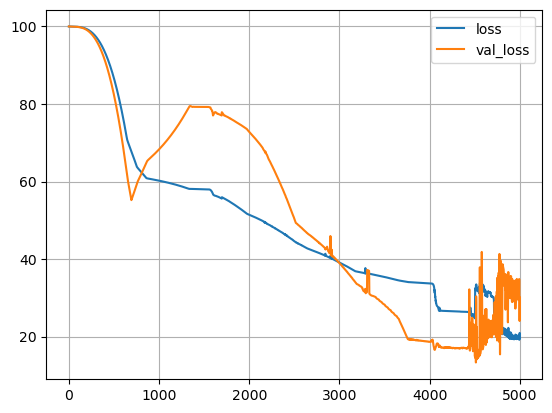

In [21]:
result = pd.DataFrame({'loss': history_30.history['loss'], 'val_loss': history_30.history['val_loss']})
result.plot.line(grid=True)

In [22]:
result['val_loss'].min()

13.34334659576416

In [23]:
result['val_loss'].idxmin()

4512

In [24]:
model_30.evaluate({'time_dependent': X_test,
    'time_independent': well_data_test},
    y_test)

1/1 [==============================] - 0s 16ms/step - loss: 63.9986 - mape: 63.9986


[63.998626708984375, 63.998626708984375]

# Построение модели на основе данных за первые 6 дней

In [25]:
n_days = 6

In [26]:
well_data_train = np.load('well_data_train_5.npy')
well_data_test = np.load('well_data_test_5.npy')
X_test = np.load('X_test_5.npy')
X_train = np.load('X_train_5.npy')

In [27]:
X_train.shape

(21, 6, 9)

In [28]:
well_data_train.shape

(21, 23)

In [29]:
y_train = pd.read_csv('y_train.csv', index_col='period')

In [30]:
y_test = pd.read_csv('y_test_short.csv', index_col='period')

In [31]:
time_dependent_input = keras.Input(
    shape=(n_days, 9),
    name='time_dependent'
)
time_independent_input = keras.Input(
    shape=(23),
    name='time_independent'
)
dep = layers.Dense(4, activation='relu')(time_dependent_input)
dep = layers.Flatten()(dep)

indep = layers.Dense(12, activation='relu')(time_independent_input)

x = layers.concatenate([dep, indep])

x = layers.Dense(32,  activation='relu')(x)
pred = layers.Dense(1)(x)

model_6 = keras.Model(
    inputs = [time_dependent_input, time_independent_input],
    outputs = [pred]
)

In [32]:
model_6.compile(
    loss="mape",
    optimizer="adam",
    metrics=['mape']
)

In [33]:
%%time
%%chime
history_6 = model_6.fit(
    {'time_dependent': X_train,
    'time_independent': well_data_train},
    y_train,
    epochs=10000,
    verbose=1,
    validation_split=0.1
)

Epoch 1/10000
1/1 [==============================] - 1s 827ms/step - loss: 100.0018 - mape: 100.0018 - val_loss: 100.0005 - val_mape: 100.0005
Epoch 2/10000
1/1 [==============================] - 0s 28ms/step - loss: 100.0009 - mape: 100.0009 - val_loss: 99.9992 - val_mape: 99.9992
Epoch 3/10000
1/1 [==============================] - 0s 25ms/step - loss: 100.0000 - mape: 100.0000 - val_loss: 99.9980 - val_mape: 99.9980
Epoch 4/10000
1/1 [==============================] - 0s 25ms/step - loss: 99.9991 - mape: 99.9991 - val_loss: 99.9968 - val_mape: 99.9968
Epoch 5/10000
1/1 [==============================] - 0s 26ms/step - loss: 99.9982 - mape: 99.9982 - val_loss: 99.9956 - val_mape: 99.9956
Epoch 6/10000
1/1 [==============================] - 0s 25ms/step - loss: 99.9973 - mape: 99.9973 - val_loss: 99.9944 - val_mape: 99.9944
Epoch 7/10000
1/1 [==============================] - 0s 47ms/step - loss: 99.9964 - mape: 99.9964 - val_loss: 99.9931 - val_mape: 99.9931
Epoch 8/10000
1/1 [======

Epoch 60/10000
1/1 [==============================] - 0s 24ms/step - loss: 99.9266 - mape: 99.9266 - val_loss: 99.8993 - val_mape: 99.8993
Epoch 61/10000
1/1 [==============================] - 0s 24ms/step - loss: 99.9245 - mape: 99.9245 - val_loss: 99.8964 - val_mape: 99.8964
Epoch 62/10000
1/1 [==============================] - 0s 24ms/step - loss: 99.9223 - mape: 99.9223 - val_loss: 99.8934 - val_mape: 99.8934
Epoch 63/10000
1/1 [==============================] - 0s 23ms/step - loss: 99.9200 - mape: 99.9200 - val_loss: 99.8904 - val_mape: 99.8904
Epoch 64/10000
1/1 [==============================] - 0s 24ms/step - loss: 99.9177 - mape: 99.9177 - val_loss: 99.8873 - val_mape: 99.8873
Epoch 65/10000
1/1 [==============================] - 0s 24ms/step - loss: 99.9153 - mape: 99.9153 - val_loss: 99.8842 - val_mape: 99.8842
Epoch 66/10000
1/1 [==============================] - 0s 24ms/step - loss: 99.9129 - mape: 99.9129 - val_loss: 99.8809 - val_mape: 99.8809
Epoch 67/10000
1/1 [=======

Epoch 119/10000
1/1 [==============================] - 0s 23ms/step - loss: 99.6777 - mape: 99.6777 - val_loss: 99.5732 - val_mape: 99.5732
Epoch 120/10000
1/1 [==============================] - 0s 25ms/step - loss: 99.6708 - mape: 99.6708 - val_loss: 99.5643 - val_mape: 99.5643
Epoch 121/10000
1/1 [==============================] - 0s 23ms/step - loss: 99.6638 - mape: 99.6638 - val_loss: 99.5553 - val_mape: 99.5553
Epoch 122/10000
1/1 [==============================] - 0s 25ms/step - loss: 99.6568 - mape: 99.6568 - val_loss: 99.5461 - val_mape: 99.5461
Epoch 123/10000
1/1 [==============================] - 0s 24ms/step - loss: 99.6496 - mape: 99.6496 - val_loss: 99.5368 - val_mape: 99.5368
Epoch 124/10000
1/1 [==============================] - 0s 24ms/step - loss: 99.6423 - mape: 99.6423 - val_loss: 99.5273 - val_mape: 99.5273
Epoch 125/10000
1/1 [==============================] - 0s 23ms/step - loss: 99.6349 - mape: 99.6349 - val_loss: 99.5177 - val_mape: 99.5177
Epoch 126/10000
1/1 

1/1 [==============================] - 0s 25ms/step - loss: 97.6647 - mape: 97.6647 - val_loss: 96.9808 - val_mape: 96.9808
Epoch 236/10000
1/1 [==============================] - 0s 23ms/step - loss: 97.6330 - mape: 97.6330 - val_loss: 96.9401 - val_mape: 96.9401
Epoch 237/10000
1/1 [==============================] - 0s 24ms/step - loss: 97.6010 - mape: 97.6010 - val_loss: 96.8990 - val_mape: 96.8990
Epoch 238/10000
1/1 [==============================] - 0s 24ms/step - loss: 97.5687 - mape: 97.5687 - val_loss: 96.8576 - val_mape: 96.8576
Epoch 239/10000
1/1 [==============================] - 0s 24ms/step - loss: 97.5361 - mape: 97.5361 - val_loss: 96.8157 - val_mape: 96.8157
Epoch 240/10000
1/1 [==============================] - 0s 24ms/step - loss: 97.5032 - mape: 97.5032 - val_loss: 96.7735 - val_mape: 96.7735
Epoch 241/10000
1/1 [==============================] - 0s 24ms/step - loss: 97.4700 - mape: 97.4700 - val_loss: 96.7308 - val_mape: 96.7308
Epoch 242/10000
1/1 [===============

1/1 [==============================] - 0s 24ms/step - loss: 91.6700 - mape: 91.6700 - val_loss: 89.2951 - val_mape: 89.2951
Epoch 352/10000
1/1 [==============================] - 0s 24ms/step - loss: 91.5951 - mape: 91.5951 - val_loss: 89.1992 - val_mape: 89.1992
Epoch 353/10000
1/1 [==============================] - 0s 24ms/step - loss: 91.5198 - mape: 91.5198 - val_loss: 89.1027 - val_mape: 89.1027
Epoch 354/10000
1/1 [==============================] - 0s 23ms/step - loss: 91.4440 - mape: 91.4440 - val_loss: 89.0057 - val_mape: 89.0057
Epoch 355/10000
1/1 [==============================] - 0s 24ms/step - loss: 91.3678 - mape: 91.3678 - val_loss: 88.9081 - val_mape: 88.9081
Epoch 356/10000
1/1 [==============================] - 0s 24ms/step - loss: 91.2912 - mape: 91.2912 - val_loss: 88.8100 - val_mape: 88.8100
Epoch 357/10000
1/1 [==============================] - 0s 24ms/step - loss: 91.2141 - mape: 91.2141 - val_loss: 88.7112 - val_mape: 88.7112
Epoch 358/10000
1/1 [===============

1/1 [==============================] - 0s 24ms/step - loss: 79.7333 - mape: 79.7333 - val_loss: 74.0192 - val_mape: 74.0192
Epoch 468/10000
1/1 [==============================] - 0s 23ms/step - loss: 79.5994 - mape: 79.5994 - val_loss: 73.8480 - val_mape: 73.8480
Epoch 469/10000
1/1 [==============================] - 0s 24ms/step - loss: 79.4649 - mape: 79.4649 - val_loss: 73.6759 - val_mape: 73.6759
Epoch 470/10000
1/1 [==============================] - 0s 24ms/step - loss: 79.3298 - mape: 79.3298 - val_loss: 73.5032 - val_mape: 73.5032
Epoch 471/10000
1/1 [==============================] - 0s 23ms/step - loss: 79.1942 - mape: 79.1942 - val_loss: 73.3297 - val_mape: 73.3297
Epoch 472/10000
1/1 [==============================] - 0s 23ms/step - loss: 79.0580 - mape: 79.0580 - val_loss: 73.1555 - val_mape: 73.1555
Epoch 473/10000
1/1 [==============================] - 0s 23ms/step - loss: 78.9212 - mape: 78.9212 - val_loss: 72.9806 - val_mape: 72.9806
Epoch 474/10000
1/1 [===============

1/1 [==============================] - 0s 24ms/step - loss: 64.6621 - mape: 64.6621 - val_loss: 53.9278 - val_mape: 53.9278
Epoch 584/10000
1/1 [==============================] - 0s 25ms/step - loss: 64.5709 - mape: 64.5709 - val_loss: 54.0040 - val_mape: 54.0040
Epoch 585/10000
1/1 [==============================] - 0s 23ms/step - loss: 64.4795 - mape: 64.4795 - val_loss: 54.0804 - val_mape: 54.0804
Epoch 586/10000
1/1 [==============================] - 0s 24ms/step - loss: 64.3877 - mape: 64.3877 - val_loss: 54.1572 - val_mape: 54.1572
Epoch 587/10000
1/1 [==============================] - 0s 24ms/step - loss: 64.2956 - mape: 64.2956 - val_loss: 54.2342 - val_mape: 54.2342
Epoch 588/10000
1/1 [==============================] - 0s 24ms/step - loss: 64.2032 - mape: 64.2032 - val_loss: 54.3115 - val_mape: 54.3115
Epoch 589/10000
1/1 [==============================] - 0s 24ms/step - loss: 64.1104 - mape: 64.1104 - val_loss: 54.3890 - val_mape: 54.3890
Epoch 590/10000
1/1 [===============

1/1 [==============================] - 0s 24ms/step - loss: 56.5843 - mape: 56.5843 - val_loss: 62.2467 - val_mape: 62.2467
Epoch 700/10000
1/1 [==============================] - 0s 24ms/step - loss: 56.5659 - mape: 56.5659 - val_loss: 62.2860 - val_mape: 62.2860
Epoch 701/10000
1/1 [==============================] - 0s 24ms/step - loss: 56.5477 - mape: 56.5477 - val_loss: 62.3243 - val_mape: 62.3243
Epoch 702/10000
1/1 [==============================] - 0s 24ms/step - loss: 56.5299 - mape: 56.5299 - val_loss: 62.3616 - val_mape: 62.3616
Epoch 703/10000
1/1 [==============================] - 0s 23ms/step - loss: 56.5123 - mape: 56.5123 - val_loss: 62.3982 - val_mape: 62.3982
Epoch 704/10000
1/1 [==============================] - 0s 23ms/step - loss: 56.4949 - mape: 56.4949 - val_loss: 62.4339 - val_mape: 62.4339
Epoch 705/10000
1/1 [==============================] - 0s 24ms/step - loss: 56.4777 - mape: 56.4777 - val_loss: 62.4691 - val_mape: 62.4691
Epoch 706/10000
1/1 [===============

1/1 [==============================] - 0s 24ms/step - loss: 54.5445 - mape: 54.5445 - val_loss: 66.2097 - val_mape: 66.2097
Epoch 816/10000
1/1 [==============================] - 0s 24ms/step - loss: 54.5235 - mape: 54.5235 - val_loss: 66.2513 - val_mape: 66.2513
Epoch 817/10000
1/1 [==============================] - 0s 24ms/step - loss: 54.5023 - mape: 54.5023 - val_loss: 66.2931 - val_mape: 66.2931
Epoch 818/10000
1/1 [==============================] - 0s 24ms/step - loss: 54.4811 - mape: 54.4811 - val_loss: 66.3351 - val_mape: 66.3351
Epoch 819/10000
1/1 [==============================] - 0s 24ms/step - loss: 54.4599 - mape: 54.4599 - val_loss: 66.3772 - val_mape: 66.3772
Epoch 820/10000
1/1 [==============================] - 0s 24ms/step - loss: 54.4385 - mape: 54.4385 - val_loss: 66.4194 - val_mape: 66.4194
Epoch 821/10000
1/1 [==============================] - 0s 23ms/step - loss: 54.4171 - mape: 54.4171 - val_loss: 66.4619 - val_mape: 66.4619
Epoch 822/10000
1/1 [===============

1/1 [==============================] - 0s 24ms/step - loss: 51.6606 - mape: 51.6606 - val_loss: 72.0016 - val_mape: 72.0016
Epoch 932/10000
1/1 [==============================] - 0s 24ms/step - loss: 51.6318 - mape: 51.6318 - val_loss: 72.0598 - val_mape: 72.0598
Epoch 933/10000
1/1 [==============================] - 0s 23ms/step - loss: 51.6029 - mape: 51.6029 - val_loss: 72.1182 - val_mape: 72.1182
Epoch 934/10000
1/1 [==============================] - 0s 23ms/step - loss: 51.5740 - mape: 51.5740 - val_loss: 72.1767 - val_mape: 72.1767
Epoch 935/10000
1/1 [==============================] - 0s 24ms/step - loss: 51.5450 - mape: 51.5450 - val_loss: 72.2354 - val_mape: 72.2354
Epoch 936/10000
1/1 [==============================] - 0s 24ms/step - loss: 51.5159 - mape: 51.5159 - val_loss: 72.2942 - val_mape: 72.2942
Epoch 937/10000
1/1 [==============================] - 0s 24ms/step - loss: 51.4868 - mape: 51.4868 - val_loss: 72.3531 - val_mape: 72.3531
Epoch 938/10000
1/1 [===============

1/1 [==============================] - 0s 24ms/step - loss: 49.7478 - mape: 49.7478 - val_loss: 74.7827 - val_mape: 74.7827
Epoch 1048/10000
1/1 [==============================] - 0s 24ms/step - loss: 49.7358 - mape: 49.7358 - val_loss: 74.7880 - val_mape: 74.7880
Epoch 1049/10000
1/1 [==============================] - 0s 24ms/step - loss: 49.7238 - mape: 49.7238 - val_loss: 74.7933 - val_mape: 74.7933
Epoch 1050/10000
1/1 [==============================] - 0s 24ms/step - loss: 49.7118 - mape: 49.7118 - val_loss: 74.7986 - val_mape: 74.7986
Epoch 1051/10000
1/1 [==============================] - 0s 23ms/step - loss: 49.6997 - mape: 49.6997 - val_loss: 74.8040 - val_mape: 74.8040
Epoch 1052/10000
1/1 [==============================] - 0s 23ms/step - loss: 49.6876 - mape: 49.6876 - val_loss: 74.8094 - val_mape: 74.8094
Epoch 1053/10000
1/1 [==============================] - 0s 23ms/step - loss: 49.6756 - mape: 49.6756 - val_loss: 74.8148 - val_mape: 74.8148
Epoch 1054/10000
1/1 [========

1/1 [==============================] - 0s 24ms/step - loss: 48.4824 - mape: 48.4824 - val_loss: 73.3359 - val_mape: 73.3359
Epoch 1164/10000
1/1 [==============================] - 0s 25ms/step - loss: 48.4712 - mape: 48.4712 - val_loss: 73.3225 - val_mape: 73.3225
Epoch 1165/10000
1/1 [==============================] - 0s 26ms/step - loss: 48.4606 - mape: 48.4606 - val_loss: 73.3056 - val_mape: 73.3056
Epoch 1166/10000
1/1 [==============================] - 0s 26ms/step - loss: 48.4501 - mape: 48.4501 - val_loss: 73.2856 - val_mape: 73.2856
Epoch 1167/10000
1/1 [==============================] - 0s 26ms/step - loss: 48.4392 - mape: 48.4392 - val_loss: 73.2628 - val_mape: 73.2628
Epoch 1168/10000
1/1 [==============================] - 0s 25ms/step - loss: 48.4279 - mape: 48.4279 - val_loss: 73.2376 - val_mape: 73.2376
Epoch 1169/10000
1/1 [==============================] - 0s 25ms/step - loss: 48.4176 - mape: 48.4176 - val_loss: 73.2157 - val_mape: 73.2157
Epoch 1170/10000
1/1 [========

1/1 [==============================] - 0s 23ms/step - loss: 47.2379 - mape: 47.2379 - val_loss: 71.3606 - val_mape: 71.3606
Epoch 1280/10000
1/1 [==============================] - 0s 24ms/step - loss: 47.2284 - mape: 47.2284 - val_loss: 71.3573 - val_mape: 71.3573
Epoch 1281/10000
1/1 [==============================] - 0s 23ms/step - loss: 47.2197 - mape: 47.2197 - val_loss: 71.3498 - val_mape: 71.3498
Epoch 1282/10000
1/1 [==============================] - 0s 24ms/step - loss: 47.2107 - mape: 47.2107 - val_loss: 71.3385 - val_mape: 71.3385
Epoch 1283/10000
1/1 [==============================] - 0s 24ms/step - loss: 47.2010 - mape: 47.2010 - val_loss: 71.3238 - val_mape: 71.3238
Epoch 1284/10000
1/1 [==============================] - 0s 24ms/step - loss: 47.1922 - mape: 47.1922 - val_loss: 71.3126 - val_mape: 71.3126
Epoch 1285/10000
1/1 [==============================] - 0s 24ms/step - loss: 47.1833 - mape: 47.1833 - val_loss: 71.3047 - val_mape: 71.3047
Epoch 1286/10000
1/1 [========

1/1 [==============================] - 0s 25ms/step - loss: 46.0982 - mape: 46.0982 - val_loss: 70.3129 - val_mape: 70.3129
Epoch 1396/10000
1/1 [==============================] - 0s 24ms/step - loss: 46.0882 - mape: 46.0882 - val_loss: 70.3022 - val_mape: 70.3022
Epoch 1397/10000
1/1 [==============================] - 0s 23ms/step - loss: 46.0777 - mape: 46.0777 - val_loss: 70.2950 - val_mape: 70.2950
Epoch 1398/10000
1/1 [==============================] - 0s 24ms/step - loss: 46.0668 - mape: 46.0668 - val_loss: 70.2908 - val_mape: 70.2908
Epoch 1399/10000
1/1 [==============================] - 0s 23ms/step - loss: 46.0554 - mape: 46.0554 - val_loss: 70.2894 - val_mape: 70.2894
Epoch 1400/10000
1/1 [==============================] - 0s 24ms/step - loss: 46.0451 - mape: 46.0451 - val_loss: 70.2837 - val_mape: 70.2837
Epoch 1401/10000
1/1 [==============================] - 0s 24ms/step - loss: 46.0349 - mape: 46.0349 - val_loss: 70.2741 - val_mape: 70.2741
Epoch 1402/10000
1/1 [========

1/1 [==============================] - 0s 25ms/step - loss: 44.7711 - mape: 44.7711 - val_loss: 69.1037 - val_mape: 69.1037
Epoch 1512/10000
1/1 [==============================] - 0s 24ms/step - loss: 44.7591 - mape: 44.7591 - val_loss: 69.0960 - val_mape: 69.0960
Epoch 1513/10000
1/1 [==============================] - 0s 24ms/step - loss: 44.7472 - mape: 44.7472 - val_loss: 69.0846 - val_mape: 69.0846
Epoch 1514/10000
1/1 [==============================] - 0s 23ms/step - loss: 44.7349 - mape: 44.7349 - val_loss: 69.0700 - val_mape: 69.0700
Epoch 1515/10000
1/1 [==============================] - 0s 24ms/step - loss: 44.7221 - mape: 44.7221 - val_loss: 69.0525 - val_mape: 69.0525
Epoch 1516/10000
1/1 [==============================] - 0s 23ms/step - loss: 44.7090 - mape: 44.7090 - val_loss: 69.0323 - val_mape: 69.0323
Epoch 1517/10000
1/1 [==============================] - 0s 23ms/step - loss: 44.6978 - mape: 44.6978 - val_loss: 69.0169 - val_mape: 69.0169
Epoch 1518/10000
1/1 [========

1/1 [==============================] - 0s 24ms/step - loss: 43.2294 - mape: 43.2294 - val_loss: 67.6585 - val_mape: 67.6585
Epoch 1628/10000
1/1 [==============================] - 0s 24ms/step - loss: 43.2145 - mape: 43.2145 - val_loss: 67.6376 - val_mape: 67.6376
Epoch 1629/10000
1/1 [==============================] - 0s 24ms/step - loss: 43.2007 - mape: 43.2007 - val_loss: 67.6218 - val_mape: 67.6218
Epoch 1630/10000
1/1 [==============================] - 0s 23ms/step - loss: 43.1868 - mape: 43.1868 - val_loss: 67.6106 - val_mape: 67.6106
Epoch 1631/10000
1/1 [==============================] - 0s 24ms/step - loss: 43.1720 - mape: 43.1720 - val_loss: 67.6034 - val_mape: 67.6034
Epoch 1632/10000
1/1 [==============================] - 0s 24ms/step - loss: 43.1569 - mape: 43.1569 - val_loss: 67.5928 - val_mape: 67.5928
Epoch 1633/10000
1/1 [==============================] - 0s 24ms/step - loss: 43.1429 - mape: 43.1429 - val_loss: 67.5790 - val_mape: 67.5790
Epoch 1634/10000
1/1 [========

1/1 [==============================] - 0s 24ms/step - loss: 41.4389 - mape: 41.4389 - val_loss: 65.9613 - val_mape: 65.9613
Epoch 1744/10000
1/1 [==============================] - 0s 23ms/step - loss: 41.4223 - mape: 41.4223 - val_loss: 65.9425 - val_mape: 65.9425
Epoch 1745/10000
1/1 [==============================] - 0s 23ms/step - loss: 41.4061 - mape: 41.4061 - val_loss: 65.9289 - val_mape: 65.9289
Epoch 1746/10000
1/1 [==============================] - 0s 24ms/step - loss: 41.3890 - mape: 41.3890 - val_loss: 65.9199 - val_mape: 65.9199
Epoch 1747/10000
1/1 [==============================] - 0s 24ms/step - loss: 41.3729 - mape: 41.3729 - val_loss: 65.9077 - val_mape: 65.9077
Epoch 1748/10000
1/1 [==============================] - 0s 23ms/step - loss: 41.3565 - mape: 41.3565 - val_loss: 65.8928 - val_mape: 65.8928
Epoch 1749/10000
1/1 [==============================] - 0s 24ms/step - loss: 41.3399 - mape: 41.3399 - val_loss: 65.8753 - val_mape: 65.8753
Epoch 1750/10000
1/1 [========

1/1 [==============================] - 0s 25ms/step - loss: 39.3681 - mape: 39.3681 - val_loss: 63.9184 - val_mape: 63.9184
Epoch 1860/10000
1/1 [==============================] - 0s 23ms/step - loss: 39.3570 - mape: 39.3570 - val_loss: 63.8918 - val_mape: 63.8918
Epoch 1861/10000
1/1 [==============================] - 0s 24ms/step - loss: 39.3463 - mape: 39.3463 - val_loss: 63.8667 - val_mape: 63.8667
Epoch 1862/10000
1/1 [==============================] - 0s 22ms/step - loss: 39.3357 - mape: 39.3357 - val_loss: 63.8431 - val_mape: 63.8431
Epoch 1863/10000
1/1 [==============================] - 0s 23ms/step - loss: 39.3254 - mape: 39.3254 - val_loss: 63.8209 - val_mape: 63.8209
Epoch 1864/10000
1/1 [==============================] - 0s 23ms/step - loss: 39.3153 - mape: 39.3153 - val_loss: 63.7997 - val_mape: 63.7997
Epoch 1865/10000
1/1 [==============================] - 0s 23ms/step - loss: 39.3053 - mape: 39.3053 - val_loss: 63.7797 - val_mape: 63.7797
Epoch 1866/10000
1/1 [========

1/1 [==============================] - 0s 24ms/step - loss: 38.5612 - mape: 38.5612 - val_loss: 60.8098 - val_mape: 60.8098
Epoch 1976/10000
1/1 [==============================] - 0s 23ms/step - loss: 38.5546 - mape: 38.5546 - val_loss: 60.7757 - val_mape: 60.7757
Epoch 1977/10000
1/1 [==============================] - 0s 24ms/step - loss: 38.5487 - mape: 38.5487 - val_loss: 60.7440 - val_mape: 60.7440
Epoch 1978/10000
1/1 [==============================] - 0s 23ms/step - loss: 38.5428 - mape: 38.5428 - val_loss: 60.7147 - val_mape: 60.7147
Epoch 1979/10000
1/1 [==============================] - 0s 23ms/step - loss: 38.5364 - mape: 38.5364 - val_loss: 60.6874 - val_mape: 60.6874
Epoch 1980/10000
1/1 [==============================] - 0s 24ms/step - loss: 38.5298 - mape: 38.5298 - val_loss: 60.6619 - val_mape: 60.6619
Epoch 1981/10000
1/1 [==============================] - 0s 23ms/step - loss: 38.5236 - mape: 38.5236 - val_loss: 60.6335 - val_mape: 60.6335
Epoch 1982/10000
1/1 [========

1/1 [==============================] - 0s 24ms/step - loss: 37.8444 - mape: 37.8444 - val_loss: 57.3758 - val_mape: 57.3758
Epoch 2092/10000
1/1 [==============================] - 0s 24ms/step - loss: 37.8385 - mape: 37.8385 - val_loss: 57.3477 - val_mape: 57.3477
Epoch 2093/10000
1/1 [==============================] - 0s 24ms/step - loss: 37.8322 - mape: 37.8322 - val_loss: 57.3217 - val_mape: 57.3217
Epoch 2094/10000
1/1 [==============================] - 0s 24ms/step - loss: 37.8266 - mape: 37.8266 - val_loss: 57.2933 - val_mape: 57.2933
Epoch 2095/10000
1/1 [==============================] - 0s 23ms/step - loss: 37.8207 - mape: 37.8207 - val_loss: 57.2627 - val_mape: 57.2627
Epoch 2096/10000
1/1 [==============================] - 0s 24ms/step - loss: 37.8144 - mape: 37.8144 - val_loss: 57.2301 - val_mape: 57.2301
Epoch 2097/10000
1/1 [==============================] - 0s 23ms/step - loss: 37.8078 - mape: 37.8078 - val_loss: 57.2001 - val_mape: 57.2001
Epoch 2098/10000
1/1 [========

1/1 [==============================] - 0s 24ms/step - loss: 37.1518 - mape: 37.1518 - val_loss: 54.0172 - val_mape: 54.0172
Epoch 2208/10000
1/1 [==============================] - 0s 24ms/step - loss: 37.1456 - mape: 37.1456 - val_loss: 53.9954 - val_mape: 53.9954
Epoch 2209/10000
1/1 [==============================] - 0s 24ms/step - loss: 37.1404 - mape: 37.1404 - val_loss: 53.9711 - val_mape: 53.9711
Epoch 2210/10000
1/1 [==============================] - 0s 23ms/step - loss: 37.1353 - mape: 37.1353 - val_loss: 53.9444 - val_mape: 53.9444
Epoch 2211/10000
1/1 [==============================] - 0s 24ms/step - loss: 37.1298 - mape: 37.1298 - val_loss: 53.9158 - val_mape: 53.9158
Epoch 2212/10000
1/1 [==============================] - 0s 24ms/step - loss: 37.1240 - mape: 37.1240 - val_loss: 53.8852 - val_mape: 53.8852
Epoch 2213/10000
1/1 [==============================] - 0s 23ms/step - loss: 37.1178 - mape: 37.1178 - val_loss: 53.8531 - val_mape: 53.8531
Epoch 2214/10000
1/1 [========

1/1 [==============================] - 0s 26ms/step - loss: 36.5090 - mape: 36.5090 - val_loss: 50.8900 - val_mape: 50.8900
Epoch 2324/10000
1/1 [==============================] - 0s 26ms/step - loss: 36.5038 - mape: 36.5038 - val_loss: 50.8640 - val_mape: 50.8640
Epoch 2325/10000
1/1 [==============================] - 0s 25ms/step - loss: 36.4979 - mape: 36.4979 - val_loss: 50.8405 - val_mape: 50.8405
Epoch 2326/10000
1/1 [==============================] - 0s 26ms/step - loss: 36.4925 - mape: 36.4925 - val_loss: 50.8147 - val_mape: 50.8147
Epoch 2327/10000
1/1 [==============================] - 0s 25ms/step - loss: 36.4873 - mape: 36.4873 - val_loss: 50.7871 - val_mape: 50.7871
Epoch 2328/10000
1/1 [==============================] - 0s 24ms/step - loss: 36.4817 - mape: 36.4817 - val_loss: 50.7578 - val_mape: 50.7578
Epoch 2329/10000
1/1 [==============================] - 0s 26ms/step - loss: 36.4758 - mape: 36.4758 - val_loss: 50.7270 - val_mape: 50.7270
Epoch 2330/10000
1/1 [========

1/1 [==============================] - 0s 25ms/step - loss: 36.0512 - mape: 36.0512 - val_loss: 48.7675 - val_mape: 48.7675
Epoch 2440/10000
1/1 [==============================] - 0s 24ms/step - loss: 36.0499 - mape: 36.0499 - val_loss: 48.7585 - val_mape: 48.7585
Epoch 2441/10000
1/1 [==============================] - 0s 24ms/step - loss: 36.0478 - mape: 36.0478 - val_loss: 48.7463 - val_mape: 48.7463
Epoch 2442/10000
1/1 [==============================] - 0s 24ms/step - loss: 36.0467 - mape: 36.0467 - val_loss: 48.7399 - val_mape: 48.7399
Epoch 2443/10000
1/1 [==============================] - 0s 24ms/step - loss: 36.0457 - mape: 36.0457 - val_loss: 48.7387 - val_mape: 48.7387
Epoch 2444/10000
1/1 [==============================] - 0s 24ms/step - loss: 36.0432 - mape: 36.0432 - val_loss: 48.7341 - val_mape: 48.7341
Epoch 2445/10000
1/1 [==============================] - 0s 24ms/step - loss: 36.0420 - mape: 36.0420 - val_loss: 48.7266 - val_mape: 48.7266
Epoch 2446/10000
1/1 [========

1/1 [==============================] - 0s 24ms/step - loss: 35.8977 - mape: 35.8977 - val_loss: 48.1675 - val_mape: 48.1675
Epoch 2556/10000
1/1 [==============================] - 0s 23ms/step - loss: 35.8954 - mape: 35.8954 - val_loss: 48.1638 - val_mape: 48.1638
Epoch 2557/10000
1/1 [==============================] - 0s 23ms/step - loss: 35.8943 - mape: 35.8943 - val_loss: 48.1563 - val_mape: 48.1563
Epoch 2558/10000
1/1 [==============================] - 0s 24ms/step - loss: 35.8926 - mape: 35.8926 - val_loss: 48.1541 - val_mape: 48.1541
Epoch 2559/10000
1/1 [==============================] - 0s 23ms/step - loss: 35.8917 - mape: 35.8917 - val_loss: 48.1479 - val_mape: 48.1479
Epoch 2560/10000
1/1 [==============================] - 0s 24ms/step - loss: 35.8902 - mape: 35.8902 - val_loss: 48.1382 - val_mape: 48.1382
Epoch 2561/10000
1/1 [==============================] - 0s 24ms/step - loss: 35.8889 - mape: 35.8889 - val_loss: 48.1341 - val_mape: 48.1341
Epoch 2562/10000
1/1 [========

1/1 [==============================] - 0s 25ms/step - loss: 35.7327 - mape: 35.7327 - val_loss: 47.5163 - val_mape: 47.5163
Epoch 2672/10000
1/1 [==============================] - 0s 24ms/step - loss: 35.7313 - mape: 35.7313 - val_loss: 47.5127 - val_mape: 47.5127
Epoch 2673/10000
1/1 [==============================] - 0s 23ms/step - loss: 35.7295 - mape: 35.7295 - val_loss: 47.5059 - val_mape: 47.5059
Epoch 2674/10000
1/1 [==============================] - 0s 25ms/step - loss: 35.7282 - mape: 35.7282 - val_loss: 47.5045 - val_mape: 47.5045
Epoch 2675/10000
1/1 [==============================] - 0s 23ms/step - loss: 35.7271 - mape: 35.7271 - val_loss: 47.4990 - val_mape: 47.4990
Epoch 2676/10000
1/1 [==============================] - 0s 24ms/step - loss: 35.7257 - mape: 35.7257 - val_loss: 47.4898 - val_mape: 47.4898
Epoch 2677/10000
1/1 [==============================] - 0s 23ms/step - loss: 35.7236 - mape: 35.7236 - val_loss: 47.4773 - val_mape: 47.4773
Epoch 2678/10000
1/1 [========

1/1 [==============================] - 0s 24ms/step - loss: 35.5579 - mape: 35.5579 - val_loss: 46.7977 - val_mape: 46.7977
Epoch 2788/10000
1/1 [==============================] - 0s 24ms/step - loss: 35.5553 - mape: 35.5553 - val_loss: 46.8006 - val_mape: 46.8006
Epoch 2789/10000
1/1 [==============================] - 0s 23ms/step - loss: 35.5524 - mape: 35.5524 - val_loss: 46.7988 - val_mape: 46.7988
Epoch 2790/10000
1/1 [==============================] - 0s 24ms/step - loss: 35.5516 - mape: 35.5516 - val_loss: 46.7929 - val_mape: 46.7929
Epoch 2791/10000
1/1 [==============================] - 0s 23ms/step - loss: 35.5501 - mape: 35.5501 - val_loss: 46.7832 - val_mape: 46.7832
Epoch 2792/10000
1/1 [==============================] - 0s 23ms/step - loss: 35.5480 - mape: 35.5480 - val_loss: 46.7702 - val_mape: 46.7702
Epoch 2793/10000
1/1 [==============================] - 0s 24ms/step - loss: 35.5460 - mape: 35.5460 - val_loss: 46.7649 - val_mape: 46.7649
Epoch 2794/10000
1/1 [========

1/1 [==============================] - 0s 24ms/step - loss: 35.3846 - mape: 35.3846 - val_loss: 46.2631 - val_mape: 46.2631
Epoch 2904/10000
1/1 [==============================] - 0s 24ms/step - loss: 35.3839 - mape: 35.3839 - val_loss: 46.2570 - val_mape: 46.2570
Epoch 2905/10000
1/1 [==============================] - 0s 25ms/step - loss: 35.3822 - mape: 35.3822 - val_loss: 46.2482 - val_mape: 46.2482
Epoch 2906/10000
1/1 [==============================] - 0s 24ms/step - loss: 35.3798 - mape: 35.3798 - val_loss: 46.2368 - val_mape: 46.2368
Epoch 2907/10000
1/1 [==============================] - 0s 24ms/step - loss: 35.3788 - mape: 35.3788 - val_loss: 46.2313 - val_mape: 46.2313
Epoch 2908/10000
1/1 [==============================] - 0s 25ms/step - loss: 35.3776 - mape: 35.3776 - val_loss: 46.2311 - val_mape: 46.2311
Epoch 2909/10000
1/1 [==============================] - 0s 24ms/step - loss: 35.3746 - mape: 35.3746 - val_loss: 46.2365 - val_mape: 46.2365
Epoch 2910/10000
1/1 [========

1/1 [==============================] - 0s 24ms/step - loss: 35.2001 - mape: 35.2001 - val_loss: 45.6649 - val_mape: 45.6649
Epoch 3020/10000
1/1 [==============================] - 0s 24ms/step - loss: 35.1983 - mape: 35.1983 - val_loss: 45.6554 - val_mape: 45.6554
Epoch 3021/10000
1/1 [==============================] - 0s 24ms/step - loss: 35.1968 - mape: 35.1968 - val_loss: 45.6526 - val_mape: 45.6526
Epoch 3022/10000
1/1 [==============================] - 0s 24ms/step - loss: 35.1945 - mape: 35.1945 - val_loss: 45.6457 - val_mape: 45.6457
Epoch 3023/10000
1/1 [==============================] - 0s 23ms/step - loss: 35.1933 - mape: 35.1933 - val_loss: 45.6453 - val_mape: 45.6453
Epoch 3024/10000
1/1 [==============================] - 0s 24ms/step - loss: 35.1918 - mape: 35.1918 - val_loss: 45.6405 - val_mape: 45.6405
Epoch 3025/10000
1/1 [==============================] - 0s 24ms/step - loss: 35.1902 - mape: 35.1902 - val_loss: 45.6326 - val_mape: 45.6326
Epoch 3026/10000
1/1 [========

1/1 [==============================] - 0s 24ms/step - loss: 35.0023 - mape: 35.0023 - val_loss: 45.0178 - val_mape: 45.0178
Epoch 3136/10000
1/1 [==============================] - 0s 23ms/step - loss: 34.9994 - mape: 34.9994 - val_loss: 45.0083 - val_mape: 45.0083
Epoch 3137/10000
1/1 [==============================] - 0s 24ms/step - loss: 34.9983 - mape: 34.9983 - val_loss: 45.0047 - val_mape: 45.0047
Epoch 3138/10000
1/1 [==============================] - 0s 24ms/step - loss: 34.9952 - mape: 34.9952 - val_loss: 45.0062 - val_mape: 45.0062
Epoch 3139/10000
1/1 [==============================] - 0s 23ms/step - loss: 34.9952 - mape: 34.9952 - val_loss: 45.0041 - val_mape: 45.0041
Epoch 3140/10000
1/1 [==============================] - 0s 24ms/step - loss: 34.9944 - mape: 34.9944 - val_loss: 44.9985 - val_mape: 44.9985
Epoch 3141/10000
1/1 [==============================] - 0s 24ms/step - loss: 34.9927 - mape: 34.9927 - val_loss: 44.9909 - val_mape: 44.9909
Epoch 3142/10000
1/1 [========

1/1 [==============================] - 0s 24ms/step - loss: 34.7855 - mape: 34.7855 - val_loss: 44.3022 - val_mape: 44.3022
Epoch 3252/10000
1/1 [==============================] - 0s 24ms/step - loss: 34.7831 - mape: 34.7831 - val_loss: 44.2908 - val_mape: 44.2908
Epoch 3253/10000
1/1 [==============================] - 0s 23ms/step - loss: 34.7823 - mape: 34.7823 - val_loss: 44.2867 - val_mape: 44.2867
Epoch 3254/10000
1/1 [==============================] - 0s 24ms/step - loss: 34.7802 - mape: 34.7802 - val_loss: 44.2880 - val_mape: 44.2880
Epoch 3255/10000
1/1 [==============================] - 0s 23ms/step - loss: 34.7775 - mape: 34.7775 - val_loss: 44.2844 - val_mape: 44.2844
Epoch 3256/10000
1/1 [==============================] - 0s 24ms/step - loss: 34.7760 - mape: 34.7760 - val_loss: 44.2765 - val_mape: 44.2765
Epoch 3257/10000
1/1 [==============================] - 0s 23ms/step - loss: 34.7738 - mape: 34.7738 - val_loss: 44.2647 - val_mape: 44.2647
Epoch 3258/10000
1/1 [========

1/1 [==============================] - 0s 24ms/step - loss: 34.5525 - mape: 34.5525 - val_loss: 43.5275 - val_mape: 43.5275
Epoch 3368/10000
1/1 [==============================] - 0s 24ms/step - loss: 34.5504 - mape: 34.5504 - val_loss: 43.5159 - val_mape: 43.5159
Epoch 3369/10000
1/1 [==============================] - 0s 25ms/step - loss: 34.5471 - mape: 34.5471 - val_loss: 43.5031 - val_mape: 43.5031
Epoch 3370/10000
1/1 [==============================] - 0s 24ms/step - loss: 34.5447 - mape: 34.5447 - val_loss: 43.4965 - val_mape: 43.4965
Epoch 3371/10000
1/1 [==============================] - 0s 24ms/step - loss: 34.5432 - mape: 34.5432 - val_loss: 43.4955 - val_mape: 43.4955
Epoch 3372/10000
1/1 [==============================] - 0s 24ms/step - loss: 34.5398 - mape: 34.5398 - val_loss: 43.4898 - val_mape: 43.4898
Epoch 3373/10000
1/1 [==============================] - 0s 23ms/step - loss: 34.5380 - mape: 34.5380 - val_loss: 43.4798 - val_mape: 43.4798
Epoch 3374/10000
1/1 [========

1/1 [==============================] - 0s 23ms/step - loss: 34.2955 - mape: 34.2955 - val_loss: 42.6642 - val_mape: 42.6642
Epoch 3484/10000
1/1 [==============================] - 0s 24ms/step - loss: 34.2932 - mape: 34.2932 - val_loss: 42.6591 - val_mape: 42.6591
Epoch 3485/10000
1/1 [==============================] - 0s 24ms/step - loss: 34.2913 - mape: 34.2913 - val_loss: 42.6509 - val_mape: 42.6509
Epoch 3486/10000
1/1 [==============================] - 0s 23ms/step - loss: 34.2886 - mape: 34.2886 - val_loss: 42.6386 - val_mape: 42.6386
Epoch 3487/10000
1/1 [==============================] - 0s 25ms/step - loss: 34.2855 - mape: 34.2855 - val_loss: 42.6325 - val_mape: 42.6325
Epoch 3488/10000
1/1 [==============================] - 0s 24ms/step - loss: 34.2835 - mape: 34.2835 - val_loss: 42.6220 - val_mape: 42.6220
Epoch 3489/10000
1/1 [==============================] - 0s 24ms/step - loss: 34.2809 - mape: 34.2809 - val_loss: 42.6088 - val_mape: 42.6088
Epoch 3490/10000
1/1 [========

1/1 [==============================] - 0s 25ms/step - loss: 34.0603 - mape: 34.0603 - val_loss: 41.9450 - val_mape: 41.9450
Epoch 3600/10000
1/1 [==============================] - 0s 24ms/step - loss: 34.0622 - mape: 34.0622 - val_loss: 41.9390 - val_mape: 41.9390
Epoch 3601/10000
1/1 [==============================] - 0s 24ms/step - loss: 34.0595 - mape: 34.0595 - val_loss: 41.9234 - val_mape: 41.9234
Epoch 3602/10000
1/1 [==============================] - 0s 24ms/step - loss: 34.0550 - mape: 34.0550 - val_loss: 41.9044 - val_mape: 41.9044
Epoch 3603/10000
1/1 [==============================] - 0s 23ms/step - loss: 34.0569 - mape: 34.0569 - val_loss: 41.8922 - val_mape: 41.8922
Epoch 3604/10000
1/1 [==============================] - 0s 27ms/step - loss: 34.0585 - mape: 34.0585 - val_loss: 41.8890 - val_mape: 41.8890
Epoch 3605/10000
1/1 [==============================] - 0s 27ms/step - loss: 34.0574 - mape: 34.0574 - val_loss: 41.8940 - val_mape: 41.8940
Epoch 3606/10000
1/1 [========

1/1 [==============================] - 0s 43ms/step - loss: 33.9592 - mape: 33.9592 - val_loss: 41.8151 - val_mape: 41.8151
Epoch 3716/10000
1/1 [==============================] - 0s 24ms/step - loss: 33.9575 - mape: 33.9575 - val_loss: 41.8182 - val_mape: 41.8182
Epoch 3717/10000
1/1 [==============================] - 0s 24ms/step - loss: 33.9572 - mape: 33.9572 - val_loss: 41.8189 - val_mape: 41.8189
Epoch 3718/10000
1/1 [==============================] - 0s 24ms/step - loss: 33.9556 - mape: 33.9556 - val_loss: 41.8174 - val_mape: 41.8174
Epoch 3719/10000
1/1 [==============================] - 0s 23ms/step - loss: 33.9544 - mape: 33.9544 - val_loss: 41.8160 - val_mape: 41.8160
Epoch 3720/10000
1/1 [==============================] - 0s 24ms/step - loss: 33.9545 - mape: 33.9545 - val_loss: 41.8195 - val_mape: 41.8195
Epoch 3721/10000
1/1 [==============================] - 0s 24ms/step - loss: 33.9532 - mape: 33.9532 - val_loss: 41.8226 - val_mape: 41.8226
Epoch 3722/10000
1/1 [========

1/1 [==============================] - 0s 24ms/step - loss: 33.8656 - mape: 33.8656 - val_loss: 41.7442 - val_mape: 41.7442
Epoch 3832/10000
1/1 [==============================] - 0s 24ms/step - loss: 33.8636 - mape: 33.8636 - val_loss: 41.7455 - val_mape: 41.7455
Epoch 3833/10000
1/1 [==============================] - 0s 23ms/step - loss: 33.8639 - mape: 33.8639 - val_loss: 41.7372 - val_mape: 41.7372
Epoch 3834/10000
1/1 [==============================] - 0s 25ms/step - loss: 33.8620 - mape: 33.8620 - val_loss: 41.7278 - val_mape: 41.7278
Epoch 3835/10000
1/1 [==============================] - 0s 23ms/step - loss: 33.8614 - mape: 33.8614 - val_loss: 41.7172 - val_mape: 41.7172
Epoch 3836/10000
1/1 [==============================] - 0s 24ms/step - loss: 33.8633 - mape: 33.8633 - val_loss: 41.7151 - val_mape: 41.7151
Epoch 3837/10000
1/1 [==============================] - 0s 24ms/step - loss: 33.8623 - mape: 33.8623 - val_loss: 41.7204 - val_mape: 41.7204
Epoch 3838/10000
1/1 [========

1/1 [==============================] - 0s 24ms/step - loss: 33.7724 - mape: 33.7724 - val_loss: 41.6306 - val_mape: 41.6306
Epoch 3948/10000
1/1 [==============================] - 0s 24ms/step - loss: 33.7747 - mape: 33.7747 - val_loss: 41.6255 - val_mape: 41.6255
Epoch 3949/10000
1/1 [==============================] - 0s 24ms/step - loss: 33.7758 - mape: 33.7758 - val_loss: 41.6280 - val_mape: 41.6280
Epoch 3950/10000
1/1 [==============================] - 0s 23ms/step - loss: 33.7739 - mape: 33.7739 - val_loss: 41.6376 - val_mape: 41.6376
Epoch 3951/10000
1/1 [==============================] - 0s 25ms/step - loss: 33.7695 - mape: 33.7695 - val_loss: 41.6538 - val_mape: 41.6538
Epoch 3952/10000
1/1 [==============================] - 0s 25ms/step - loss: 33.7673 - mape: 33.7673 - val_loss: 41.6611 - val_mape: 41.6611
Epoch 3953/10000
1/1 [==============================] - 0s 26ms/step - loss: 33.7693 - mape: 33.7693 - val_loss: 41.6578 - val_mape: 41.6578
Epoch 3954/10000
1/1 [========

1/1 [==============================] - 0s 24ms/step - loss: 33.6785 - mape: 33.6785 - val_loss: 41.5776 - val_mape: 41.5776
Epoch 4064/10000
1/1 [==============================] - 0s 24ms/step - loss: 33.6783 - mape: 33.6783 - val_loss: 41.5829 - val_mape: 41.5829
Epoch 4065/10000
1/1 [==============================] - 0s 24ms/step - loss: 33.6773 - mape: 33.6773 - val_loss: 41.5811 - val_mape: 41.5811
Epoch 4066/10000
1/1 [==============================] - 0s 23ms/step - loss: 33.6747 - mape: 33.6747 - val_loss: 41.5760 - val_mape: 41.5760
Epoch 4067/10000
1/1 [==============================] - 0s 24ms/step - loss: 33.6738 - mape: 33.6738 - val_loss: 41.5772 - val_mape: 41.5772
Epoch 4068/10000
1/1 [==============================] - 0s 23ms/step - loss: 33.6732 - mape: 33.6732 - val_loss: 41.5827 - val_mape: 41.5827
Epoch 4069/10000
1/1 [==============================] - 0s 24ms/step - loss: 33.6738 - mape: 33.6738 - val_loss: 41.5786 - val_mape: 41.5786
Epoch 4070/10000
1/1 [========

1/1 [==============================] - 0s 24ms/step - loss: 33.5827 - mape: 33.5827 - val_loss: 41.5016 - val_mape: 41.5016
Epoch 4180/10000
1/1 [==============================] - 0s 24ms/step - loss: 33.5849 - mape: 33.5849 - val_loss: 41.5028 - val_mape: 41.5028
Epoch 4181/10000
1/1 [==============================] - 0s 23ms/step - loss: 33.5851 - mape: 33.5851 - val_loss: 41.4961 - val_mape: 41.4961
Epoch 4182/10000
1/1 [==============================] - 0s 24ms/step - loss: 33.5817 - mape: 33.5817 - val_loss: 41.4809 - val_mape: 41.4809
Epoch 4183/10000
1/1 [==============================] - 0s 23ms/step - loss: 33.5810 - mape: 33.5810 - val_loss: 41.4731 - val_mape: 41.4731
Epoch 4184/10000
1/1 [==============================] - 0s 24ms/step - loss: 33.5823 - mape: 33.5823 - val_loss: 41.4733 - val_mape: 41.4733
Epoch 4185/10000
1/1 [==============================] - 0s 24ms/step - loss: 33.5808 - mape: 33.5808 - val_loss: 41.4793 - val_mape: 41.4793
Epoch 4186/10000
1/1 [========

1/1 [==============================] - 0s 24ms/step - loss: 33.4907 - mape: 33.4907 - val_loss: 41.4141 - val_mape: 41.4141
Epoch 4296/10000
1/1 [==============================] - 0s 24ms/step - loss: 33.4878 - mape: 33.4878 - val_loss: 41.4240 - val_mape: 41.4240
Epoch 4297/10000
1/1 [==============================] - 0s 24ms/step - loss: 33.4898 - mape: 33.4898 - val_loss: 41.4238 - val_mape: 41.4238
Epoch 4298/10000
1/1 [==============================] - 0s 24ms/step - loss: 33.4899 - mape: 33.4899 - val_loss: 41.4145 - val_mape: 41.4145
Epoch 4299/10000
1/1 [==============================] - 0s 24ms/step - loss: 33.4869 - mape: 33.4869 - val_loss: 41.4061 - val_mape: 41.4061
Epoch 4300/10000
1/1 [==============================] - 0s 25ms/step - loss: 33.4856 - mape: 33.4856 - val_loss: 41.4000 - val_mape: 41.4000
Epoch 4301/10000
1/1 [==============================] - 0s 30ms/step - loss: 33.4854 - mape: 33.4854 - val_loss: 41.4016 - val_mape: 41.4016
Epoch 4302/10000
1/1 [========

1/1 [==============================] - 0s 23ms/step - loss: 33.3998 - mape: 33.3998 - val_loss: 41.3207 - val_mape: 41.3207
Epoch 4412/10000
1/1 [==============================] - 0s 24ms/step - loss: 33.3983 - mape: 33.3983 - val_loss: 41.3288 - val_mape: 41.3288
Epoch 4413/10000
1/1 [==============================] - 0s 24ms/step - loss: 33.3941 - mape: 33.3941 - val_loss: 41.3432 - val_mape: 41.3432
Epoch 4414/10000
1/1 [==============================] - 0s 24ms/step - loss: 33.3936 - mape: 33.3936 - val_loss: 41.3484 - val_mape: 41.3484
Epoch 4415/10000
1/1 [==============================] - 0s 24ms/step - loss: 33.3952 - mape: 33.3952 - val_loss: 41.3439 - val_mape: 41.3439
Epoch 4416/10000
1/1 [==============================] - 0s 23ms/step - loss: 33.3928 - mape: 33.3928 - val_loss: 41.3309 - val_mape: 41.3309
Epoch 4417/10000
1/1 [==============================] - 0s 23ms/step - loss: 33.3915 - mape: 33.3915 - val_loss: 41.3191 - val_mape: 41.3191
Epoch 4418/10000
1/1 [========

1/1 [==============================] - 0s 24ms/step - loss: 33.2993 - mape: 33.2993 - val_loss: 41.2696 - val_mape: 41.2696
Epoch 4528/10000
1/1 [==============================] - 0s 24ms/step - loss: 33.2991 - mape: 33.2991 - val_loss: 41.2689 - val_mape: 41.2689
Epoch 4529/10000
1/1 [==============================] - 0s 24ms/step - loss: 33.2987 - mape: 33.2987 - val_loss: 41.2593 - val_mape: 41.2593
Epoch 4530/10000
1/1 [==============================] - 0s 25ms/step - loss: 33.2954 - mape: 33.2954 - val_loss: 41.2443 - val_mape: 41.2443
Epoch 4531/10000
1/1 [==============================] - 0s 25ms/step - loss: 33.2987 - mape: 33.2987 - val_loss: 41.2379 - val_mape: 41.2379
Epoch 4532/10000
1/1 [==============================] - 0s 23ms/step - loss: 33.2999 - mape: 33.2999 - val_loss: 41.2393 - val_mape: 41.2393
Epoch 4533/10000
1/1 [==============================] - 0s 24ms/step - loss: 33.2980 - mape: 33.2980 - val_loss: 41.2477 - val_mape: 41.2477
Epoch 4534/10000
1/1 [========

1/1 [==============================] - 0s 25ms/step - loss: 33.2010 - mape: 33.2010 - val_loss: 41.1885 - val_mape: 41.1885
Epoch 4644/10000
1/1 [==============================] - 0s 25ms/step - loss: 33.2003 - mape: 33.2003 - val_loss: 41.1949 - val_mape: 41.1949
Epoch 4645/10000
1/1 [==============================] - 0s 23ms/step - loss: 33.2022 - mape: 33.2022 - val_loss: 41.1916 - val_mape: 41.1916
Epoch 4646/10000
1/1 [==============================] - 0s 24ms/step - loss: 33.2003 - mape: 33.2003 - val_loss: 41.1823 - val_mape: 41.1823
Epoch 4647/10000
1/1 [==============================] - 0s 23ms/step - loss: 33.1977 - mape: 33.1977 - val_loss: 41.1812 - val_mape: 41.1812
Epoch 4648/10000
1/1 [==============================] - 0s 25ms/step - loss: 33.1974 - mape: 33.1974 - val_loss: 41.1873 - val_mape: 41.1873
Epoch 4649/10000
1/1 [==============================] - 0s 24ms/step - loss: 33.1953 - mape: 33.1953 - val_loss: 41.1852 - val_mape: 41.1852
Epoch 4650/10000
1/1 [========

1/1 [==============================] - 0s 25ms/step - loss: 33.1081 - mape: 33.1081 - val_loss: 41.1238 - val_mape: 41.1238
Epoch 4760/10000
1/1 [==============================] - 0s 26ms/step - loss: 33.1058 - mape: 33.1058 - val_loss: 41.1128 - val_mape: 41.1128
Epoch 4761/10000
1/1 [==============================] - 0s 24ms/step - loss: 33.1003 - mape: 33.1003 - val_loss: 41.0968 - val_mape: 41.0968
Epoch 4762/10000
1/1 [==============================] - 0s 25ms/step - loss: 33.1042 - mape: 33.1042 - val_loss: 41.0895 - val_mape: 41.0895
Epoch 4763/10000
1/1 [==============================] - 0s 25ms/step - loss: 33.1065 - mape: 33.1065 - val_loss: 41.0872 - val_mape: 41.0872
Epoch 4764/10000
1/1 [==============================] - 0s 24ms/step - loss: 33.1063 - mape: 33.1063 - val_loss: 41.0896 - val_mape: 41.0896
Epoch 4765/10000
1/1 [==============================] - 0s 24ms/step - loss: 33.1035 - mape: 33.1035 - val_loss: 41.0961 - val_mape: 41.0961
Epoch 4766/10000
1/1 [========

1/1 [==============================] - 0s 24ms/step - loss: 33.0049 - mape: 33.0049 - val_loss: 41.0417 - val_mape: 41.0417
Epoch 4876/10000
1/1 [==============================] - 0s 25ms/step - loss: 33.0048 - mape: 33.0048 - val_loss: 41.0352 - val_mape: 41.0352
Epoch 4877/10000
1/1 [==============================] - 0s 23ms/step - loss: 33.0012 - mape: 33.0012 - val_loss: 41.0232 - val_mape: 41.0232
Epoch 4878/10000
1/1 [==============================] - 0s 23ms/step - loss: 33.0001 - mape: 33.0001 - val_loss: 41.0195 - val_mape: 41.0195
Epoch 4879/10000
1/1 [==============================] - 0s 24ms/step - loss: 33.0008 - mape: 33.0008 - val_loss: 41.0206 - val_mape: 41.0206
Epoch 4880/10000
1/1 [==============================] - 0s 23ms/step - loss: 32.9994 - mape: 32.9994 - val_loss: 41.0259 - val_mape: 41.0259
Epoch 4881/10000
1/1 [==============================] - 0s 25ms/step - loss: 32.9964 - mape: 32.9964 - val_loss: 41.0306 - val_mape: 41.0306
Epoch 4882/10000
1/1 [========

1/1 [==============================] - 0s 25ms/step - loss: 32.8989 - mape: 32.8989 - val_loss: 40.9589 - val_mape: 40.9589
Epoch 4992/10000
1/1 [==============================] - 0s 24ms/step - loss: 32.8962 - mape: 32.8962 - val_loss: 40.9580 - val_mape: 40.9580
Epoch 4993/10000
1/1 [==============================] - 0s 24ms/step - loss: 32.8958 - mape: 32.8958 - val_loss: 40.9572 - val_mape: 40.9572
Epoch 4994/10000
1/1 [==============================] - 0s 24ms/step - loss: 32.8948 - mape: 32.8948 - val_loss: 40.9608 - val_mape: 40.9608
Epoch 4995/10000
1/1 [==============================] - 0s 23ms/step - loss: 32.8943 - mape: 32.8943 - val_loss: 40.9562 - val_mape: 40.9562
Epoch 4996/10000
1/1 [==============================] - 0s 25ms/step - loss: 32.8924 - mape: 32.8924 - val_loss: 40.9459 - val_mape: 40.9459
Epoch 4997/10000
1/1 [==============================] - 0s 24ms/step - loss: 32.8951 - mape: 32.8951 - val_loss: 40.9438 - val_mape: 40.9438
Epoch 4998/10000
1/1 [========

1/1 [==============================] - 0s 25ms/step - loss: 32.7927 - mape: 32.7927 - val_loss: 40.8852 - val_mape: 40.8852
Epoch 5108/10000
1/1 [==============================] - 0s 24ms/step - loss: 32.7919 - mape: 32.7919 - val_loss: 40.8897 - val_mape: 40.8897
Epoch 5109/10000
1/1 [==============================] - 0s 24ms/step - loss: 32.7902 - mape: 32.7902 - val_loss: 40.8994 - val_mape: 40.8994
Epoch 5110/10000
1/1 [==============================] - 0s 24ms/step - loss: 32.7901 - mape: 32.7901 - val_loss: 40.9049 - val_mape: 40.9049
Epoch 5111/10000
1/1 [==============================] - 0s 23ms/step - loss: 32.7919 - mape: 32.7919 - val_loss: 40.9006 - val_mape: 40.9006
Epoch 5112/10000
1/1 [==============================] - 0s 24ms/step - loss: 32.7897 - mape: 32.7897 - val_loss: 40.8874 - val_mape: 40.8874
Epoch 5113/10000
1/1 [==============================] - 0s 23ms/step - loss: 32.7869 - mape: 32.7869 - val_loss: 40.8800 - val_mape: 40.8800
Epoch 5114/10000
1/1 [========

1/1 [==============================] - 0s 24ms/step - loss: 32.6825 - mape: 32.6825 - val_loss: 40.7976 - val_mape: 40.7976
Epoch 5224/10000
1/1 [==============================] - 0s 25ms/step - loss: 32.6823 - mape: 32.6823 - val_loss: 40.7895 - val_mape: 40.7895
Epoch 5225/10000
1/1 [==============================] - 0s 24ms/step - loss: 32.6812 - mape: 32.6812 - val_loss: 40.7820 - val_mape: 40.7820
Epoch 5226/10000
1/1 [==============================] - 0s 25ms/step - loss: 32.6808 - mape: 32.6808 - val_loss: 40.7827 - val_mape: 40.7827
Epoch 5227/10000
1/1 [==============================] - 0s 24ms/step - loss: 32.6790 - mape: 32.6790 - val_loss: 40.7909 - val_mape: 40.7909
Epoch 5228/10000
1/1 [==============================] - 0s 25ms/step - loss: 32.6767 - mape: 32.6767 - val_loss: 40.8011 - val_mape: 40.8011
Epoch 5229/10000
1/1 [==============================] - 0s 24ms/step - loss: 32.6796 - mape: 32.6796 - val_loss: 40.8038 - val_mape: 40.8038
Epoch 5230/10000
1/1 [========

1/1 [==============================] - 0s 24ms/step - loss: 32.5699 - mape: 32.5699 - val_loss: 40.7093 - val_mape: 40.7093
Epoch 5340/10000
1/1 [==============================] - 0s 24ms/step - loss: 32.5672 - mape: 32.5672 - val_loss: 40.7226 - val_mape: 40.7226
Epoch 5341/10000
1/1 [==============================] - 0s 24ms/step - loss: 32.5686 - mape: 32.5686 - val_loss: 40.7265 - val_mape: 40.7265
Epoch 5342/10000
1/1 [==============================] - 0s 24ms/step - loss: 32.5691 - mape: 32.5691 - val_loss: 40.7207 - val_mape: 40.7207
Epoch 5343/10000
1/1 [==============================] - 0s 24ms/step - loss: 32.5659 - mape: 32.5659 - val_loss: 40.7060 - val_mape: 40.7060
Epoch 5344/10000
1/1 [==============================] - 0s 24ms/step - loss: 32.5631 - mape: 32.5631 - val_loss: 40.6957 - val_mape: 40.6957
Epoch 5345/10000
1/1 [==============================] - 0s 24ms/step - loss: 32.5628 - mape: 32.5628 - val_loss: 40.6893 - val_mape: 40.6893
Epoch 5346/10000
1/1 [========

1/1 [==============================] - 0s 36ms/step - loss: 32.4481 - mape: 32.4481 - val_loss: 40.6389 - val_mape: 40.6389
Epoch 5456/10000
1/1 [==============================] - 0s 23ms/step - loss: 32.4474 - mape: 32.4474 - val_loss: 40.6323 - val_mape: 40.6323
Epoch 5457/10000
1/1 [==============================] - 0s 23ms/step - loss: 32.4456 - mape: 32.4456 - val_loss: 40.6293 - val_mape: 40.6293
Epoch 5458/10000
1/1 [==============================] - 0s 25ms/step - loss: 32.4446 - mape: 32.4446 - val_loss: 40.6342 - val_mape: 40.6342
Epoch 5459/10000
1/1 [==============================] - 0s 23ms/step - loss: 32.4428 - mape: 32.4428 - val_loss: 40.6416 - val_mape: 40.6416
Epoch 5460/10000
1/1 [==============================] - 0s 25ms/step - loss: 32.4421 - mape: 32.4421 - val_loss: 40.6401 - val_mape: 40.6401
Epoch 5461/10000
1/1 [==============================] - 0s 23ms/step - loss: 32.4408 - mape: 32.4408 - val_loss: 40.6447 - val_mape: 40.6447
Epoch 5462/10000
1/1 [========

1/1 [==============================] - 0s 24ms/step - loss: 32.3247 - mape: 32.3247 - val_loss: 40.5627 - val_mape: 40.5627
Epoch 5572/10000
1/1 [==============================] - 0s 24ms/step - loss: 32.3209 - mape: 32.3209 - val_loss: 40.5464 - val_mape: 40.5464
Epoch 5573/10000
1/1 [==============================] - 0s 24ms/step - loss: 32.3210 - mape: 32.3210 - val_loss: 40.5394 - val_mape: 40.5394
Epoch 5574/10000
1/1 [==============================] - 0s 23ms/step - loss: 32.3216 - mape: 32.3216 - val_loss: 40.5409 - val_mape: 40.5409
Epoch 5575/10000
1/1 [==============================] - 0s 24ms/step - loss: 32.3191 - mape: 32.3191 - val_loss: 40.5435 - val_mape: 40.5435
Epoch 5576/10000
1/1 [==============================] - 0s 24ms/step - loss: 32.3178 - mape: 32.3178 - val_loss: 40.5471 - val_mape: 40.5471
Epoch 5577/10000
1/1 [==============================] - 0s 24ms/step - loss: 32.3159 - mape: 32.3159 - val_loss: 40.5534 - val_mape: 40.5534
Epoch 5578/10000
1/1 [========

1/1 [==============================] - 0s 24ms/step - loss: 32.1891 - mape: 32.1891 - val_loss: 40.4827 - val_mape: 40.4827
Epoch 5688/10000
1/1 [==============================] - 0s 24ms/step - loss: 32.1880 - mape: 32.1880 - val_loss: 40.4876 - val_mape: 40.4876
Epoch 5689/10000
1/1 [==============================] - 0s 24ms/step - loss: 32.1866 - mape: 32.1866 - val_loss: 40.4966 - val_mape: 40.4966
Epoch 5690/10000
1/1 [==============================] - 0s 24ms/step - loss: 32.1881 - mape: 32.1881 - val_loss: 40.4948 - val_mape: 40.4948
Epoch 5691/10000
1/1 [==============================] - 0s 24ms/step - loss: 32.1866 - mape: 32.1866 - val_loss: 40.4847 - val_mape: 40.4847
Epoch 5692/10000
1/1 [==============================] - 0s 24ms/step - loss: 32.1838 - mape: 32.1838 - val_loss: 40.4721 - val_mape: 40.4721
Epoch 5693/10000
1/1 [==============================] - 0s 23ms/step - loss: 32.1859 - mape: 32.1859 - val_loss: 40.4686 - val_mape: 40.4686
Epoch 5694/10000
1/1 [========

1/1 [==============================] - 0s 23ms/step - loss: 32.0533 - mape: 32.0533 - val_loss: 40.3981 - val_mape: 40.3981
Epoch 5804/10000
1/1 [==============================] - 0s 24ms/step - loss: 32.0517 - mape: 32.0517 - val_loss: 40.3915 - val_mape: 40.3915
Epoch 5805/10000
1/1 [==============================] - 0s 23ms/step - loss: 32.0472 - mape: 32.0472 - val_loss: 40.3770 - val_mape: 40.3770
Epoch 5806/10000
1/1 [==============================] - 0s 24ms/step - loss: 32.0478 - mape: 32.0478 - val_loss: 40.3702 - val_mape: 40.3702
Epoch 5807/10000
1/1 [==============================] - 0s 24ms/step - loss: 32.0492 - mape: 32.0492 - val_loss: 40.3722 - val_mape: 40.3722
Epoch 5808/10000
1/1 [==============================] - 0s 24ms/step - loss: 32.0475 - mape: 32.0475 - val_loss: 40.3802 - val_mape: 40.3802
Epoch 5809/10000
1/1 [==============================] - 0s 25ms/step - loss: 32.0430 - mape: 32.0430 - val_loss: 40.3937 - val_mape: 40.3937
Epoch 5810/10000
1/1 [========

1/1 [==============================] - 0s 24ms/step - loss: 31.9011 - mape: 31.9011 - val_loss: 40.2909 - val_mape: 40.2909
Epoch 5920/10000
1/1 [==============================] - 0s 24ms/step - loss: 31.9011 - mape: 31.9011 - val_loss: 40.2915 - val_mape: 40.2915
Epoch 5921/10000
1/1 [==============================] - 0s 24ms/step - loss: 31.8986 - mape: 31.8986 - val_loss: 40.2969 - val_mape: 40.2969
Epoch 5922/10000
1/1 [==============================] - 0s 24ms/step - loss: 31.8963 - mape: 31.8963 - val_loss: 40.3014 - val_mape: 40.3014
Epoch 5923/10000
1/1 [==============================] - 0s 25ms/step - loss: 31.8977 - mape: 31.8977 - val_loss: 40.2986 - val_mape: 40.2986
Epoch 5924/10000
1/1 [==============================] - 0s 24ms/step - loss: 31.8973 - mape: 31.8973 - val_loss: 40.2890 - val_mape: 40.2890
Epoch 5925/10000
1/1 [==============================] - 0s 23ms/step - loss: 31.8933 - mape: 31.8933 - val_loss: 40.2734 - val_mape: 40.2734
Epoch 5926/10000
1/1 [========

1/1 [==============================] - 0s 26ms/step - loss: 31.7414 - mape: 31.7414 - val_loss: 40.2020 - val_mape: 40.2020
Epoch 6036/10000
1/1 [==============================] - 0s 27ms/step - loss: 31.7392 - mape: 31.7392 - val_loss: 40.2114 - val_mape: 40.2114
Epoch 6037/10000
1/1 [==============================] - 0s 23ms/step - loss: 31.7372 - mape: 31.7372 - val_loss: 40.2109 - val_mape: 40.2109
Epoch 6038/10000
1/1 [==============================] - 0s 25ms/step - loss: 31.7352 - mape: 31.7352 - val_loss: 40.2103 - val_mape: 40.2103
Epoch 6039/10000
1/1 [==============================] - 0s 24ms/step - loss: 31.7337 - mape: 31.7337 - val_loss: 40.2076 - val_mape: 40.2076
Epoch 6040/10000
1/1 [==============================] - 0s 23ms/step - loss: 31.7334 - mape: 31.7334 - val_loss: 40.2138 - val_mape: 40.2138
Epoch 6041/10000
1/1 [==============================] - 0s 24ms/step - loss: 31.7312 - mape: 31.7312 - val_loss: 40.2153 - val_mape: 40.2153
Epoch 6042/10000
1/1 [========

1/1 [==============================] - 0s 24ms/step - loss: 31.5718 - mape: 31.5718 - val_loss: 40.1131 - val_mape: 40.1131
Epoch 6152/10000
1/1 [==============================] - 0s 24ms/step - loss: 31.5675 - mape: 31.5675 - val_loss: 40.1006 - val_mape: 40.1006
Epoch 6153/10000
1/1 [==============================] - 0s 24ms/step - loss: 31.5678 - mape: 31.5678 - val_loss: 40.0964 - val_mape: 40.0964
Epoch 6154/10000
1/1 [==============================] - 0s 24ms/step - loss: 31.5684 - mape: 31.5684 - val_loss: 40.0976 - val_mape: 40.0976
Epoch 6155/10000
1/1 [==============================] - 0s 23ms/step - loss: 31.5659 - mape: 31.5659 - val_loss: 40.1038 - val_mape: 40.1038
Epoch 6156/10000
1/1 [==============================] - 0s 23ms/step - loss: 31.5627 - mape: 31.5627 - val_loss: 40.1091 - val_mape: 40.1091
Epoch 6157/10000
1/1 [==============================] - 0s 25ms/step - loss: 31.5617 - mape: 31.5617 - val_loss: 40.1046 - val_mape: 40.1046
Epoch 6158/10000
1/1 [========

1/1 [==============================] - 0s 24ms/step - loss: 31.3857 - mape: 31.3857 - val_loss: 39.9845 - val_mape: 39.9845
Epoch 6268/10000
1/1 [==============================] - 0s 24ms/step - loss: 31.3847 - mape: 31.3847 - val_loss: 39.9913 - val_mape: 39.9913
Epoch 6269/10000
1/1 [==============================] - 0s 25ms/step - loss: 31.3817 - mape: 31.3817 - val_loss: 40.0010 - val_mape: 40.0010
Epoch 6270/10000
1/1 [==============================] - 0s 24ms/step - loss: 31.3795 - mape: 31.3795 - val_loss: 40.0019 - val_mape: 40.0019
Epoch 6271/10000
1/1 [==============================] - 0s 24ms/step - loss: 31.3778 - mape: 31.3778 - val_loss: 40.0046 - val_mape: 40.0046
Epoch 6272/10000
1/1 [==============================] - 0s 24ms/step - loss: 31.3759 - mape: 31.3759 - val_loss: 40.0087 - val_mape: 40.0087
Epoch 6273/10000
1/1 [==============================] - 0s 24ms/step - loss: 31.3746 - mape: 31.3746 - val_loss: 40.0029 - val_mape: 40.0029
Epoch 6274/10000
1/1 [========

1/1 [==============================] - 0s 25ms/step - loss: 31.1899 - mape: 31.1899 - val_loss: 39.9101 - val_mape: 39.9101
Epoch 6384/10000
1/1 [==============================] - 0s 25ms/step - loss: 31.1894 - mape: 31.1894 - val_loss: 39.9062 - val_mape: 39.9062
Epoch 6385/10000
1/1 [==============================] - 0s 24ms/step - loss: 31.1860 - mape: 31.1860 - val_loss: 39.8908 - val_mape: 39.8908
Epoch 6386/10000
1/1 [==============================] - 0s 24ms/step - loss: 31.1811 - mape: 31.1811 - val_loss: 39.8767 - val_mape: 39.8767
Epoch 6387/10000
1/1 [==============================] - 0s 24ms/step - loss: 31.1797 - mape: 31.1797 - val_loss: 39.8656 - val_mape: 39.8656
Epoch 6388/10000
1/1 [==============================] - 0s 24ms/step - loss: 31.1797 - mape: 31.1797 - val_loss: 39.8648 - val_mape: 39.8648
Epoch 6389/10000
1/1 [==============================] - 0s 25ms/step - loss: 31.1774 - mape: 31.1774 - val_loss: 39.8733 - val_mape: 39.8733
Epoch 6390/10000
1/1 [========

1/1 [==============================] - 0s 23ms/step - loss: 30.9697 - mape: 30.9697 - val_loss: 39.7794 - val_mape: 39.7794
Epoch 6500/10000
1/1 [==============================] - 0s 24ms/step - loss: 30.9670 - mape: 30.9670 - val_loss: 39.7705 - val_mape: 39.7705
Epoch 6501/10000
1/1 [==============================] - 0s 23ms/step - loss: 30.9660 - mape: 30.9660 - val_loss: 39.7702 - val_mape: 39.7702
Epoch 6502/10000
1/1 [==============================] - 0s 23ms/step - loss: 30.9645 - mape: 30.9645 - val_loss: 39.7776 - val_mape: 39.7776
Epoch 6503/10000
1/1 [==============================] - 0s 23ms/step - loss: 30.9620 - mape: 30.9620 - val_loss: 39.7841 - val_mape: 39.7841
Epoch 6504/10000
1/1 [==============================] - 0s 23ms/step - loss: 30.9600 - mape: 30.9600 - val_loss: 39.7775 - val_mape: 39.7775
Epoch 6505/10000
1/1 [==============================] - 0s 24ms/step - loss: 30.9567 - mape: 30.9567 - val_loss: 39.7631 - val_mape: 39.7631
Epoch 6506/10000
1/1 [========

1/1 [==============================] - 0s 25ms/step - loss: 30.7342 - mape: 30.7342 - val_loss: 39.6477 - val_mape: 39.6477
Epoch 6616/10000
1/1 [==============================] - 0s 27ms/step - loss: 30.7328 - mape: 30.7328 - val_loss: 39.6521 - val_mape: 39.6521
Epoch 6617/10000
1/1 [==============================] - 0s 25ms/step - loss: 30.7308 - mape: 30.7308 - val_loss: 39.6577 - val_mape: 39.6577
Epoch 6618/10000
1/1 [==============================] - 0s 26ms/step - loss: 30.7285 - mape: 30.7285 - val_loss: 39.6626 - val_mape: 39.6626
Epoch 6619/10000
1/1 [==============================] - 0s 25ms/step - loss: 30.7252 - mape: 30.7252 - val_loss: 39.6540 - val_mape: 39.6540
Epoch 6620/10000
1/1 [==============================] - 0s 26ms/step - loss: 30.7228 - mape: 30.7228 - val_loss: 39.6562 - val_mape: 39.6562
Epoch 6621/10000
1/1 [==============================] - 0s 24ms/step - loss: 30.7209 - mape: 30.7209 - val_loss: 39.6554 - val_mape: 39.6554
Epoch 6622/10000
1/1 [========

1/1 [==============================] - 0s 24ms/step - loss: 30.4732 - mape: 30.4732 - val_loss: 39.5298 - val_mape: 39.5298
Epoch 6732/10000
1/1 [==============================] - 0s 25ms/step - loss: 30.4730 - mape: 30.4730 - val_loss: 39.5256 - val_mape: 39.5256
Epoch 6733/10000
1/1 [==============================] - 0s 23ms/step - loss: 30.4700 - mape: 30.4700 - val_loss: 39.5123 - val_mape: 39.5123
Epoch 6734/10000
1/1 [==============================] - 0s 24ms/step - loss: 30.4669 - mape: 30.4669 - val_loss: 39.5108 - val_mape: 39.5108
Epoch 6735/10000
1/1 [==============================] - 0s 23ms/step - loss: 30.4644 - mape: 30.4644 - val_loss: 39.5179 - val_mape: 39.5179
Epoch 6736/10000
1/1 [==============================] - 0s 25ms/step - loss: 30.4615 - mape: 30.4615 - val_loss: 39.5261 - val_mape: 39.5261
Epoch 6737/10000
1/1 [==============================] - 0s 24ms/step - loss: 30.4622 - mape: 30.4622 - val_loss: 39.5216 - val_mape: 39.5216
Epoch 6738/10000
1/1 [========

1/1 [==============================] - 0s 25ms/step - loss: 30.1960 - mape: 30.1960 - val_loss: 39.4399 - val_mape: 39.4399
Epoch 6848/10000
1/1 [==============================] - 0s 25ms/step - loss: 30.1985 - mape: 30.1985 - val_loss: 39.4373 - val_mape: 39.4373
Epoch 6849/10000
1/1 [==============================] - 0s 24ms/step - loss: 30.1953 - mape: 30.1953 - val_loss: 39.4210 - val_mape: 39.4210
Epoch 6850/10000
1/1 [==============================] - 0s 24ms/step - loss: 30.1871 - mape: 30.1871 - val_loss: 39.3924 - val_mape: 39.3924
Epoch 6851/10000
1/1 [==============================] - 0s 23ms/step - loss: 30.1848 - mape: 30.1848 - val_loss: 39.3838 - val_mape: 39.3838
Epoch 6852/10000
1/1 [==============================] - 0s 25ms/step - loss: 30.1869 - mape: 30.1869 - val_loss: 39.3992 - val_mape: 39.3992
Epoch 6853/10000
1/1 [==============================] - 0s 23ms/step - loss: 30.1759 - mape: 30.1759 - val_loss: 39.4301 - val_mape: 39.4301
Epoch 6854/10000
1/1 [========

1/1 [==============================] - 0s 24ms/step - loss: 29.9242 - mape: 29.9242 - val_loss: 39.3555 - val_mape: 39.3555
Epoch 6964/10000
1/1 [==============================] - 0s 25ms/step - loss: 29.9160 - mape: 29.9160 - val_loss: 39.3577 - val_mape: 39.3577
Epoch 6965/10000
1/1 [==============================] - 0s 24ms/step - loss: 29.9151 - mape: 29.9151 - val_loss: 39.3467 - val_mape: 39.3467
Epoch 6966/10000
1/1 [==============================] - 0s 24ms/step - loss: 29.9123 - mape: 29.9123 - val_loss: 39.3527 - val_mape: 39.3527
Epoch 6967/10000
1/1 [==============================] - 0s 23ms/step - loss: 29.9095 - mape: 29.9095 - val_loss: 39.3451 - val_mape: 39.3451
Epoch 6968/10000
1/1 [==============================] - 0s 24ms/step - loss: 29.9068 - mape: 29.9068 - val_loss: 39.3560 - val_mape: 39.3560
Epoch 6969/10000
1/1 [==============================] - 0s 24ms/step - loss: 29.9069 - mape: 29.9069 - val_loss: 39.3547 - val_mape: 39.3547
Epoch 6970/10000
1/1 [========

1/1 [==============================] - 0s 24ms/step - loss: 29.6336 - mape: 29.6336 - val_loss: 39.2692 - val_mape: 39.2692
Epoch 7080/10000
1/1 [==============================] - 0s 24ms/step - loss: 29.6349 - mape: 29.6349 - val_loss: 39.2834 - val_mape: 39.2834
Epoch 7081/10000
1/1 [==============================] - 0s 24ms/step - loss: 29.6293 - mape: 29.6293 - val_loss: 39.2840 - val_mape: 39.2840
Epoch 7082/10000
1/1 [==============================] - 0s 24ms/step - loss: 29.6282 - mape: 29.6282 - val_loss: 39.2743 - val_mape: 39.2743
Epoch 7083/10000
1/1 [==============================] - 0s 23ms/step - loss: 29.6234 - mape: 29.6234 - val_loss: 39.2555 - val_mape: 39.2555
Epoch 7084/10000
1/1 [==============================] - 0s 24ms/step - loss: 29.6251 - mape: 29.6251 - val_loss: 39.2554 - val_mape: 39.2554
Epoch 7085/10000
1/1 [==============================] - 0s 24ms/step - loss: 29.6220 - mape: 29.6220 - val_loss: 39.2721 - val_mape: 39.2721
Epoch 7086/10000
1/1 [========

1/1 [==============================] - 0s 24ms/step - loss: 29.3616 - mape: 29.3616 - val_loss: 39.1775 - val_mape: 39.1775
Epoch 7196/10000
1/1 [==============================] - 0s 24ms/step - loss: 29.3532 - mape: 29.3532 - val_loss: 39.1649 - val_mape: 39.1649
Epoch 7197/10000
1/1 [==============================] - 0s 23ms/step - loss: 29.3563 - mape: 29.3563 - val_loss: 39.1664 - val_mape: 39.1664
Epoch 7198/10000
1/1 [==============================] - 0s 24ms/step - loss: 29.3543 - mape: 29.3543 - val_loss: 39.1825 - val_mape: 39.1825
Epoch 7199/10000
1/1 [==============================] - 0s 24ms/step - loss: 29.3458 - mape: 29.3458 - val_loss: 39.2116 - val_mape: 39.2116
Epoch 7200/10000
1/1 [==============================] - 0s 25ms/step - loss: 29.3584 - mape: 29.3584 - val_loss: 39.2170 - val_mape: 39.2170
Epoch 7201/10000
1/1 [==============================] - 0s 24ms/step - loss: 29.3595 - mape: 29.3595 - val_loss: 39.2012 - val_mape: 39.2012
Epoch 7202/10000
1/1 [========

1/1 [==============================] - 0s 25ms/step - loss: 29.2144 - mape: 29.2144 - val_loss: 39.2122 - val_mape: 39.2122
Epoch 7312/10000
1/1 [==============================] - 0s 33ms/step - loss: 29.2131 - mape: 29.2131 - val_loss: 39.2098 - val_mape: 39.2098
Epoch 7313/10000
1/1 [==============================] - 0s 24ms/step - loss: 29.2131 - mape: 29.2131 - val_loss: 39.2211 - val_mape: 39.2211
Epoch 7314/10000
1/1 [==============================] - 0s 24ms/step - loss: 29.2118 - mape: 29.2118 - val_loss: 39.2258 - val_mape: 39.2258
Epoch 7315/10000
1/1 [==============================] - 0s 24ms/step - loss: 29.2119 - mape: 29.2119 - val_loss: 39.2244 - val_mape: 39.2244
Epoch 7316/10000
1/1 [==============================] - 0s 24ms/step - loss: 29.2104 - mape: 29.2104 - val_loss: 39.2176 - val_mape: 39.2176
Epoch 7317/10000
1/1 [==============================] - 0s 23ms/step - loss: 29.2074 - mape: 29.2074 - val_loss: 39.2193 - val_mape: 39.2193
Epoch 7318/10000
1/1 [========

1/1 [==============================] - 0s 25ms/step - loss: 29.0835 - mape: 29.0835 - val_loss: 39.2451 - val_mape: 39.2451
Epoch 7428/10000
1/1 [==============================] - 0s 25ms/step - loss: 29.0814 - mape: 29.0814 - val_loss: 39.2364 - val_mape: 39.2364
Epoch 7429/10000
1/1 [==============================] - 0s 25ms/step - loss: 29.0823 - mape: 29.0823 - val_loss: 39.2439 - val_mape: 39.2439
Epoch 7430/10000
1/1 [==============================] - 0s 24ms/step - loss: 29.0788 - mape: 29.0788 - val_loss: 39.2659 - val_mape: 39.2659
Epoch 7431/10000
1/1 [==============================] - 0s 25ms/step - loss: 29.0779 - mape: 29.0779 - val_loss: 39.2774 - val_mape: 39.2774
Epoch 7432/10000
1/1 [==============================] - 0s 25ms/step - loss: 29.0788 - mape: 29.0788 - val_loss: 39.2789 - val_mape: 39.2789
Epoch 7433/10000
1/1 [==============================] - 0s 25ms/step - loss: 29.0771 - mape: 29.0771 - val_loss: 39.2738 - val_mape: 39.2738
Epoch 7434/10000
1/1 [========

1/1 [==============================] - 0s 25ms/step - loss: 28.9398 - mape: 28.9398 - val_loss: 39.2940 - val_mape: 39.2940
Epoch 7544/10000
1/1 [==============================] - 0s 23ms/step - loss: 28.9369 - mape: 28.9369 - val_loss: 39.3034 - val_mape: 39.3034
Epoch 7545/10000
1/1 [==============================] - 0s 24ms/step - loss: 28.9367 - mape: 28.9367 - val_loss: 39.3028 - val_mape: 39.3028
Epoch 7546/10000
1/1 [==============================] - 0s 24ms/step - loss: 28.9356 - mape: 28.9356 - val_loss: 39.2932 - val_mape: 39.2932
Epoch 7547/10000
1/1 [==============================] - 0s 23ms/step - loss: 28.9325 - mape: 28.9325 - val_loss: 39.2845 - val_mape: 39.2845
Epoch 7548/10000
1/1 [==============================] - 0s 24ms/step - loss: 28.9312 - mape: 28.9312 - val_loss: 39.2769 - val_mape: 39.2769
Epoch 7549/10000
1/1 [==============================] - 0s 24ms/step - loss: 28.9321 - mape: 28.9321 - val_loss: 39.2859 - val_mape: 39.2859
Epoch 7550/10000
1/1 [========

1/1 [==============================] - 0s 25ms/step - loss: 28.7838 - mape: 28.7838 - val_loss: 39.3058 - val_mape: 39.3058
Epoch 7660/10000
1/1 [==============================] - 0s 24ms/step - loss: 28.7820 - mape: 28.7820 - val_loss: 39.3023 - val_mape: 39.3023
Epoch 7661/10000
1/1 [==============================] - 0s 24ms/step - loss: 28.7801 - mape: 28.7801 - val_loss: 39.3159 - val_mape: 39.3159
Epoch 7662/10000
1/1 [==============================] - 0s 24ms/step - loss: 28.7794 - mape: 28.7794 - val_loss: 39.3188 - val_mape: 39.3188
Epoch 7663/10000
1/1 [==============================] - 0s 25ms/step - loss: 28.7795 - mape: 28.7795 - val_loss: 39.3120 - val_mape: 39.3120
Epoch 7664/10000
1/1 [==============================] - 0s 24ms/step - loss: 28.7768 - mape: 28.7768 - val_loss: 39.2989 - val_mape: 39.2989
Epoch 7665/10000
1/1 [==============================] - 0s 24ms/step - loss: 28.7743 - mape: 28.7743 - val_loss: 39.2892 - val_mape: 39.2892
Epoch 7666/10000
1/1 [========

1/1 [==============================] - 0s 24ms/step - loss: 28.6170 - mape: 28.6170 - val_loss: 39.3241 - val_mape: 39.3241
Epoch 7776/10000
1/1 [==============================] - 0s 24ms/step - loss: 28.6144 - mape: 28.6144 - val_loss: 39.3168 - val_mape: 39.3168
Epoch 7777/10000
1/1 [==============================] - 0s 23ms/step - loss: 28.6181 - mape: 28.6181 - val_loss: 39.3277 - val_mape: 39.3277
Epoch 7778/10000
1/1 [==============================] - 0s 26ms/step - loss: 28.6139 - mape: 28.6139 - val_loss: 39.3550 - val_mape: 39.3550
Epoch 7779/10000
1/1 [==============================] - 0s 26ms/step - loss: 28.6120 - mape: 28.6120 - val_loss: 39.3719 - val_mape: 39.3719
Epoch 7780/10000
1/1 [==============================] - 0s 25ms/step - loss: 28.6131 - mape: 28.6131 - val_loss: 39.3796 - val_mape: 39.3796
Epoch 7781/10000
1/1 [==============================] - 0s 24ms/step - loss: 28.6120 - mape: 28.6120 - val_loss: 39.3790 - val_mape: 39.3790
Epoch 7782/10000
1/1 [========

1/1 [==============================] - 0s 24ms/step - loss: 28.4365 - mape: 28.4365 - val_loss: 39.3600 - val_mape: 39.3600
Epoch 7892/10000
1/1 [==============================] - 0s 24ms/step - loss: 28.4354 - mape: 28.4354 - val_loss: 39.3536 - val_mape: 39.3536
Epoch 7893/10000
1/1 [==============================] - 0s 24ms/step - loss: 28.4323 - mape: 28.4323 - val_loss: 39.3403 - val_mape: 39.3403
Epoch 7894/10000
1/1 [==============================] - 0s 24ms/step - loss: 28.4297 - mape: 28.4297 - val_loss: 39.3469 - val_mape: 39.3469
Epoch 7895/10000
1/1 [==============================] - 0s 23ms/step - loss: 28.4268 - mape: 28.4268 - val_loss: 39.3427 - val_mape: 39.3427
Epoch 7896/10000
1/1 [==============================] - 0s 25ms/step - loss: 28.4253 - mape: 28.4253 - val_loss: 39.3386 - val_mape: 39.3386
Epoch 7897/10000
1/1 [==============================] - 0s 24ms/step - loss: 28.4257 - mape: 28.4257 - val_loss: 39.3555 - val_mape: 39.3555
Epoch 7898/10000
1/1 [========

1/1 [==============================] - 0s 24ms/step - loss: 28.2424 - mape: 28.2424 - val_loss: 39.3894 - val_mape: 39.3894
Epoch 8008/10000
1/1 [==============================] - 0s 24ms/step - loss: 28.2396 - mape: 28.2396 - val_loss: 39.3972 - val_mape: 39.3972
Epoch 8009/10000
1/1 [==============================] - 0s 24ms/step - loss: 28.2384 - mape: 28.2384 - val_loss: 39.4010 - val_mape: 39.4010
Epoch 8010/10000
1/1 [==============================] - 0s 24ms/step - loss: 28.2364 - mape: 28.2364 - val_loss: 39.4013 - val_mape: 39.4013
Epoch 8011/10000
1/1 [==============================] - 0s 24ms/step - loss: 28.2336 - mape: 28.2336 - val_loss: 39.3986 - val_mape: 39.3986
Epoch 8012/10000
1/1 [==============================] - 0s 24ms/step - loss: 28.2318 - mape: 28.2318 - val_loss: 39.3855 - val_mape: 39.3855
Epoch 8013/10000
1/1 [==============================] - 0s 25ms/step - loss: 28.2282 - mape: 28.2282 - val_loss: 39.3659 - val_mape: 39.3659
Epoch 8014/10000
1/1 [========

1/1 [==============================] - 0s 25ms/step - loss: 28.0266 - mape: 28.0266 - val_loss: 39.3779 - val_mape: 39.3779
Epoch 8124/10000
1/1 [==============================] - 0s 24ms/step - loss: 28.0248 - mape: 28.0248 - val_loss: 39.3703 - val_mape: 39.3703
Epoch 8125/10000
1/1 [==============================] - 0s 24ms/step - loss: 28.0259 - mape: 28.0259 - val_loss: 39.3838 - val_mape: 39.3838
Epoch 8126/10000
1/1 [==============================] - 0s 24ms/step - loss: 28.0207 - mape: 28.0207 - val_loss: 39.3956 - val_mape: 39.3956
Epoch 8127/10000
1/1 [==============================] - 0s 24ms/step - loss: 28.0223 - mape: 28.0223 - val_loss: 39.3942 - val_mape: 39.3942
Epoch 8128/10000
1/1 [==============================] - 0s 24ms/step - loss: 28.0205 - mape: 28.0205 - val_loss: 39.3808 - val_mape: 39.3808
Epoch 8129/10000
1/1 [==============================] - 0s 24ms/step - loss: 28.0156 - mape: 28.0156 - val_loss: 39.3601 - val_mape: 39.3601
Epoch 8130/10000
1/1 [========

1/1 [==============================] - 0s 24ms/step - loss: 27.8013 - mape: 27.8013 - val_loss: 39.4231 - val_mape: 39.4231
Epoch 8240/10000
1/1 [==============================] - 0s 25ms/step - loss: 27.8005 - mape: 27.8005 - val_loss: 39.4280 - val_mape: 39.4280
Epoch 8241/10000
1/1 [==============================] - 0s 24ms/step - loss: 27.7996 - mape: 27.7996 - val_loss: 39.4238 - val_mape: 39.4238
Epoch 8242/10000
1/1 [==============================] - 0s 24ms/step - loss: 27.7966 - mape: 27.7966 - val_loss: 39.4115 - val_mape: 39.4115
Epoch 8243/10000
1/1 [==============================] - 0s 24ms/step - loss: 27.7952 - mape: 27.7952 - val_loss: 39.4136 - val_mape: 39.4136
Epoch 8244/10000
1/1 [==============================] - 0s 25ms/step - loss: 27.7920 - mape: 27.7920 - val_loss: 39.4286 - val_mape: 39.4286
Epoch 8245/10000
1/1 [==============================] - 0s 24ms/step - loss: 27.7883 - mape: 27.7883 - val_loss: 39.4302 - val_mape: 39.4302
Epoch 8246/10000
1/1 [========

1/1 [==============================] - 0s 24ms/step - loss: 27.5481 - mape: 27.5481 - val_loss: 39.3602 - val_mape: 39.3602
Epoch 8356/10000
1/1 [==============================] - 0s 23ms/step - loss: 27.5458 - mape: 27.5458 - val_loss: 39.3764 - val_mape: 39.3764
Epoch 8357/10000
1/1 [==============================] - 0s 24ms/step - loss: 27.5447 - mape: 27.5447 - val_loss: 39.3794 - val_mape: 39.3794
Epoch 8358/10000
1/1 [==============================] - 0s 24ms/step - loss: 27.5431 - mape: 27.5431 - val_loss: 39.3705 - val_mape: 39.3705
Epoch 8359/10000
1/1 [==============================] - 0s 24ms/step - loss: 27.5394 - mape: 27.5394 - val_loss: 39.3548 - val_mape: 39.3548
Epoch 8360/10000
1/1 [==============================] - 0s 24ms/step - loss: 27.5402 - mape: 27.5402 - val_loss: 39.3671 - val_mape: 39.3671
Epoch 8361/10000
1/1 [==============================] - 0s 24ms/step - loss: 27.5362 - mape: 27.5362 - val_loss: 39.3790 - val_mape: 39.3790
Epoch 8362/10000
1/1 [========

1/1 [==============================] - 0s 24ms/step - loss: 27.2993 - mape: 27.2993 - val_loss: 39.3966 - val_mape: 39.3966
Epoch 8472/10000
1/1 [==============================] - 0s 25ms/step - loss: 27.2974 - mape: 27.2974 - val_loss: 39.3919 - val_mape: 39.3919
Epoch 8473/10000
1/1 [==============================] - 0s 25ms/step - loss: 27.2934 - mape: 27.2934 - val_loss: 39.3837 - val_mape: 39.3837
Epoch 8474/10000
1/1 [==============================] - 0s 24ms/step - loss: 27.2895 - mape: 27.2895 - val_loss: 39.3794 - val_mape: 39.3794
Epoch 8475/10000
1/1 [==============================] - 0s 25ms/step - loss: 27.2875 - mape: 27.2875 - val_loss: 39.3765 - val_mape: 39.3765
Epoch 8476/10000
1/1 [==============================] - 0s 24ms/step - loss: 27.2852 - mape: 27.2852 - val_loss: 39.3750 - val_mape: 39.3750
Epoch 8477/10000
1/1 [==============================] - 0s 25ms/step - loss: 27.2831 - mape: 27.2831 - val_loss: 39.3985 - val_mape: 39.3985
Epoch 8478/10000
1/1 [========

1/1 [==============================] - 0s 24ms/step - loss: 27.0245 - mape: 27.0245 - val_loss: 39.3736 - val_mape: 39.3736
Epoch 8588/10000
1/1 [==============================] - 0s 25ms/step - loss: 27.0232 - mape: 27.0232 - val_loss: 39.3781 - val_mape: 39.3781
Epoch 8589/10000
1/1 [==============================] - 0s 24ms/step - loss: 27.0214 - mape: 27.0214 - val_loss: 39.3733 - val_mape: 39.3733
Epoch 8590/10000
1/1 [==============================] - 0s 24ms/step - loss: 27.0177 - mape: 27.0177 - val_loss: 39.3604 - val_mape: 39.3604
Epoch 8591/10000
1/1 [==============================] - 0s 23ms/step - loss: 27.0165 - mape: 27.0165 - val_loss: 39.3747 - val_mape: 39.3747
Epoch 8592/10000
1/1 [==============================] - 0s 25ms/step - loss: 27.0139 - mape: 27.0139 - val_loss: 39.3855 - val_mape: 39.3855
Epoch 8593/10000
1/1 [==============================] - 0s 24ms/step - loss: 27.0116 - mape: 27.0116 - val_loss: 39.3928 - val_mape: 39.3928
Epoch 8594/10000
1/1 [========

1/1 [==============================] - 0s 23ms/step - loss: 26.7347 - mape: 26.7347 - val_loss: 39.3260 - val_mape: 39.3260
Epoch 8704/10000
1/1 [==============================] - 0s 24ms/step - loss: 26.7321 - mape: 26.7321 - val_loss: 39.3301 - val_mape: 39.3301
Epoch 8705/10000
1/1 [==============================] - 0s 23ms/step - loss: 26.7303 - mape: 26.7303 - val_loss: 39.3161 - val_mape: 39.3161
Epoch 8706/10000
1/1 [==============================] - 0s 24ms/step - loss: 26.7257 - mape: 26.7257 - val_loss: 39.3006 - val_mape: 39.3006
Epoch 8707/10000
1/1 [==============================] - 0s 24ms/step - loss: 26.7270 - mape: 26.7270 - val_loss: 39.3167 - val_mape: 39.3167
Epoch 8708/10000
1/1 [==============================] - 0s 24ms/step - loss: 26.7202 - mape: 26.7202 - val_loss: 39.3324 - val_mape: 39.3324
Epoch 8709/10000
1/1 [==============================] - 0s 23ms/step - loss: 26.7193 - mape: 26.7193 - val_loss: 39.3342 - val_mape: 39.3342
Epoch 8710/10000
1/1 [========

1/1 [==============================] - 0s 25ms/step - loss: 26.4270 - mape: 26.4270 - val_loss: 39.3073 - val_mape: 39.3073
Epoch 8820/10000
1/1 [==============================] - 0s 24ms/step - loss: 26.4246 - mape: 26.4246 - val_loss: 39.2944 - val_mape: 39.2944
Epoch 8821/10000
1/1 [==============================] - 0s 24ms/step - loss: 26.4195 - mape: 26.4195 - val_loss: 39.2805 - val_mape: 39.2805
Epoch 8822/10000
1/1 [==============================] - 0s 24ms/step - loss: 26.4166 - mape: 26.4166 - val_loss: 39.2992 - val_mape: 39.2992
Epoch 8823/10000
1/1 [==============================] - 0s 24ms/step - loss: 26.4142 - mape: 26.4142 - val_loss: 39.3015 - val_mape: 39.3015
Epoch 8824/10000
1/1 [==============================] - 0s 24ms/step - loss: 26.4125 - mape: 26.4125 - val_loss: 39.2887 - val_mape: 39.2887
Epoch 8825/10000
1/1 [==============================] - 0s 24ms/step - loss: 26.4074 - mape: 26.4074 - val_loss: 39.2742 - val_mape: 39.2742
Epoch 8826/10000
1/1 [========

1/1 [==============================] - 0s 24ms/step - loss: 26.1013 - mape: 26.1013 - val_loss: 39.4097 - val_mape: 39.4097
Epoch 8936/10000
1/1 [==============================] - 0s 25ms/step - loss: 26.0958 - mape: 26.0958 - val_loss: 39.3942 - val_mape: 39.3942
Epoch 8937/10000
1/1 [==============================] - 0s 25ms/step - loss: 26.0871 - mape: 26.0871 - val_loss: 39.3778 - val_mape: 39.3778
Epoch 8938/10000
1/1 [==============================] - 0s 24ms/step - loss: 26.0844 - mape: 26.0844 - val_loss: 39.3652 - val_mape: 39.3652
Epoch 8939/10000
1/1 [==============================] - 0s 25ms/step - loss: 26.0818 - mape: 26.0818 - val_loss: 39.3510 - val_mape: 39.3510
Epoch 8940/10000
1/1 [==============================] - 0s 24ms/step - loss: 26.0792 - mape: 26.0792 - val_loss: 39.3685 - val_mape: 39.3685
Epoch 8941/10000
1/1 [==============================] - 0s 24ms/step - loss: 26.0761 - mape: 26.0761 - val_loss: 39.3815 - val_mape: 39.3815
Epoch 8942/10000
1/1 [========

1/1 [==============================] - 0s 26ms/step - loss: 25.7051 - mape: 25.7051 - val_loss: 39.6693 - val_mape: 39.6693
Epoch 9052/10000
1/1 [==============================] - 0s 25ms/step - loss: 25.6981 - mape: 25.6981 - val_loss: 39.6521 - val_mape: 39.6521
Epoch 9053/10000
1/1 [==============================] - 0s 25ms/step - loss: 25.6903 - mape: 25.6903 - val_loss: 39.6271 - val_mape: 39.6271
Epoch 9054/10000
1/1 [==============================] - 0s 25ms/step - loss: 25.6897 - mape: 25.6897 - val_loss: 39.6367 - val_mape: 39.6367
Epoch 9055/10000
1/1 [==============================] - 0s 26ms/step - loss: 25.6846 - mape: 25.6846 - val_loss: 39.6775 - val_mape: 39.6775
Epoch 9056/10000
1/1 [==============================] - 0s 27ms/step - loss: 25.6802 - mape: 25.6802 - val_loss: 39.7110 - val_mape: 39.7110
Epoch 9057/10000
1/1 [==============================] - 0s 27ms/step - loss: 25.6812 - mape: 25.6812 - val_loss: 39.7264 - val_mape: 39.7264
Epoch 9058/10000
1/1 [========

1/1 [==============================] - 0s 24ms/step - loss: 25.2676 - mape: 25.2676 - val_loss: 39.8853 - val_mape: 39.8853
Epoch 9168/10000
1/1 [==============================] - 0s 24ms/step - loss: 25.2614 - mape: 25.2614 - val_loss: 39.8662 - val_mape: 39.8662
Epoch 9169/10000
1/1 [==============================] - 0s 24ms/step - loss: 25.2630 - mape: 25.2630 - val_loss: 39.8853 - val_mape: 39.8853
Epoch 9170/10000
1/1 [==============================] - 0s 24ms/step - loss: 25.2546 - mape: 25.2546 - val_loss: 39.8984 - val_mape: 39.8984
Epoch 9171/10000
1/1 [==============================] - 0s 24ms/step - loss: 25.2520 - mape: 25.2520 - val_loss: 39.9001 - val_mape: 39.9001
Epoch 9172/10000
1/1 [==============================] - 0s 24ms/step - loss: 25.2489 - mape: 25.2489 - val_loss: 39.8797 - val_mape: 39.8797
Epoch 9173/10000
1/1 [==============================] - 0s 24ms/step - loss: 25.2428 - mape: 25.2428 - val_loss: 39.8627 - val_mape: 39.8627
Epoch 9174/10000
1/1 [========

1/1 [==============================] - 0s 25ms/step - loss: 24.8448 - mape: 24.8448 - val_loss: 39.7702 - val_mape: 39.7702
Epoch 9284/10000
1/1 [==============================] - 0s 25ms/step - loss: 24.8396 - mape: 24.8396 - val_loss: 39.7845 - val_mape: 39.7845
Epoch 9285/10000
1/1 [==============================] - 0s 24ms/step - loss: 24.8385 - mape: 24.8385 - val_loss: 39.7837 - val_mape: 39.7837
Epoch 9286/10000
1/1 [==============================] - 0s 25ms/step - loss: 24.8341 - mape: 24.8341 - val_loss: 39.7735 - val_mape: 39.7735
Epoch 9287/10000
1/1 [==============================] - 0s 23ms/step - loss: 24.8303 - mape: 24.8303 - val_loss: 39.7683 - val_mape: 39.7683
Epoch 9288/10000
1/1 [==============================] - 0s 25ms/step - loss: 24.8265 - mape: 24.8265 - val_loss: 39.7676 - val_mape: 39.7676
Epoch 9289/10000
1/1 [==============================] - 0s 23ms/step - loss: 24.8226 - mape: 24.8226 - val_loss: 39.7678 - val_mape: 39.7678
Epoch 9290/10000
1/1 [========

1/1 [==============================] - 0s 25ms/step - loss: 24.3809 - mape: 24.3809 - val_loss: 39.8149 - val_mape: 39.8149
Epoch 9400/10000
1/1 [==============================] - 0s 24ms/step - loss: 24.3745 - mape: 24.3745 - val_loss: 39.8013 - val_mape: 39.8013
Epoch 9401/10000
1/1 [==============================] - 0s 25ms/step - loss: 24.3702 - mape: 24.3702 - val_loss: 39.7915 - val_mape: 39.7915
Epoch 9402/10000
1/1 [==============================] - 0s 24ms/step - loss: 24.3692 - mape: 24.3692 - val_loss: 39.8223 - val_mape: 39.8223
Epoch 9403/10000
1/1 [==============================] - 0s 23ms/step - loss: 24.3600 - mape: 24.3600 - val_loss: 39.8389 - val_mape: 39.8389
Epoch 9404/10000
1/1 [==============================] - 0s 24ms/step - loss: 24.3605 - mape: 24.3605 - val_loss: 39.8316 - val_mape: 39.8316
Epoch 9405/10000
1/1 [==============================] - 0s 24ms/step - loss: 24.3549 - mape: 24.3549 - val_loss: 39.8029 - val_mape: 39.8029
Epoch 9406/10000
1/1 [========

1/1 [==============================] - 0s 34ms/step - loss: 23.8515 - mape: 23.8515 - val_loss: 40.1063 - val_mape: 40.1063
Epoch 9516/10000
1/1 [==============================] - 0s 26ms/step - loss: 23.8404 - mape: 23.8404 - val_loss: 40.0740 - val_mape: 40.0740
Epoch 9517/10000
1/1 [==============================] - 0s 24ms/step - loss: 23.8383 - mape: 23.8383 - val_loss: 40.0863 - val_mape: 40.0863
Epoch 9518/10000
1/1 [==============================] - 0s 24ms/step - loss: 23.8296 - mape: 23.8296 - val_loss: 40.1007 - val_mape: 40.1007
Epoch 9519/10000
1/1 [==============================] - 0s 24ms/step - loss: 23.8259 - mape: 23.8259 - val_loss: 40.1041 - val_mape: 40.1041
Epoch 9520/10000
1/1 [==============================] - 0s 24ms/step - loss: 23.8219 - mape: 23.8219 - val_loss: 40.0977 - val_mape: 40.0977
Epoch 9521/10000
1/1 [==============================] - 0s 24ms/step - loss: 23.8160 - mape: 23.8160 - val_loss: 40.0825 - val_mape: 40.0825
Epoch 9522/10000
1/1 [========

1/1 [==============================] - 0s 24ms/step - loss: 23.3029 - mape: 23.3029 - val_loss: 40.1540 - val_mape: 40.1540
Epoch 9632/10000
1/1 [==============================] - 0s 24ms/step - loss: 23.2918 - mape: 23.2918 - val_loss: 40.1293 - val_mape: 40.1293
Epoch 9633/10000
1/1 [==============================] - 0s 25ms/step - loss: 23.2975 - mape: 23.2975 - val_loss: 40.1520 - val_mape: 40.1520
Epoch 9634/10000
1/1 [==============================] - 0s 24ms/step - loss: 23.2839 - mape: 23.2839 - val_loss: 40.1649 - val_mape: 40.1649
Epoch 9635/10000
1/1 [==============================] - 0s 24ms/step - loss: 23.2812 - mape: 23.2812 - val_loss: 40.1506 - val_mape: 40.1506
Epoch 9636/10000
1/1 [==============================] - 0s 24ms/step - loss: 23.2749 - mape: 23.2749 - val_loss: 40.1321 - val_mape: 40.1321
Epoch 9637/10000
1/1 [==============================] - 0s 25ms/step - loss: 23.2758 - mape: 23.2758 - val_loss: 40.1604 - val_mape: 40.1604
Epoch 9638/10000
1/1 [========

1/1 [==============================] - 0s 24ms/step - loss: 22.8492 - mape: 22.8492 - val_loss: 40.1481 - val_mape: 40.1481
Epoch 9748/10000
1/1 [==============================] - 0s 24ms/step - loss: 22.8512 - mape: 22.8512 - val_loss: 40.1785 - val_mape: 40.1785
Epoch 9749/10000
1/1 [==============================] - 0s 23ms/step - loss: 22.8436 - mape: 22.8436 - val_loss: 40.2229 - val_mape: 40.2229
Epoch 9750/10000
1/1 [==============================] - 0s 25ms/step - loss: 22.8446 - mape: 22.8446 - val_loss: 40.2299 - val_mape: 40.2299
Epoch 9751/10000
1/1 [==============================] - 0s 24ms/step - loss: 22.8415 - mape: 22.8415 - val_loss: 40.2094 - val_mape: 40.2094
Epoch 9752/10000
1/1 [==============================] - 0s 24ms/step - loss: 22.8328 - mape: 22.8328 - val_loss: 40.1869 - val_mape: 40.1869
Epoch 9753/10000
1/1 [==============================] - 0s 25ms/step - loss: 22.8321 - mape: 22.8321 - val_loss: 40.1891 - val_mape: 40.1891
Epoch 9754/10000
1/1 [========

1/1 [==============================] - 0s 25ms/step - loss: 22.4392 - mape: 22.4392 - val_loss: 40.2442 - val_mape: 40.2442
Epoch 9864/10000
1/1 [==============================] - 0s 28ms/step - loss: 22.4312 - mape: 22.4312 - val_loss: 40.2334 - val_mape: 40.2334
Epoch 9865/10000
1/1 [==============================] - 0s 25ms/step - loss: 22.4297 - mape: 22.4297 - val_loss: 40.2373 - val_mape: 40.2373
Epoch 9866/10000
1/1 [==============================] - 0s 24ms/step - loss: 22.4243 - mape: 22.4243 - val_loss: 40.2613 - val_mape: 40.2613
Epoch 9867/10000
1/1 [==============================] - 0s 24ms/step - loss: 22.4218 - mape: 22.4218 - val_loss: 40.2574 - val_mape: 40.2574
Epoch 9868/10000
1/1 [==============================] - 0s 23ms/step - loss: 22.4181 - mape: 22.4181 - val_loss: 40.2289 - val_mape: 40.2289
Epoch 9869/10000
1/1 [==============================] - 0s 25ms/step - loss: 22.4135 - mape: 22.4135 - val_loss: 40.2185 - val_mape: 40.2185
Epoch 9870/10000
1/1 [========

1/1 [==============================] - 0s 24ms/step - loss: 22.0280 - mape: 22.0280 - val_loss: 40.3092 - val_mape: 40.3092
Epoch 9980/10000
1/1 [==============================] - 0s 25ms/step - loss: 22.0199 - mape: 22.0199 - val_loss: 40.2781 - val_mape: 40.2781
Epoch 9981/10000
1/1 [==============================] - 0s 23ms/step - loss: 22.0198 - mape: 22.0198 - val_loss: 40.3145 - val_mape: 40.3145
Epoch 9982/10000
1/1 [==============================] - 0s 25ms/step - loss: 22.0098 - mape: 22.0098 - val_loss: 40.3351 - val_mape: 40.3351
Epoch 9983/10000
1/1 [==============================] - 0s 24ms/step - loss: 22.0100 - mape: 22.0100 - val_loss: 40.3200 - val_mape: 40.3200
Epoch 9984/10000
1/1 [==============================] - 0s 24ms/step - loss: 22.0023 - mape: 22.0023 - val_loss: 40.3130 - val_mape: 40.3130
Epoch 9985/10000
1/1 [==============================] - 0s 24ms/step - loss: 22.0008 - mape: 22.0008 - val_loss: 40.3265 - val_mape: 40.3265
Epoch 9986/10000
1/1 [========

<AxesSubplot:>

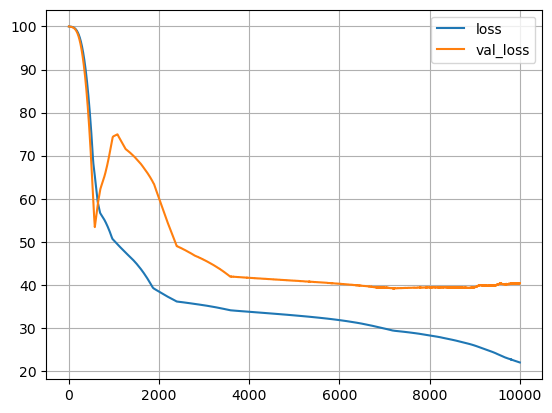

In [34]:
result_6 = pd.DataFrame({'loss': history_6.history['loss'], 'val_loss': history_6.history['val_loss']})
result_6.plot.line(grid=True)

In [35]:
result_6['val_loss'].min()

39.15081787109375

In [36]:
result_6['val_loss'].idxmin()

7221

In [37]:
model_6.evaluate({'time_dependent': X_test,
    'time_independent': well_data_test},
    y_test)

1/1 [==============================] - 0s 16ms/step - loss: 59.0783 - mape: 59.0783


[59.07832336425781, 59.07832336425781]

## Более сложная модель для 6 дней

In [38]:
time_dependent_input = keras.Input(
    shape=(n_days, 9),
    name='time_dependent'
)
time_independent_input = keras.Input(
    shape=(23),
    name='time_independent'
)
dep = layers.Bidirectional(tf.keras.layers.LSTM(8,  return_sequences=True))(time_dependent_input)
dep = layers.Bidirectional(tf.keras.layers.LSTM(4,  return_sequences=False))(dep)
dep = layers.Dense(4, activation='relu')(dep)

indep = layers.Dense(12, activation='relu')(time_independent_input)

x = layers.concatenate([dep, indep])

x = layers.Dense(32,  activation='relu')(x)
pred = layers.Dense(1)(x)

model_6_lstm = keras.Model(
    inputs = [time_dependent_input, time_independent_input],
    outputs = [pred]
)

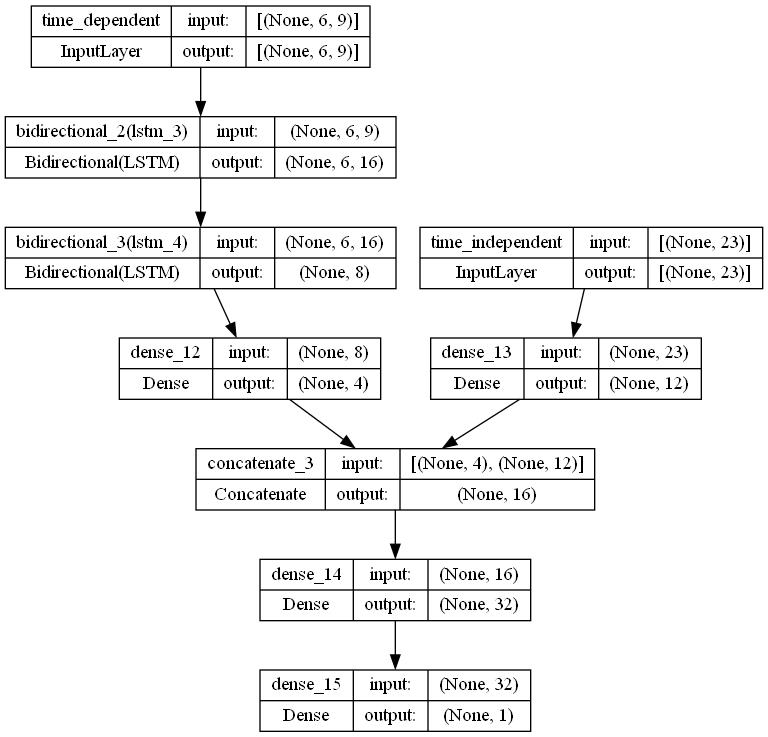

In [39]:
keras.utils.plot_model(model_6_lstm, 'model_6_lstm.jpg', show_shapes=True)

In [40]:
model_6_lstm.compile(
    loss="mape",
    optimizer="adam",
    metrics=['mape']
)

In [41]:
%%time
%%chime
history = model_6_lstm.fit(
    {'time_dependent': X_train,
    'time_independent': well_data_train},
    y_train,
    epochs=6000,
    verbose=1,
    validation_split=0.1
)

Epoch 1/6000
1/1 [==============================] - 11s 11s/step - loss: 99.9886 - mape: 99.9886 - val_loss: 99.9829 - val_mape: 99.9829
Epoch 2/6000
1/1 [==============================] - 0s 35ms/step - loss: 99.9867 - mape: 99.9867 - val_loss: 99.9804 - val_mape: 99.9804
Epoch 3/6000
1/1 [==============================] - 0s 31ms/step - loss: 99.9848 - mape: 99.9848 - val_loss: 99.9779 - val_mape: 99.9779
Epoch 4/6000
1/1 [==============================] - 0s 30ms/step - loss: 99.9829 - mape: 99.9829 - val_loss: 99.9753 - val_mape: 99.9753
Epoch 5/6000
1/1 [==============================] - 0s 29ms/step - loss: 99.9809 - mape: 99.9809 - val_loss: 99.9727 - val_mape: 99.9727
Epoch 6/6000
1/1 [==============================] - 0s 29ms/step - loss: 99.9790 - mape: 99.9790 - val_loss: 99.9701 - val_mape: 99.9701
Epoch 7/6000
1/1 [==============================] - 0s 29ms/step - loss: 99.9770 - mape: 99.9770 - val_loss: 99.9674 - val_mape: 99.9674
Epoch 8/6000
1/1 [=======================

1/1 [==============================] - 0s 28ms/step - loss: 99.2787 - mape: 99.2787 - val_loss: 99.0341 - val_mape: 99.0341
Epoch 120/6000
1/1 [==============================] - 0s 28ms/step - loss: 99.2647 - mape: 99.2647 - val_loss: 99.0154 - val_mape: 99.0154
Epoch 121/6000
1/1 [==============================] - 0s 27ms/step - loss: 99.2504 - mape: 99.2504 - val_loss: 98.9964 - val_mape: 98.9964
Epoch 122/6000
1/1 [==============================] - 0s 27ms/step - loss: 99.2359 - mape: 99.2359 - val_loss: 98.9771 - val_mape: 98.9771
Epoch 123/6000
1/1 [==============================] - 0s 29ms/step - loss: 99.2212 - mape: 99.2212 - val_loss: 98.9575 - val_mape: 98.9575
Epoch 124/6000
1/1 [==============================] - 0s 28ms/step - loss: 99.2062 - mape: 99.2062 - val_loss: 98.9375 - val_mape: 98.9375
Epoch 125/6000
1/1 [==============================] - 0s 29ms/step - loss: 99.1910 - mape: 99.1910 - val_loss: 98.9173 - val_mape: 98.9173
Epoch 126/6000
1/1 [======================

1/1 [==============================] - 0s 32ms/step - loss: 97.9943 - mape: 97.9943 - val_loss: 97.3275 - val_mape: 97.3275
Epoch 179/6000
1/1 [==============================] - 0s 27ms/step - loss: 97.9632 - mape: 97.9632 - val_loss: 97.2864 - val_mape: 97.2864
Epoch 180/6000
1/1 [==============================] - 0s 28ms/step - loss: 97.9318 - mape: 97.9318 - val_loss: 97.2447 - val_mape: 97.2447
Epoch 181/6000
1/1 [==============================] - 0s 28ms/step - loss: 97.9000 - mape: 97.9000 - val_loss: 97.2026 - val_mape: 97.2026
Epoch 182/6000
1/1 [==============================] - 0s 28ms/step - loss: 97.8679 - mape: 97.8679 - val_loss: 97.1600 - val_mape: 97.1600
Epoch 183/6000
1/1 [==============================] - 0s 29ms/step - loss: 97.8354 - mape: 97.8354 - val_loss: 97.1169 - val_mape: 97.1169
Epoch 184/6000
1/1 [==============================] - 0s 29ms/step - loss: 97.8025 - mape: 97.8025 - val_loss: 97.0733 - val_mape: 97.0733
Epoch 185/6000
1/1 [======================

1/1 [==============================] - 0s 28ms/step - loss: 95.4799 - mape: 95.4799 - val_loss: 94.0003 - val_mape: 94.0003
Epoch 238/6000
1/1 [==============================] - 0s 28ms/step - loss: 95.4240 - mape: 95.4240 - val_loss: 93.9265 - val_mape: 93.9265
Epoch 239/6000
1/1 [==============================] - 0s 28ms/step - loss: 95.3677 - mape: 95.3677 - val_loss: 93.8521 - val_mape: 93.8521
Epoch 240/6000
1/1 [==============================] - 0s 28ms/step - loss: 95.3108 - mape: 95.3108 - val_loss: 93.7769 - val_mape: 93.7769
Epoch 241/6000
1/1 [==============================] - 0s 28ms/step - loss: 95.2535 - mape: 95.2535 - val_loss: 93.7012 - val_mape: 93.7012
Epoch 242/6000
1/1 [==============================] - 0s 28ms/step - loss: 95.1957 - mape: 95.1957 - val_loss: 93.6248 - val_mape: 93.6248
Epoch 243/6000
1/1 [==============================] - 0s 28ms/step - loss: 95.1373 - mape: 95.1373 - val_loss: 93.5477 - val_mape: 93.5477
Epoch 244/6000
1/1 [======================

1/1 [==============================] - 0s 29ms/step - loss: 91.2820 - mape: 91.2820 - val_loss: 88.4600 - val_mape: 88.4600
Epoch 297/6000
1/1 [==============================] - 0s 28ms/step - loss: 91.1938 - mape: 91.1938 - val_loss: 88.3437 - val_mape: 88.3437
Epoch 298/6000
1/1 [==============================] - 0s 30ms/step - loss: 91.1050 - mape: 91.1050 - val_loss: 88.2266 - val_mape: 88.2266
Epoch 299/6000
1/1 [==============================] - 0s 29ms/step - loss: 91.0156 - mape: 91.0156 - val_loss: 88.1087 - val_mape: 88.1087
Epoch 300/6000
1/1 [==============================] - 0s 28ms/step - loss: 90.9255 - mape: 90.9255 - val_loss: 87.9900 - val_mape: 87.9900
Epoch 301/6000
1/1 [==============================] - 0s 28ms/step - loss: 90.8349 - mape: 90.8349 - val_loss: 87.8705 - val_mape: 87.8705
Epoch 302/6000
1/1 [==============================] - 0s 28ms/step - loss: 90.7436 - mape: 90.7436 - val_loss: 87.7501 - val_mape: 87.7501
Epoch 303/6000
1/1 [======================

1/1 [==============================] - 0s 29ms/step - loss: 84.9675 - mape: 84.9675 - val_loss: 80.1409 - val_mape: 80.1409
Epoch 356/6000
1/1 [==============================] - 0s 28ms/step - loss: 84.8398 - mape: 84.8398 - val_loss: 79.9728 - val_mape: 79.9728
Epoch 357/6000
1/1 [==============================] - 0s 28ms/step - loss: 84.7114 - mape: 84.7114 - val_loss: 79.8037 - val_mape: 79.8037
Epoch 358/6000
1/1 [==============================] - 0s 29ms/step - loss: 84.5823 - mape: 84.5823 - val_loss: 79.6338 - val_mape: 79.6338
Epoch 359/6000
1/1 [==============================] - 0s 28ms/step - loss: 84.4524 - mape: 84.4524 - val_loss: 79.4628 - val_mape: 79.4628
Epoch 360/6000
1/1 [==============================] - 0s 28ms/step - loss: 84.3219 - mape: 84.3219 - val_loss: 79.2909 - val_mape: 79.2909
Epoch 361/6000
1/1 [==============================] - 0s 28ms/step - loss: 84.1905 - mape: 84.1905 - val_loss: 79.1180 - val_mape: 79.1180
Epoch 362/6000
1/1 [======================

1/1 [==============================] - 0s 28ms/step - loss: 76.1287 - mape: 76.1287 - val_loss: 68.5107 - val_mape: 68.5107
Epoch 415/6000
1/1 [==============================] - 0s 29ms/step - loss: 75.9549 - mape: 75.9549 - val_loss: 68.2821 - val_mape: 68.2821
Epoch 416/6000
1/1 [==============================] - 0s 29ms/step - loss: 75.7803 - mape: 75.7803 - val_loss: 68.0524 - val_mape: 68.0524
Epoch 417/6000
1/1 [==============================] - 0s 29ms/step - loss: 75.6048 - mape: 75.6048 - val_loss: 67.8216 - val_mape: 67.8216
Epoch 418/6000
1/1 [==============================] - 0s 28ms/step - loss: 75.4285 - mape: 75.4285 - val_loss: 67.5897 - val_mape: 67.5897
Epoch 419/6000
1/1 [==============================] - 0s 29ms/step - loss: 75.2513 - mape: 75.2513 - val_loss: 67.3567 - val_mape: 67.3567
Epoch 420/6000
1/1 [==============================] - 0s 28ms/step - loss: 75.0733 - mape: 75.0733 - val_loss: 67.1226 - val_mape: 67.1226
Epoch 421/6000
1/1 [======================

1/1 [==============================] - 0s 29ms/step - loss: 67.9557 - mape: 67.9557 - val_loss: 55.3864 - val_mape: 55.3864
Epoch 474/6000
1/1 [==============================] - 0s 28ms/step - loss: 67.8630 - mape: 67.8630 - val_loss: 55.2492 - val_mape: 55.2492
Epoch 475/6000
1/1 [==============================] - 0s 29ms/step - loss: 67.7700 - mape: 67.7700 - val_loss: 55.3457 - val_mape: 55.3457
Epoch 476/6000
1/1 [==============================] - 0s 28ms/step - loss: 67.6766 - mape: 67.6766 - val_loss: 55.4426 - val_mape: 55.4426
Epoch 477/6000
1/1 [==============================] - 0s 28ms/step - loss: 67.5830 - mape: 67.5830 - val_loss: 55.5398 - val_mape: 55.5398
Epoch 478/6000
1/1 [==============================] - 0s 29ms/step - loss: 67.4891 - mape: 67.4891 - val_loss: 55.6373 - val_mape: 55.6373
Epoch 479/6000
1/1 [==============================] - 0s 28ms/step - loss: 67.3948 - mape: 67.3948 - val_loss: 55.7352 - val_mape: 55.7352
Epoch 480/6000
1/1 [======================

1/1 [==============================] - 0s 28ms/step - loss: 63.0738 - mape: 63.0738 - val_loss: 60.9232 - val_mape: 60.9232
Epoch 533/6000
1/1 [==============================] - 0s 28ms/step - loss: 63.0333 - mape: 63.0333 - val_loss: 60.9980 - val_mape: 60.9980
Epoch 534/6000
1/1 [==============================] - 0s 28ms/step - loss: 62.9929 - mape: 62.9929 - val_loss: 61.0725 - val_mape: 61.0725
Epoch 535/6000
1/1 [==============================] - 0s 29ms/step - loss: 62.9527 - mape: 62.9527 - val_loss: 61.1467 - val_mape: 61.1467
Epoch 536/6000
1/1 [==============================] - 0s 28ms/step - loss: 62.9126 - mape: 62.9126 - val_loss: 61.2208 - val_mape: 61.2208
Epoch 537/6000
1/1 [==============================] - 0s 28ms/step - loss: 62.8726 - mape: 62.8726 - val_loss: 61.2947 - val_mape: 61.2947
Epoch 538/6000
1/1 [==============================] - 0s 28ms/step - loss: 62.8327 - mape: 62.8327 - val_loss: 61.3685 - val_mape: 61.3685
Epoch 539/6000
1/1 [======================

1/1 [==============================] - 0s 29ms/step - loss: 60.8579 - mape: 60.8579 - val_loss: 65.3399 - val_mape: 65.3399
Epoch 592/6000
1/1 [==============================] - 0s 29ms/step - loss: 60.8483 - mape: 60.8483 - val_loss: 65.3884 - val_mape: 65.3884
Epoch 593/6000
1/1 [==============================] - 0s 28ms/step - loss: 60.8391 - mape: 60.8391 - val_loss: 65.4351 - val_mape: 65.4351
Epoch 594/6000
1/1 [==============================] - 0s 29ms/step - loss: 60.8302 - mape: 60.8302 - val_loss: 65.4801 - val_mape: 65.4801
Epoch 595/6000
1/1 [==============================] - 0s 28ms/step - loss: 60.8215 - mape: 60.8215 - val_loss: 65.5236 - val_mape: 65.5236
Epoch 596/6000
1/1 [==============================] - 0s 28ms/step - loss: 60.8132 - mape: 60.8132 - val_loss: 65.5658 - val_mape: 65.5658
Epoch 597/6000
1/1 [==============================] - 0s 28ms/step - loss: 60.8051 - mape: 60.8051 - val_loss: 65.6067 - val_mape: 65.6067
Epoch 598/6000
1/1 [======================

1/1 [==============================] - 0s 28ms/step - loss: 60.4561 - mape: 60.4561 - val_loss: 67.3735 - val_mape: 67.3735
Epoch 651/6000
1/1 [==============================] - 0s 28ms/step - loss: 60.4496 - mape: 60.4496 - val_loss: 67.4069 - val_mape: 67.4069
Epoch 652/6000
1/1 [==============================] - 0s 28ms/step - loss: 60.4430 - mape: 60.4430 - val_loss: 67.4404 - val_mape: 67.4404
Epoch 653/6000
1/1 [==============================] - 0s 28ms/step - loss: 60.4364 - mape: 60.4364 - val_loss: 67.4739 - val_mape: 67.4739
Epoch 654/6000
1/1 [==============================] - 0s 29ms/step - loss: 60.4298 - mape: 60.4298 - val_loss: 67.5075 - val_mape: 67.5075
Epoch 655/6000
1/1 [==============================] - 0s 28ms/step - loss: 60.4232 - mape: 60.4232 - val_loss: 67.5412 - val_mape: 67.5412
Epoch 656/6000
1/1 [==============================] - 0s 29ms/step - loss: 60.4165 - mape: 60.4165 - val_loss: 67.5749 - val_mape: 67.5749
Epoch 657/6000
1/1 [======================

1/1 [==============================] - 0s 29ms/step - loss: 60.0446 - mape: 60.0446 - val_loss: 69.4781 - val_mape: 69.4781
Epoch 710/6000
1/1 [==============================] - 0s 28ms/step - loss: 60.0371 - mape: 60.0371 - val_loss: 69.5163 - val_mape: 69.5163
Epoch 711/6000
1/1 [==============================] - 0s 27ms/step - loss: 60.0297 - mape: 60.0297 - val_loss: 69.5546 - val_mape: 69.5546
Epoch 712/6000
1/1 [==============================] - 0s 27ms/step - loss: 60.0222 - mape: 60.0222 - val_loss: 69.5929 - val_mape: 69.5929
Epoch 713/6000
1/1 [==============================] - 0s 28ms/step - loss: 60.0147 - mape: 60.0147 - val_loss: 69.6314 - val_mape: 69.6314
Epoch 714/6000
1/1 [==============================] - 0s 29ms/step - loss: 60.0072 - mape: 60.0072 - val_loss: 69.6699 - val_mape: 69.6699
Epoch 715/6000
1/1 [==============================] - 0s 29ms/step - loss: 59.9997 - mape: 59.9997 - val_loss: 69.7085 - val_mape: 69.7085
Epoch 716/6000
1/1 [======================

1/1 [==============================] - 0s 29ms/step - loss: 59.5770 - mape: 59.5770 - val_loss: 71.8877 - val_mape: 71.8877
Epoch 769/6000
1/1 [==============================] - 0s 27ms/step - loss: 59.5685 - mape: 59.5685 - val_loss: 71.9315 - val_mape: 71.9315
Epoch 770/6000
1/1 [==============================] - 0s 28ms/step - loss: 59.5600 - mape: 59.5600 - val_loss: 71.9753 - val_mape: 71.9753
Epoch 771/6000
1/1 [==============================] - 0s 29ms/step - loss: 59.5515 - mape: 59.5515 - val_loss: 72.0192 - val_mape: 72.0192
Epoch 772/6000
1/1 [==============================] - 0s 29ms/step - loss: 59.5430 - mape: 59.5430 - val_loss: 72.0633 - val_mape: 72.0633
Epoch 773/6000
1/1 [==============================] - 0s 28ms/step - loss: 59.5345 - mape: 59.5345 - val_loss: 72.1074 - val_mape: 72.1074
Epoch 774/6000
1/1 [==============================] - 0s 28ms/step - loss: 59.5259 - mape: 59.5259 - val_loss: 72.1517 - val_mape: 72.1517
Epoch 775/6000
1/1 [======================

1/1 [==============================] - 0s 29ms/step - loss: 59.0438 - mape: 59.0438 - val_loss: 74.6503 - val_mape: 74.6503
Epoch 828/6000
1/1 [==============================] - 0s 29ms/step - loss: 59.0342 - mape: 59.0342 - val_loss: 74.7004 - val_mape: 74.7004
Epoch 829/6000
1/1 [==============================] - 0s 29ms/step - loss: 59.0245 - mape: 59.0245 - val_loss: 74.7507 - val_mape: 74.7507
Epoch 830/6000
1/1 [==============================] - 0s 28ms/step - loss: 59.0148 - mape: 59.0148 - val_loss: 74.8012 - val_mape: 74.8012
Epoch 831/6000
1/1 [==============================] - 0s 28ms/step - loss: 59.0050 - mape: 59.0050 - val_loss: 74.8517 - val_mape: 74.8517
Epoch 832/6000
1/1 [==============================] - 0s 29ms/step - loss: 58.9953 - mape: 58.9953 - val_loss: 74.9023 - val_mape: 74.9023
Epoch 833/6000
1/1 [==============================] - 0s 29ms/step - loss: 58.9855 - mape: 58.9855 - val_loss: 74.9531 - val_mape: 74.9531
Epoch 834/6000
1/1 [======================

1/1 [==============================] - 0s 28ms/step - loss: 58.4341 - mape: 58.4341 - val_loss: 77.8229 - val_mape: 77.8229
Epoch 887/6000
1/1 [==============================] - 0s 28ms/step - loss: 58.4231 - mape: 58.4231 - val_loss: 77.8805 - val_mape: 77.8805
Epoch 888/6000
1/1 [==============================] - 0s 29ms/step - loss: 58.4120 - mape: 58.4120 - val_loss: 77.9384 - val_mape: 77.9384
Epoch 889/6000
1/1 [==============================] - 0s 29ms/step - loss: 58.4009 - mape: 58.4009 - val_loss: 77.9963 - val_mape: 77.9963
Epoch 890/6000
1/1 [==============================] - 0s 29ms/step - loss: 58.3897 - mape: 58.3897 - val_loss: 78.0545 - val_mape: 78.0545
Epoch 891/6000
1/1 [==============================] - 0s 29ms/step - loss: 58.3786 - mape: 58.3786 - val_loss: 78.1127 - val_mape: 78.1127
Epoch 892/6000
1/1 [==============================] - 0s 29ms/step - loss: 58.3674 - mape: 58.3674 - val_loss: 78.1711 - val_mape: 78.1711
Epoch 893/6000
1/1 [======================

1/1 [==============================] - 0s 28ms/step - loss: 58.1293 - mape: 58.1293 - val_loss: 79.2913 - val_mape: 79.2913
Epoch 946/6000
1/1 [==============================] - 0s 29ms/step - loss: 58.1274 - mape: 58.1274 - val_loss: 79.2714 - val_mape: 79.2714
Epoch 947/6000
1/1 [==============================] - 0s 28ms/step - loss: 58.1255 - mape: 58.1255 - val_loss: 79.2511 - val_mape: 79.2511
Epoch 948/6000
1/1 [==============================] - 0s 28ms/step - loss: 58.1235 - mape: 58.1235 - val_loss: 79.2307 - val_mape: 79.2307
Epoch 949/6000
1/1 [==============================] - 0s 29ms/step - loss: 58.1236 - mape: 58.1236 - val_loss: 79.2187 - val_mape: 79.2187
Epoch 950/6000
1/1 [==============================] - 0s 29ms/step - loss: 58.1251 - mape: 58.1251 - val_loss: 79.2143 - val_mape: 79.2143
Epoch 951/6000
1/1 [==============================] - 0s 29ms/step - loss: 58.1251 - mape: 58.1251 - val_loss: 79.2166 - val_mape: 79.2166
Epoch 952/6000
1/1 [======================

1/1 [==============================] - 0s 42ms/step - loss: 58.0838 - mape: 58.0838 - val_loss: 79.2295 - val_mape: 79.2295
Epoch 1005/6000
1/1 [==============================] - 0s 29ms/step - loss: 58.0830 - mape: 58.0830 - val_loss: 79.2318 - val_mape: 79.2318
Epoch 1006/6000
1/1 [==============================] - 0s 27ms/step - loss: 58.0825 - mape: 58.0825 - val_loss: 79.2316 - val_mape: 79.2316
Epoch 1007/6000
1/1 [==============================] - 0s 28ms/step - loss: 58.0818 - mape: 58.0818 - val_loss: 79.2292 - val_mape: 79.2292
Epoch 1008/6000
1/1 [==============================] - 0s 29ms/step - loss: 58.0809 - mape: 58.0809 - val_loss: 79.2247 - val_mape: 79.2247
Epoch 1009/6000
1/1 [==============================] - 0s 28ms/step - loss: 58.0801 - mape: 58.0801 - val_loss: 79.2274 - val_mape: 79.2274
Epoch 1010/6000
1/1 [==============================] - 0s 29ms/step - loss: 58.0795 - mape: 58.0795 - val_loss: 79.2274 - val_mape: 79.2274
Epoch 1011/6000
1/1 [===============

1/1 [==============================] - 0s 29ms/step - loss: 56.6634 - mape: 56.6634 - val_loss: 77.3679 - val_mape: 77.3679
Epoch 1121/6000
1/1 [==============================] - 0s 28ms/step - loss: 56.6200 - mape: 56.6200 - val_loss: 77.4312 - val_mape: 77.4312
Epoch 1122/6000
1/1 [==============================] - 0s 29ms/step - loss: 56.5919 - mape: 56.5919 - val_loss: 77.4962 - val_mape: 77.4962
Epoch 1123/6000
1/1 [==============================] - 0s 28ms/step - loss: 56.5628 - mape: 56.5628 - val_loss: 77.5621 - val_mape: 77.5621
Epoch 1124/6000
1/1 [==============================] - 0s 29ms/step - loss: 56.5222 - mape: 56.5222 - val_loss: 77.6285 - val_mape: 77.6285
Epoch 1125/6000
1/1 [==============================] - 0s 27ms/step - loss: 56.4913 - mape: 56.4913 - val_loss: 77.6942 - val_mape: 77.6942
Epoch 1126/6000
1/1 [==============================] - 0s 28ms/step - loss: 56.4658 - mape: 56.4658 - val_loss: 77.7599 - val_mape: 77.7599
Epoch 1127/6000
1/1 [===============

1/1 [==============================] - 0s 28ms/step - loss: 55.4708 - mape: 55.4708 - val_loss: 77.1035 - val_mape: 77.1035
Epoch 1237/6000
1/1 [==============================] - 0s 29ms/step - loss: 55.4596 - mape: 55.4596 - val_loss: 77.1042 - val_mape: 77.1042
Epoch 1238/6000
1/1 [==============================] - 0s 29ms/step - loss: 55.4502 - mape: 55.4502 - val_loss: 77.1018 - val_mape: 77.1018
Epoch 1239/6000
1/1 [==============================] - 0s 29ms/step - loss: 55.4408 - mape: 55.4408 - val_loss: 77.0968 - val_mape: 77.0968
Epoch 1240/6000
1/1 [==============================] - 0s 28ms/step - loss: 55.4314 - mape: 55.4314 - val_loss: 77.0894 - val_mape: 77.0894
Epoch 1241/6000
1/1 [==============================] - 0s 28ms/step - loss: 55.4221 - mape: 55.4221 - val_loss: 77.0799 - val_mape: 77.0799
Epoch 1242/6000
1/1 [==============================] - 0s 28ms/step - loss: 55.4128 - mape: 55.4128 - val_loss: 77.0684 - val_mape: 77.0684
Epoch 1243/6000
1/1 [===============

1/1 [==============================] - 0s 31ms/step - loss: 54.4181 - mape: 54.4181 - val_loss: 76.3743 - val_mape: 76.3743
Epoch 1353/6000
1/1 [==============================] - 0s 29ms/step - loss: 54.4084 - mape: 54.4084 - val_loss: 76.3643 - val_mape: 76.3643
Epoch 1354/6000
1/1 [==============================] - 0s 30ms/step - loss: 54.3986 - mape: 54.3986 - val_loss: 76.3523 - val_mape: 76.3523
Epoch 1355/6000
1/1 [==============================] - 0s 31ms/step - loss: 54.3887 - mape: 54.3887 - val_loss: 76.3386 - val_mape: 76.3386
Epoch 1356/6000
1/1 [==============================] - 0s 30ms/step - loss: 54.3787 - mape: 54.3787 - val_loss: 76.3234 - val_mape: 76.3234
Epoch 1357/6000
1/1 [==============================] - 0s 31ms/step - loss: 54.3687 - mape: 54.3687 - val_loss: 76.3067 - val_mape: 76.3067
Epoch 1358/6000
1/1 [==============================] - 0s 29ms/step - loss: 54.3585 - mape: 54.3585 - val_loss: 76.2888 - val_mape: 76.2888
Epoch 1359/6000
1/1 [===============

1/1 [==============================] - 0s 28ms/step - loss: 53.2127 - mape: 53.2127 - val_loss: 75.4586 - val_mape: 75.4586
Epoch 1469/6000
1/1 [==============================] - 0s 28ms/step - loss: 53.2015 - mape: 53.2015 - val_loss: 75.4475 - val_mape: 75.4475
Epoch 1470/6000
1/1 [==============================] - 0s 28ms/step - loss: 53.1904 - mape: 53.1904 - val_loss: 75.4482 - val_mape: 75.4482
Epoch 1471/6000
1/1 [==============================] - 0s 29ms/step - loss: 53.1793 - mape: 53.1793 - val_loss: 75.4460 - val_mape: 75.4460
Epoch 1472/6000
1/1 [==============================] - 0s 29ms/step - loss: 53.1684 - mape: 53.1684 - val_loss: 75.4400 - val_mape: 75.4400
Epoch 1473/6000
1/1 [==============================] - 0s 29ms/step - loss: 53.1572 - mape: 53.1572 - val_loss: 75.4307 - val_mape: 75.4307
Epoch 1474/6000
1/1 [==============================] - 0s 28ms/step - loss: 53.1459 - mape: 53.1459 - val_loss: 75.4194 - val_mape: 75.4194
Epoch 1475/6000
1/1 [===============

1/1 [==============================] - 0s 29ms/step - loss: 51.8163 - mape: 51.8163 - val_loss: 74.4601 - val_mape: 74.4601
Epoch 1585/6000
1/1 [==============================] - 0s 29ms/step - loss: 51.8031 - mape: 51.8031 - val_loss: 74.4426 - val_mape: 74.4426
Epoch 1586/6000
1/1 [==============================] - 0s 29ms/step - loss: 51.7898 - mape: 51.7898 - val_loss: 74.4239 - val_mape: 74.4239
Epoch 1587/6000
1/1 [==============================] - 0s 29ms/step - loss: 51.7764 - mape: 51.7764 - val_loss: 74.4042 - val_mape: 74.4042
Epoch 1588/6000
1/1 [==============================] - 0s 28ms/step - loss: 51.7630 - mape: 51.7630 - val_loss: 74.3835 - val_mape: 74.3835
Epoch 1589/6000
1/1 [==============================] - 0s 28ms/step - loss: 51.7513 - mape: 51.7513 - val_loss: 74.3766 - val_mape: 74.3766
Epoch 1590/6000
1/1 [==============================] - 0s 29ms/step - loss: 51.7376 - mape: 51.7376 - val_loss: 74.3822 - val_mape: 74.3822
Epoch 1591/6000
1/1 [===============

1/1 [==============================] - 0s 29ms/step - loss: 50.1820 - mape: 50.1820 - val_loss: 73.2368 - val_mape: 73.2368
Epoch 1701/6000
1/1 [==============================] - 0s 28ms/step - loss: 50.1667 - mape: 50.1667 - val_loss: 73.2268 - val_mape: 73.2268
Epoch 1702/6000
1/1 [==============================] - 0s 28ms/step - loss: 50.1513 - mape: 50.1513 - val_loss: 73.2149 - val_mape: 73.2149
Epoch 1703/6000
1/1 [==============================] - 0s 29ms/step - loss: 50.1358 - mape: 50.1358 - val_loss: 73.2013 - val_mape: 73.2013
Epoch 1704/6000
1/1 [==============================] - 0s 29ms/step - loss: 50.1203 - mape: 50.1203 - val_loss: 73.1862 - val_mape: 73.1862
Epoch 1705/6000
1/1 [==============================] - 0s 28ms/step - loss: 50.1048 - mape: 50.1048 - val_loss: 73.1697 - val_mape: 73.1697
Epoch 1706/6000
1/1 [==============================] - 0s 29ms/step - loss: 50.0892 - mape: 50.0892 - val_loss: 73.1520 - val_mape: 73.1520
Epoch 1707/6000
1/1 [===============

1/1 [==============================] - 0s 28ms/step - loss: 48.7789 - mape: 48.7789 - val_loss: 72.0296 - val_mape: 72.0296
Epoch 1817/6000
1/1 [==============================] - 0s 29ms/step - loss: 48.7709 - mape: 48.7709 - val_loss: 72.0103 - val_mape: 72.0103
Epoch 1818/6000
1/1 [==============================] - 0s 28ms/step - loss: 48.7592 - mape: 48.7592 - val_loss: 71.9932 - val_mape: 71.9932
Epoch 1819/6000
1/1 [==============================] - 0s 29ms/step - loss: 48.7495 - mape: 48.7495 - val_loss: 71.9782 - val_mape: 71.9782
Epoch 1820/6000
1/1 [==============================] - 0s 31ms/step - loss: 48.7397 - mape: 48.7397 - val_loss: 71.9649 - val_mape: 71.9649
Epoch 1821/6000
1/1 [==============================] - 0s 32ms/step - loss: 48.7299 - mape: 48.7299 - val_loss: 71.9533 - val_mape: 71.9533
Epoch 1822/6000
1/1 [==============================] - 0s 31ms/step - loss: 48.7200 - mape: 48.7200 - val_loss: 71.9432 - val_mape: 71.9432
Epoch 1823/6000
1/1 [===============

1/1 [==============================] - 0s 28ms/step - loss: 47.5330 - mape: 47.5330 - val_loss: 70.7769 - val_mape: 70.7769
Epoch 1933/6000
1/1 [==============================] - 0s 29ms/step - loss: 47.5215 - mape: 47.5215 - val_loss: 70.7590 - val_mape: 70.7590
Epoch 1934/6000
1/1 [==============================] - 0s 29ms/step - loss: 47.5099 - mape: 47.5099 - val_loss: 70.7432 - val_mape: 70.7432
Epoch 1935/6000
1/1 [==============================] - 0s 28ms/step - loss: 47.4982 - mape: 47.4982 - val_loss: 70.7294 - val_mape: 70.7294
Epoch 1936/6000
1/1 [==============================] - 0s 28ms/step - loss: 47.4865 - mape: 47.4865 - val_loss: 70.7174 - val_mape: 70.7174
Epoch 1937/6000
1/1 [==============================] - 0s 29ms/step - loss: 47.4747 - mape: 47.4747 - val_loss: 70.7070 - val_mape: 70.7070
Epoch 1938/6000
1/1 [==============================] - 0s 29ms/step - loss: 47.4629 - mape: 47.4629 - val_loss: 70.6980 - val_mape: 70.6980
Epoch 1939/6000
1/1 [===============

1/1 [==============================] - 0s 29ms/step - loss: 45.9824 - mape: 45.9824 - val_loss: 69.2287 - val_mape: 69.2287
Epoch 2049/6000
1/1 [==============================] - 0s 29ms/step - loss: 45.9675 - mape: 45.9675 - val_loss: 69.2152 - val_mape: 69.2152
Epoch 2050/6000
1/1 [==============================] - 0s 28ms/step - loss: 45.9525 - mape: 45.9525 - val_loss: 69.2035 - val_mape: 69.2035
Epoch 2051/6000
1/1 [==============================] - 0s 29ms/step - loss: 45.9376 - mape: 45.9376 - val_loss: 69.1935 - val_mape: 69.1935
Epoch 2052/6000
1/1 [==============================] - 0s 27ms/step - loss: 45.9225 - mape: 45.9225 - val_loss: 69.1849 - val_mape: 69.1849
Epoch 2053/6000
1/1 [==============================] - 0s 29ms/step - loss: 45.9074 - mape: 45.9074 - val_loss: 69.1776 - val_mape: 69.1776
Epoch 2054/6000
1/1 [==============================] - 0s 29ms/step - loss: 45.8936 - mape: 45.8936 - val_loss: 69.1511 - val_mape: 69.1511
Epoch 2055/6000
1/1 [===============

1/1 [==============================] - 0s 28ms/step - loss: 44.1593 - mape: 44.1593 - val_loss: 66.6476 - val_mape: 66.6476
Epoch 2165/6000
1/1 [==============================] - 0s 28ms/step - loss: 44.1445 - mape: 44.1445 - val_loss: 66.6011 - val_mape: 66.6011
Epoch 2166/6000
1/1 [==============================] - 0s 29ms/step - loss: 44.1302 - mape: 44.1302 - val_loss: 66.5461 - val_mape: 66.5461
Epoch 2167/6000
1/1 [==============================] - 0s 27ms/step - loss: 44.1153 - mape: 44.1153 - val_loss: 66.4969 - val_mape: 66.4969
Epoch 2168/6000
1/1 [==============================] - 0s 28ms/step - loss: 44.1009 - mape: 44.1009 - val_loss: 66.4531 - val_mape: 66.4531
Epoch 2169/6000
1/1 [==============================] - 0s 29ms/step - loss: 44.0861 - mape: 44.0861 - val_loss: 66.4005 - val_mape: 66.4005
Epoch 2170/6000
1/1 [==============================] - 0s 28ms/step - loss: 44.0717 - mape: 44.0717 - val_loss: 66.3535 - val_mape: 66.3535
Epoch 2171/6000
1/1 [===============

1/1 [==============================] - 0s 28ms/step - loss: 42.3908 - mape: 42.3908 - val_loss: 60.7727 - val_mape: 60.7727
Epoch 2281/6000
1/1 [==============================] - 0s 29ms/step - loss: 42.3755 - mape: 42.3755 - val_loss: 60.7174 - val_mape: 60.7174
Epoch 2282/6000
1/1 [==============================] - 0s 29ms/step - loss: 42.3596 - mape: 42.3596 - val_loss: 60.6678 - val_mape: 60.6678
Epoch 2283/6000
1/1 [==============================] - 0s 29ms/step - loss: 42.3430 - mape: 42.3430 - val_loss: 60.6234 - val_mape: 60.6234
Epoch 2284/6000
1/1 [==============================] - 0s 28ms/step - loss: 42.3260 - mape: 42.3260 - val_loss: 60.5837 - val_mape: 60.5837
Epoch 2285/6000
1/1 [==============================] - 0s 28ms/step - loss: 42.3090 - mape: 42.3090 - val_loss: 60.5356 - val_mape: 60.5356
Epoch 2286/6000
1/1 [==============================] - 0s 28ms/step - loss: 42.2934 - mape: 42.2934 - val_loss: 60.4799 - val_mape: 60.4799
Epoch 2287/6000
1/1 [===============

1/1 [==============================] - 0s 31ms/step - loss: 40.4089 - mape: 40.4089 - val_loss: 54.2017 - val_mape: 54.2017
Epoch 2397/6000
1/1 [==============================] - 0s 29ms/step - loss: 40.3908 - mape: 40.3908 - val_loss: 54.1478 - val_mape: 54.1478
Epoch 2398/6000
1/1 [==============================] - 0s 29ms/step - loss: 40.3722 - mape: 40.3722 - val_loss: 54.0993 - val_mape: 54.0993
Epoch 2399/6000
1/1 [==============================] - 0s 30ms/step - loss: 40.3551 - mape: 40.3551 - val_loss: 54.0442 - val_mape: 54.0442
Epoch 2400/6000
1/1 [==============================] - 0s 31ms/step - loss: 40.3375 - mape: 40.3375 - val_loss: 53.9830 - val_mape: 53.9830
Epoch 2401/6000
1/1 [==============================] - 0s 32ms/step - loss: 40.3193 - mape: 40.3193 - val_loss: 53.9164 - val_mape: 53.9164
Epoch 2402/6000
1/1 [==============================] - 0s 31ms/step - loss: 40.3006 - mape: 40.3006 - val_loss: 53.8451 - val_mape: 53.8451
Epoch 2403/6000
1/1 [===============

1/1 [==============================] - 0s 29ms/step - loss: 38.2218 - mape: 38.2218 - val_loss: 46.9134 - val_mape: 46.9134
Epoch 2513/6000
1/1 [==============================] - 0s 29ms/step - loss: 38.2020 - mape: 38.2020 - val_loss: 46.8428 - val_mape: 46.8428
Epoch 2514/6000
1/1 [==============================] - 0s 29ms/step - loss: 38.1863 - mape: 38.1863 - val_loss: 46.7922 - val_mape: 46.7922
Epoch 2515/6000
1/1 [==============================] - 0s 29ms/step - loss: 38.1797 - mape: 38.1797 - val_loss: 46.7594 - val_mape: 46.7594
Epoch 2516/6000
1/1 [==============================] - 0s 28ms/step - loss: 38.1691 - mape: 38.1691 - val_loss: 46.7426 - val_mape: 46.7426
Epoch 2517/6000
1/1 [==============================] - 0s 28ms/step - loss: 38.1550 - mape: 38.1550 - val_loss: 46.7403 - val_mape: 46.7403
Epoch 2518/6000
1/1 [==============================] - 0s 28ms/step - loss: 38.1377 - mape: 38.1377 - val_loss: 46.7509 - val_mape: 46.7509
Epoch 2519/6000
1/1 [===============

1/1 [==============================] - 0s 29ms/step - loss: 36.7505 - mape: 36.7505 - val_loss: 44.5362 - val_mape: 44.5362
Epoch 2629/6000
1/1 [==============================] - 0s 29ms/step - loss: 36.7351 - mape: 36.7351 - val_loss: 44.4915 - val_mape: 44.4915
Epoch 2630/6000
1/1 [==============================] - 0s 27ms/step - loss: 36.7187 - mape: 36.7187 - val_loss: 44.4405 - val_mape: 44.4405
Epoch 2631/6000
1/1 [==============================] - 0s 29ms/step - loss: 36.7074 - mape: 36.7074 - val_loss: 44.4070 - val_mape: 44.4070
Epoch 2632/6000
1/1 [==============================] - 0s 28ms/step - loss: 36.6969 - mape: 36.6969 - val_loss: 44.3892 - val_mape: 44.3892
Epoch 2633/6000
1/1 [==============================] - 0s 29ms/step - loss: 36.6827 - mape: 36.6827 - val_loss: 44.3857 - val_mape: 44.3857
Epoch 2634/6000
1/1 [==============================] - 0s 28ms/step - loss: 36.6653 - mape: 36.6653 - val_loss: 44.3950 - val_mape: 44.3950
Epoch 2635/6000
1/1 [===============

1/1 [==============================] - 0s 28ms/step - loss: 35.1008 - mape: 35.1008 - val_loss: 41.8113 - val_mape: 41.8113
Epoch 2745/6000
1/1 [==============================] - 0s 29ms/step - loss: 35.0865 - mape: 35.0865 - val_loss: 41.7975 - val_mape: 41.7975
Epoch 2746/6000
1/1 [==============================] - 0s 28ms/step - loss: 35.0713 - mape: 35.0713 - val_loss: 41.7740 - val_mape: 41.7740
Epoch 2747/6000
1/1 [==============================] - 0s 29ms/step - loss: 35.0563 - mape: 35.0563 - val_loss: 41.7418 - val_mape: 41.7418
Epoch 2748/6000
1/1 [==============================] - 0s 31ms/step - loss: 35.0401 - mape: 35.0401 - val_loss: 41.7017 - val_mape: 41.7017
Epoch 2749/6000
1/1 [==============================] - 0s 28ms/step - loss: 35.0279 - mape: 35.0279 - val_loss: 41.6781 - val_mape: 41.6781
Epoch 2750/6000
1/1 [==============================] - 0s 28ms/step - loss: 35.0123 - mape: 35.0123 - val_loss: 41.6692 - val_mape: 41.6692
Epoch 2751/6000
1/1 [===============

1/1 [==============================] - 0s 29ms/step - loss: 33.2157 - mape: 33.2157 - val_loss: 38.7203 - val_mape: 38.7203
Epoch 2861/6000
1/1 [==============================] - 0s 30ms/step - loss: 33.1986 - mape: 33.1986 - val_loss: 38.7037 - val_mape: 38.7037
Epoch 2862/6000
1/1 [==============================] - 0s 30ms/step - loss: 33.1819 - mape: 33.1819 - val_loss: 38.6772 - val_mape: 38.6772
Epoch 2863/6000
1/1 [==============================] - 0s 29ms/step - loss: 33.1648 - mape: 33.1648 - val_loss: 38.6419 - val_mape: 38.6419
Epoch 2864/6000
1/1 [==============================] - 0s 29ms/step - loss: 33.1465 - mape: 33.1465 - val_loss: 38.5987 - val_mape: 38.5987
Epoch 2865/6000
1/1 [==============================] - 0s 29ms/step - loss: 33.1306 - mape: 33.1306 - val_loss: 38.5722 - val_mape: 38.5722
Epoch 2866/6000
1/1 [==============================] - 0s 29ms/step - loss: 33.1126 - mape: 33.1126 - val_loss: 38.5608 - val_mape: 38.5608
Epoch 2867/6000
1/1 [===============

1/1 [==============================] - 0s 28ms/step - loss: 32.2491 - mape: 32.2491 - val_loss: 36.3475 - val_mape: 36.3475
Epoch 2977/6000
1/1 [==============================] - 0s 28ms/step - loss: 32.2431 - mape: 32.2431 - val_loss: 36.3295 - val_mape: 36.3295
Epoch 2978/6000
1/1 [==============================] - 0s 29ms/step - loss: 32.2364 - mape: 32.2364 - val_loss: 36.3177 - val_mape: 36.3177
Epoch 2979/6000
1/1 [==============================] - 0s 28ms/step - loss: 32.2290 - mape: 32.2290 - val_loss: 36.3115 - val_mape: 36.3115
Epoch 2980/6000
1/1 [==============================] - 0s 27ms/step - loss: 32.2211 - mape: 32.2211 - val_loss: 36.3103 - val_mape: 36.3103
Epoch 2981/6000
1/1 [==============================] - 0s 28ms/step - loss: 32.2127 - mape: 32.2127 - val_loss: 36.3136 - val_mape: 36.3136
Epoch 2982/6000
1/1 [==============================] - 0s 30ms/step - loss: 32.2039 - mape: 32.2039 - val_loss: 36.3210 - val_mape: 36.3210
Epoch 2983/6000
1/1 [===============

1/1 [==============================] - 0s 28ms/step - loss: 31.3167 - mape: 31.3167 - val_loss: 33.8047 - val_mape: 33.8047
Epoch 3093/6000
1/1 [==============================] - 0s 28ms/step - loss: 31.2830 - mape: 31.2830 - val_loss: 33.8727 - val_mape: 33.8727
Epoch 3094/6000
1/1 [==============================] - 0s 28ms/step - loss: 31.2475 - mape: 31.2475 - val_loss: 34.0105 - val_mape: 34.0105
Epoch 3095/6000
1/1 [==============================] - 0s 28ms/step - loss: 31.2182 - mape: 31.2182 - val_loss: 34.2313 - val_mape: 34.2313
Epoch 3096/6000
1/1 [==============================] - 0s 29ms/step - loss: 31.1970 - mape: 31.1970 - val_loss: 34.5327 - val_mape: 34.5327
Epoch 3097/6000
1/1 [==============================] - 0s 29ms/step - loss: 31.1866 - mape: 31.1866 - val_loss: 34.8759 - val_mape: 34.8759
Epoch 3098/6000
1/1 [==============================] - 0s 27ms/step - loss: 31.1840 - mape: 31.1840 - val_loss: 35.1937 - val_mape: 35.1937
Epoch 3099/6000
1/1 [===============

1/1 [==============================] - 0s 29ms/step - loss: 29.0371 - mape: 29.0371 - val_loss: 32.4257 - val_mape: 32.4257
Epoch 3209/6000
1/1 [==============================] - 0s 28ms/step - loss: 28.9826 - mape: 28.9826 - val_loss: 32.4232 - val_mape: 32.4232
Epoch 3210/6000
1/1 [==============================] - 0s 29ms/step - loss: 28.8571 - mape: 28.8571 - val_loss: 32.4333 - val_mape: 32.4333
Epoch 3211/6000
1/1 [==============================] - 0s 29ms/step - loss: 28.6911 - mape: 28.6911 - val_loss: 32.4307 - val_mape: 32.4307
Epoch 3212/6000
1/1 [==============================] - 0s 28ms/step - loss: 28.8403 - mape: 28.8403 - val_loss: 32.4021 - val_mape: 32.4021
Epoch 3213/6000
1/1 [==============================] - 0s 28ms/step - loss: 28.9647 - mape: 28.9647 - val_loss: 32.3500 - val_mape: 32.3500
Epoch 3214/6000
1/1 [==============================] - 0s 29ms/step - loss: 28.9130 - mape: 28.9130 - val_loss: 32.2769 - val_mape: 32.2769
Epoch 3215/6000
1/1 [===============

1/1 [==============================] - 0s 29ms/step - loss: 27.4787 - mape: 27.4787 - val_loss: 29.4627 - val_mape: 29.4627
Epoch 3325/6000
1/1 [==============================] - 0s 28ms/step - loss: 27.4412 - mape: 27.4412 - val_loss: 29.4364 - val_mape: 29.4364
Epoch 3326/6000
1/1 [==============================] - 0s 29ms/step - loss: 27.4522 - mape: 27.4522 - val_loss: 29.3973 - val_mape: 29.3973
Epoch 3327/6000
1/1 [==============================] - 0s 29ms/step - loss: 27.4302 - mape: 27.4302 - val_loss: 29.3386 - val_mape: 29.3386
Epoch 3328/6000
1/1 [==============================] - 0s 30ms/step - loss: 27.4073 - mape: 27.4073 - val_loss: 29.2942 - val_mape: 29.2942
Epoch 3329/6000
1/1 [==============================] - 0s 28ms/step - loss: 27.4373 - mape: 27.4373 - val_loss: 29.2537 - val_mape: 29.2537
Epoch 3330/6000
1/1 [==============================] - 0s 28ms/step - loss: 27.4148 - mape: 27.4148 - val_loss: 29.2170 - val_mape: 29.2170
Epoch 3331/6000
1/1 [===============

1/1 [==============================] - 0s 28ms/step - loss: 26.6539 - mape: 26.6539 - val_loss: 25.8919 - val_mape: 25.8919
Epoch 3441/6000
1/1 [==============================] - 0s 29ms/step - loss: 26.5890 - mape: 26.5890 - val_loss: 25.8586 - val_mape: 25.8586
Epoch 3442/6000
1/1 [==============================] - 0s 28ms/step - loss: 26.5980 - mape: 26.5980 - val_loss: 25.8311 - val_mape: 25.8311
Epoch 3443/6000
1/1 [==============================] - 0s 28ms/step - loss: 26.5925 - mape: 26.5925 - val_loss: 25.7991 - val_mape: 25.7991
Epoch 3444/6000
1/1 [==============================] - 0s 28ms/step - loss: 26.5654 - mape: 26.5654 - val_loss: 25.7657 - val_mape: 25.7657
Epoch 3445/6000
1/1 [==============================] - 0s 28ms/step - loss: 26.5680 - mape: 26.5680 - val_loss: 25.7357 - val_mape: 25.7357
Epoch 3446/6000
1/1 [==============================] - 0s 29ms/step - loss: 26.5768 - mape: 26.5768 - val_loss: 25.7113 - val_mape: 25.7113
Epoch 3447/6000
1/1 [===============

1/1 [==============================] - 0s 29ms/step - loss: 26.2535 - mape: 26.2535 - val_loss: 22.6910 - val_mape: 22.6910
Epoch 3557/6000
1/1 [==============================] - 0s 29ms/step - loss: 26.2154 - mape: 26.2154 - val_loss: 22.6700 - val_mape: 22.6700
Epoch 3558/6000
1/1 [==============================] - 0s 28ms/step - loss: 26.2606 - mape: 26.2606 - val_loss: 22.6424 - val_mape: 22.6424
Epoch 3559/6000
1/1 [==============================] - 0s 27ms/step - loss: 26.2618 - mape: 26.2618 - val_loss: 22.6088 - val_mape: 22.6088
Epoch 3560/6000
1/1 [==============================] - 0s 28ms/step - loss: 26.2052 - mape: 26.2052 - val_loss: 22.5702 - val_mape: 22.5702
Epoch 3561/6000
1/1 [==============================] - 0s 29ms/step - loss: 26.2748 - mape: 26.2748 - val_loss: 22.5394 - val_mape: 22.5394
Epoch 3562/6000
1/1 [==============================] - 0s 27ms/step - loss: 26.3044 - mape: 26.3044 - val_loss: 22.5154 - val_mape: 22.5154
Epoch 3563/6000
1/1 [===============

1/1 [==============================] - 0s 29ms/step - loss: 25.8605 - mape: 25.8605 - val_loss: 19.2020 - val_mape: 19.2020
Epoch 3673/6000
1/1 [==============================] - 0s 29ms/step - loss: 25.8399 - mape: 25.8399 - val_loss: 19.1739 - val_mape: 19.1739
Epoch 3674/6000
1/1 [==============================] - 0s 28ms/step - loss: 25.8532 - mape: 25.8532 - val_loss: 19.1350 - val_mape: 19.1350
Epoch 3675/6000
1/1 [==============================] - 0s 28ms/step - loss: 25.8396 - mape: 25.8396 - val_loss: 19.0870 - val_mape: 19.0870
Epoch 3676/6000
1/1 [==============================] - 0s 28ms/step - loss: 25.8356 - mape: 25.8356 - val_loss: 19.0481 - val_mape: 19.0481
Epoch 3677/6000
1/1 [==============================] - 0s 29ms/step - loss: 25.8355 - mape: 25.8355 - val_loss: 19.0173 - val_mape: 19.0173
Epoch 3678/6000
1/1 [==============================] - 0s 28ms/step - loss: 25.8176 - mape: 25.8176 - val_loss: 18.9811 - val_mape: 18.9811
Epoch 3679/6000
1/1 [===============

1/1 [==============================] - 0s 28ms/step - loss: 25.6239 - mape: 25.6239 - val_loss: 16.7882 - val_mape: 16.7882
Epoch 3789/6000
1/1 [==============================] - 0s 29ms/step - loss: 25.6059 - mape: 25.6059 - val_loss: 16.7780 - val_mape: 16.7780
Epoch 3790/6000
1/1 [==============================] - 0s 28ms/step - loss: 25.6279 - mape: 25.6279 - val_loss: 16.7803 - val_mape: 16.7803
Epoch 3791/6000
1/1 [==============================] - 0s 29ms/step - loss: 25.6094 - mape: 25.6094 - val_loss: 16.7939 - val_mape: 16.7939
Epoch 3792/6000
1/1 [==============================] - 0s 29ms/step - loss: 25.6151 - mape: 25.6151 - val_loss: 16.8295 - val_mape: 16.8295
Epoch 3793/6000
1/1 [==============================] - 0s 28ms/step - loss: 25.6165 - mape: 25.6165 - val_loss: 16.8608 - val_mape: 16.8608
Epoch 3794/6000
1/1 [==============================] - 0s 29ms/step - loss: 25.5863 - mape: 25.5863 - val_loss: 16.8814 - val_mape: 16.8814
Epoch 3795/6000
1/1 [===============

1/1 [==============================] - 0s 31ms/step - loss: 25.5573 - mape: 25.5573 - val_loss: 16.7852 - val_mape: 16.7852
Epoch 3905/6000
1/1 [==============================] - 0s 30ms/step - loss: 25.6137 - mape: 25.6137 - val_loss: 16.7943 - val_mape: 16.7943
Epoch 3906/6000
1/1 [==============================] - 0s 30ms/step - loss: 25.6246 - mape: 25.6246 - val_loss: 16.8280 - val_mape: 16.8280
Epoch 3907/6000
1/1 [==============================] - 0s 30ms/step - loss: 25.5836 - mape: 25.5836 - val_loss: 16.8574 - val_mape: 16.8574
Epoch 3908/6000
1/1 [==============================] - 0s 29ms/step - loss: 25.5671 - mape: 25.5671 - val_loss: 16.8719 - val_mape: 16.8719
Epoch 3909/6000
1/1 [==============================] - 0s 28ms/step - loss: 25.5873 - mape: 25.5873 - val_loss: 16.8729 - val_mape: 16.8729
Epoch 3910/6000
1/1 [==============================] - 0s 30ms/step - loss: 25.5674 - mape: 25.5674 - val_loss: 16.8618 - val_mape: 16.8618
Epoch 3911/6000
1/1 [===============

1/1 [==============================] - 0s 30ms/step - loss: 25.5168 - mape: 25.5168 - val_loss: 16.8404 - val_mape: 16.8404
Epoch 4021/6000
1/1 [==============================] - 0s 30ms/step - loss: 25.5315 - mape: 25.5315 - val_loss: 16.8346 - val_mape: 16.8346
Epoch 4022/6000
1/1 [==============================] - 0s 30ms/step - loss: 25.5172 - mape: 25.5172 - val_loss: 16.8283 - val_mape: 16.8283
Epoch 4023/6000
1/1 [==============================] - 0s 29ms/step - loss: 25.5426 - mape: 25.5426 - val_loss: 16.8113 - val_mape: 16.8113
Epoch 4024/6000
1/1 [==============================] - 0s 28ms/step - loss: 25.5459 - mape: 25.5459 - val_loss: 16.7845 - val_mape: 16.7845
Epoch 4025/6000
1/1 [==============================] - 0s 28ms/step - loss: 25.5271 - mape: 25.5271 - val_loss: 16.7702 - val_mape: 16.7702
Epoch 4026/6000
1/1 [==============================] - 0s 29ms/step - loss: 25.5650 - mape: 25.5650 - val_loss: 16.7815 - val_mape: 16.7815
Epoch 4027/6000
1/1 [===============

1/1 [==============================] - 0s 29ms/step - loss: 25.4899 - mape: 25.4899 - val_loss: 16.8621 - val_mape: 16.8621
Epoch 4137/6000
1/1 [==============================] - 0s 29ms/step - loss: 25.4766 - mape: 25.4766 - val_loss: 16.8595 - val_mape: 16.8595
Epoch 4138/6000
1/1 [==============================] - 0s 28ms/step - loss: 25.5128 - mape: 25.5128 - val_loss: 16.8462 - val_mape: 16.8462
Epoch 4139/6000
1/1 [==============================] - 0s 29ms/step - loss: 25.5164 - mape: 25.5164 - val_loss: 16.8231 - val_mape: 16.8231
Epoch 4140/6000
1/1 [==============================] - 0s 28ms/step - loss: 25.4868 - mape: 25.4868 - val_loss: 16.7914 - val_mape: 16.7914
Epoch 4141/6000
1/1 [==============================] - 0s 28ms/step - loss: 25.5171 - mape: 25.5171 - val_loss: 16.7860 - val_mape: 16.7860
Epoch 4142/6000
1/1 [==============================] - 0s 28ms/step - loss: 25.5336 - mape: 25.5336 - val_loss: 16.8042 - val_mape: 16.8042
Epoch 4143/6000
1/1 [===============

1/1 [==============================] - 0s 29ms/step - loss: 25.4485 - mape: 25.4485 - val_loss: 16.7690 - val_mape: 16.7690
Epoch 4253/6000
1/1 [==============================] - 0s 30ms/step - loss: 25.4467 - mape: 25.4467 - val_loss: 16.7596 - val_mape: 16.7596
Epoch 4254/6000
1/1 [==============================] - 0s 28ms/step - loss: 25.4653 - mape: 25.4653 - val_loss: 16.7700 - val_mape: 16.7700
Epoch 4255/6000
1/1 [==============================] - 0s 28ms/step - loss: 25.4607 - mape: 25.4607 - val_loss: 16.7979 - val_mape: 16.7979
Epoch 4256/6000
1/1 [==============================] - 0s 29ms/step - loss: 25.4390 - mape: 25.4390 - val_loss: 16.8127 - val_mape: 16.8127
Epoch 4257/6000
1/1 [==============================] - 0s 28ms/step - loss: 25.4400 - mape: 25.4400 - val_loss: 16.8156 - val_mape: 16.8156
Epoch 4258/6000
1/1 [==============================] - 0s 27ms/step - loss: 25.4528 - mape: 25.4528 - val_loss: 16.8172 - val_mape: 16.8172
Epoch 4259/6000
1/1 [===============

1/1 [==============================] - 0s 29ms/step - loss: 25.4238 - mape: 25.4238 - val_loss: 16.8439 - val_mape: 16.8439
Epoch 4369/6000
1/1 [==============================] - 0s 29ms/step - loss: 25.4088 - mape: 25.4088 - val_loss: 16.8403 - val_mape: 16.8403
Epoch 4370/6000
1/1 [==============================] - 0s 29ms/step - loss: 25.4056 - mape: 25.4056 - val_loss: 16.8360 - val_mape: 16.8360
Epoch 4371/6000
1/1 [==============================] - 0s 28ms/step - loss: 25.4015 - mape: 25.4015 - val_loss: 16.8275 - val_mape: 16.8275
Epoch 4372/6000
1/1 [==============================] - 0s 30ms/step - loss: 25.3971 - mape: 25.3971 - val_loss: 16.8156 - val_mape: 16.8156
Epoch 4373/6000
1/1 [==============================] - 0s 28ms/step - loss: 25.3958 - mape: 25.3958 - val_loss: 16.8044 - val_mape: 16.8044
Epoch 4374/6000
1/1 [==============================] - 0s 29ms/step - loss: 25.4113 - mape: 25.4113 - val_loss: 16.7847 - val_mape: 16.7847
Epoch 4375/6000
1/1 [===============

1/1 [==============================] - 0s 29ms/step - loss: 25.3932 - mape: 25.3932 - val_loss: 16.7858 - val_mape: 16.7858
Epoch 4485/6000
1/1 [==============================] - 0s 28ms/step - loss: 25.3615 - mape: 25.3615 - val_loss: 16.8072 - val_mape: 16.8072
Epoch 4486/6000
1/1 [==============================] - 0s 29ms/step - loss: 25.3883 - mape: 25.3883 - val_loss: 16.8166 - val_mape: 16.8166
Epoch 4487/6000
1/1 [==============================] - 0s 28ms/step - loss: 25.4047 - mape: 25.4047 - val_loss: 16.8151 - val_mape: 16.8151
Epoch 4488/6000
1/1 [==============================] - 0s 29ms/step - loss: 25.3911 - mape: 25.3911 - val_loss: 16.8039 - val_mape: 16.8039
Epoch 4489/6000
1/1 [==============================] - 0s 29ms/step - loss: 25.3566 - mape: 25.3566 - val_loss: 16.7875 - val_mape: 16.7875
Epoch 4490/6000
1/1 [==============================] - 0s 28ms/step - loss: 25.3792 - mape: 25.3792 - val_loss: 16.7905 - val_mape: 16.7905
Epoch 4491/6000
1/1 [===============

1/1 [==============================] - 0s 27ms/step - loss: 25.3249 - mape: 25.3249 - val_loss: 16.7854 - val_mape: 16.7854
Epoch 4601/6000
1/1 [==============================] - 0s 28ms/step - loss: 25.3404 - mape: 25.3404 - val_loss: 16.7865 - val_mape: 16.7865
Epoch 4602/6000
1/1 [==============================] - 0s 29ms/step - loss: 25.3508 - mape: 25.3508 - val_loss: 16.8078 - val_mape: 16.8078
Epoch 4603/6000
1/1 [==============================] - 0s 28ms/step - loss: 25.3304 - mape: 25.3304 - val_loss: 16.8260 - val_mape: 16.8260
Epoch 4604/6000
1/1 [==============================] - 0s 29ms/step - loss: 25.3320 - mape: 25.3320 - val_loss: 16.8327 - val_mape: 16.8327
Epoch 4605/6000
1/1 [==============================] - 0s 28ms/step - loss: 25.3449 - mape: 25.3449 - val_loss: 16.8292 - val_mape: 16.8292
Epoch 4606/6000
1/1 [==============================] - 0s 27ms/step - loss: 25.3292 - mape: 25.3292 - val_loss: 16.8163 - val_mape: 16.8163
Epoch 4607/6000
1/1 [===============

1/1 [==============================] - 0s 28ms/step - loss: 25.2692 - mape: 25.2692 - val_loss: 16.8075 - val_mape: 16.8075
Epoch 4717/6000
1/1 [==============================] - 0s 27ms/step - loss: 25.2754 - mape: 25.2754 - val_loss: 16.8028 - val_mape: 16.8028
Epoch 4718/6000
1/1 [==============================] - 0s 28ms/step - loss: 25.2744 - mape: 25.2744 - val_loss: 16.7891 - val_mape: 16.7891
Epoch 4719/6000
1/1 [==============================] - 0s 28ms/step - loss: 25.2708 - mape: 25.2708 - val_loss: 16.7726 - val_mape: 16.7726
Epoch 4720/6000
1/1 [==============================] - 0s 28ms/step - loss: 25.2781 - mape: 25.2781 - val_loss: 16.7754 - val_mape: 16.7754
Epoch 4721/6000
1/1 [==============================] - 0s 28ms/step - loss: 25.2699 - mape: 25.2699 - val_loss: 16.7922 - val_mape: 16.7922
Epoch 4722/6000
1/1 [==============================] - 0s 28ms/step - loss: 25.2743 - mape: 25.2743 - val_loss: 16.7980 - val_mape: 16.7980
Epoch 4723/6000
1/1 [===============

1/1 [==============================] - 0s 28ms/step - loss: 25.2483 - mape: 25.2483 - val_loss: 16.7500 - val_mape: 16.7500
Epoch 4833/6000
1/1 [==============================] - 0s 29ms/step - loss: 25.2386 - mape: 25.2386 - val_loss: 16.7385 - val_mape: 16.7385
Epoch 4834/6000
1/1 [==============================] - 0s 29ms/step - loss: 25.2554 - mape: 25.2554 - val_loss: 16.7484 - val_mape: 16.7484
Epoch 4835/6000
1/1 [==============================] - 0s 29ms/step - loss: 25.2535 - mape: 25.2535 - val_loss: 16.7776 - val_mape: 16.7776
Epoch 4836/6000
1/1 [==============================] - 0s 29ms/step - loss: 25.2275 - mape: 25.2275 - val_loss: 16.7983 - val_mape: 16.7983
Epoch 4837/6000
1/1 [==============================] - 0s 29ms/step - loss: 25.2406 - mape: 25.2406 - val_loss: 16.8077 - val_mape: 16.8077
Epoch 4838/6000
1/1 [==============================] - 0s 28ms/step - loss: 25.2392 - mape: 25.2392 - val_loss: 16.8066 - val_mape: 16.8066
Epoch 4839/6000
1/1 [===============

1/1 [==============================] - 0s 30ms/step - loss: 25.1973 - mape: 25.1973 - val_loss: 16.7628 - val_mape: 16.7628
Epoch 4949/6000
1/1 [==============================] - 0s 32ms/step - loss: 25.2094 - mape: 25.2094 - val_loss: 16.7505 - val_mape: 16.7505
Epoch 4950/6000
1/1 [==============================] - 0s 31ms/step - loss: 25.2016 - mape: 25.2016 - val_loss: 16.7564 - val_mape: 16.7564
Epoch 4951/6000
1/1 [==============================] - 0s 31ms/step - loss: 25.1752 - mape: 25.1752 - val_loss: 16.7736 - val_mape: 16.7736
Epoch 4952/6000
1/1 [==============================] - 0s 30ms/step - loss: 25.2110 - mape: 25.2110 - val_loss: 16.7798 - val_mape: 16.7798
Epoch 4953/6000
1/1 [==============================] - 0s 28ms/step - loss: 25.2216 - mape: 25.2216 - val_loss: 16.7761 - val_mape: 16.7761
Epoch 4954/6000
1/1 [==============================] - 0s 28ms/step - loss: 25.2064 - mape: 25.2064 - val_loss: 16.7634 - val_mape: 16.7634
Epoch 4955/6000
1/1 [===============

1/1 [==============================] - 0s 29ms/step - loss: 25.1528 - mape: 25.1528 - val_loss: 16.7697 - val_mape: 16.7697
Epoch 5065/6000
1/1 [==============================] - 0s 29ms/step - loss: 25.1446 - mape: 25.1446 - val_loss: 16.7866 - val_mape: 16.7866
Epoch 5066/6000
1/1 [==============================] - 0s 28ms/step - loss: 25.1350 - mape: 25.1350 - val_loss: 16.7975 - val_mape: 16.7975
Epoch 5067/6000
1/1 [==============================] - 0s 28ms/step - loss: 25.1435 - mape: 25.1435 - val_loss: 16.7980 - val_mape: 16.7980
Epoch 5068/6000
1/1 [==============================] - 0s 28ms/step - loss: 25.1385 - mape: 25.1385 - val_loss: 16.7893 - val_mape: 16.7893
Epoch 5069/6000
1/1 [==============================] - 0s 29ms/step - loss: 25.1309 - mape: 25.1309 - val_loss: 16.7804 - val_mape: 16.7804
Epoch 5070/6000
1/1 [==============================] - 0s 29ms/step - loss: 25.1323 - mape: 25.1323 - val_loss: 16.7713 - val_mape: 16.7713
Epoch 5071/6000
1/1 [===============

1/1 [==============================] - 0s 28ms/step - loss: 25.0768 - mape: 25.0768 - val_loss: 16.7043 - val_mape: 16.7043
Epoch 5181/6000
1/1 [==============================] - 0s 28ms/step - loss: 25.0797 - mape: 25.0797 - val_loss: 16.7026 - val_mape: 16.7026
Epoch 5182/6000
1/1 [==============================] - 0s 28ms/step - loss: 25.0582 - mape: 25.0582 - val_loss: 16.7179 - val_mape: 16.7179
Epoch 5183/6000
1/1 [==============================] - 0s 28ms/step - loss: 25.0934 - mape: 25.0934 - val_loss: 16.7222 - val_mape: 16.7222
Epoch 5184/6000
1/1 [==============================] - 0s 29ms/step - loss: 25.1091 - mape: 25.1091 - val_loss: 16.7165 - val_mape: 16.7165
Epoch 5185/6000
1/1 [==============================] - 0s 28ms/step - loss: 25.0993 - mape: 25.0993 - val_loss: 16.7019 - val_mape: 16.7019
Epoch 5186/6000
1/1 [==============================] - 0s 29ms/step - loss: 25.0663 - mape: 25.0663 - val_loss: 16.6793 - val_mape: 16.6793
Epoch 5187/6000
1/1 [===============

1/1 [==============================] - 0s 28ms/step - loss: 25.0040 - mape: 25.0040 - val_loss: 16.7709 - val_mape: 16.7709
Epoch 5297/6000
1/1 [==============================] - 0s 29ms/step - loss: 25.0038 - mape: 25.0038 - val_loss: 16.7769 - val_mape: 16.7769
Epoch 5298/6000
1/1 [==============================] - 0s 29ms/step - loss: 25.0184 - mape: 25.0184 - val_loss: 16.7732 - val_mape: 16.7732
Epoch 5299/6000
1/1 [==============================] - 0s 29ms/step - loss: 25.0081 - mape: 25.0081 - val_loss: 16.7609 - val_mape: 16.7609
Epoch 5300/6000
1/1 [==============================] - 0s 28ms/step - loss: 24.9899 - mape: 24.9899 - val_loss: 16.7488 - val_mape: 16.7488
Epoch 5301/6000
1/1 [==============================] - 0s 29ms/step - loss: 24.9945 - mape: 24.9945 - val_loss: 16.7368 - val_mape: 16.7368
Epoch 5302/6000
1/1 [==============================] - 0s 29ms/step - loss: 24.9835 - mape: 24.9835 - val_loss: 16.7218 - val_mape: 16.7218
Epoch 5303/6000
1/1 [===============

1/1 [==============================] - 0s 30ms/step - loss: 24.9176 - mape: 24.9176 - val_loss: 16.7194 - val_mape: 16.7194
Epoch 5413/6000
1/1 [==============================] - 0s 31ms/step - loss: 24.9122 - mape: 24.9122 - val_loss: 16.7165 - val_mape: 16.7165
Epoch 5414/6000
1/1 [==============================] - 0s 31ms/step - loss: 24.9229 - mape: 24.9229 - val_loss: 16.7128 - val_mape: 16.7128
Epoch 5415/6000
1/1 [==============================] - 0s 30ms/step - loss: 24.9139 - mape: 24.9139 - val_loss: 16.7084 - val_mape: 16.7084
Epoch 5416/6000
1/1 [==============================] - 0s 30ms/step - loss: 24.9306 - mape: 24.9306 - val_loss: 16.6956 - val_mape: 16.6956
Epoch 5417/6000
1/1 [==============================] - 0s 29ms/step - loss: 24.9312 - mape: 24.9312 - val_loss: 16.6751 - val_mape: 16.6751
Epoch 5418/6000
1/1 [==============================] - 0s 30ms/step - loss: 24.9136 - mape: 24.9136 - val_loss: 16.6649 - val_mape: 16.6649
Epoch 5419/6000
1/1 [===============

1/1 [==============================] - 0s 32ms/step - loss: 24.8411 - mape: 24.8411 - val_loss: 16.7583 - val_mape: 16.7583
Epoch 5529/6000
1/1 [==============================] - 0s 31ms/step - loss: 24.8405 - mape: 24.8405 - val_loss: 16.7575 - val_mape: 16.7575
Epoch 5530/6000
1/1 [==============================] - 0s 29ms/step - loss: 24.8452 - mape: 24.8452 - val_loss: 16.7477 - val_mape: 16.7477
Epoch 5531/6000
1/1 [==============================] - 0s 28ms/step - loss: 24.8352 - mape: 24.8352 - val_loss: 16.7331 - val_mape: 16.7331
Epoch 5532/6000
1/1 [==============================] - 0s 27ms/step - loss: 24.8362 - mape: 24.8362 - val_loss: 16.7188 - val_mape: 16.7188
Epoch 5533/6000
1/1 [==============================] - 0s 28ms/step - loss: 24.8401 - mape: 24.8401 - val_loss: 16.7143 - val_mape: 16.7143
Epoch 5534/6000
1/1 [==============================] - 0s 29ms/step - loss: 24.8365 - mape: 24.8365 - val_loss: 16.7184 - val_mape: 16.7184
Epoch 5535/6000
1/1 [===============

1/1 [==============================] - 0s 27ms/step - loss: 24.7887 - mape: 24.7887 - val_loss: 16.7268 - val_mape: 16.7268
Epoch 5645/6000
1/1 [==============================] - 0s 29ms/step - loss: 24.7579 - mape: 24.7579 - val_loss: 16.7205 - val_mape: 16.7205
Epoch 5646/6000
1/1 [==============================] - 0s 28ms/step - loss: 24.7986 - mape: 24.7986 - val_loss: 16.7057 - val_mape: 16.7057
Epoch 5647/6000
1/1 [==============================] - 0s 29ms/step - loss: 24.8157 - mape: 24.8157 - val_loss: 16.6831 - val_mape: 16.6831
Epoch 5648/6000
1/1 [==============================] - 0s 28ms/step - loss: 24.8136 - mape: 24.8136 - val_loss: 16.6711 - val_mape: 16.6711
Epoch 5649/6000
1/1 [==============================] - 0s 28ms/step - loss: 24.7978 - mape: 24.7978 - val_loss: 16.6687 - val_mape: 16.6687
Epoch 5650/6000
1/1 [==============================] - 0s 28ms/step - loss: 24.7634 - mape: 24.7634 - val_loss: 16.6777 - val_mape: 16.6777
Epoch 5651/6000
1/1 [===============

1/1 [==============================] - 0s 29ms/step - loss: 24.6738 - mape: 24.6738 - val_loss: 16.6879 - val_mape: 16.6879
Epoch 5761/6000
1/1 [==============================] - 0s 29ms/step - loss: 24.6868 - mape: 24.6868 - val_loss: 16.6802 - val_mape: 16.6802
Epoch 5762/6000
1/1 [==============================] - 0s 29ms/step - loss: 24.6835 - mape: 24.6835 - val_loss: 16.6898 - val_mape: 16.6898
Epoch 5763/6000
1/1 [==============================] - 0s 29ms/step - loss: 24.6799 - mape: 24.6799 - val_loss: 16.6925 - val_mape: 16.6925
Epoch 5764/6000
1/1 [==============================] - 0s 29ms/step - loss: 24.7014 - mape: 24.7014 - val_loss: 16.6856 - val_mape: 16.6856
Epoch 5765/6000
1/1 [==============================] - 0s 28ms/step - loss: 24.7012 - mape: 24.7012 - val_loss: 16.6702 - val_mape: 16.6702
Epoch 5766/6000
1/1 [==============================] - 0s 28ms/step - loss: 24.6813 - mape: 24.6813 - val_loss: 16.6647 - val_mape: 16.6647
Epoch 5767/6000
1/1 [===============

1/1 [==============================] - 0s 28ms/step - loss: 24.6656 - mape: 24.6656 - val_loss: 16.7233 - val_mape: 16.7233
Epoch 5877/6000
1/1 [==============================] - 0s 28ms/step - loss: 24.6537 - mape: 24.6537 - val_loss: 16.7094 - val_mape: 16.7094
Epoch 5878/6000
1/1 [==============================] - 0s 28ms/step - loss: 24.6232 - mape: 24.6232 - val_loss: 16.6873 - val_mape: 16.6873
Epoch 5879/6000
1/1 [==============================] - 0s 28ms/step - loss: 24.5873 - mape: 24.5873 - val_loss: 16.6628 - val_mape: 16.6628
Epoch 5880/6000
1/1 [==============================] - 0s 28ms/step - loss: 24.6311 - mape: 24.6311 - val_loss: 16.6607 - val_mape: 16.6607
Epoch 5881/6000
1/1 [==============================] - 0s 29ms/step - loss: 24.6481 - mape: 24.6481 - val_loss: 16.6784 - val_mape: 16.6784
Epoch 5882/6000
1/1 [==============================] - 0s 29ms/step - loss: 24.6293 - mape: 24.6293 - val_loss: 16.7112 - val_mape: 16.7112
Epoch 5883/6000
1/1 [===============

1/1 [==============================] - 0s 31ms/step - loss: 24.5028 - mape: 24.5028 - val_loss: 16.5916 - val_mape: 16.5916
Epoch 5993/6000
1/1 [==============================] - 0s 29ms/step - loss: 24.5049 - mape: 24.5049 - val_loss: 16.5917 - val_mape: 16.5917
Epoch 5994/6000
1/1 [==============================] - 0s 29ms/step - loss: 24.5118 - mape: 24.5118 - val_loss: 16.6092 - val_mape: 16.6092
Epoch 5995/6000
1/1 [==============================] - 0s 28ms/step - loss: 24.4912 - mape: 24.4912 - val_loss: 16.6240 - val_mape: 16.6240
Epoch 5996/6000
1/1 [==============================] - 0s 28ms/step - loss: 24.5056 - mape: 24.5056 - val_loss: 16.6275 - val_mape: 16.6275
Epoch 5997/6000
1/1 [==============================] - 0s 29ms/step - loss: 24.5129 - mape: 24.5129 - val_loss: 16.6208 - val_mape: 16.6208
Epoch 5998/6000
1/1 [==============================] - 0s 28ms/step - loss: 24.4996 - mape: 24.4996 - val_loss: 16.6050 - val_mape: 16.6050
Epoch 5999/6000
1/1 [===============

<AxesSubplot:>

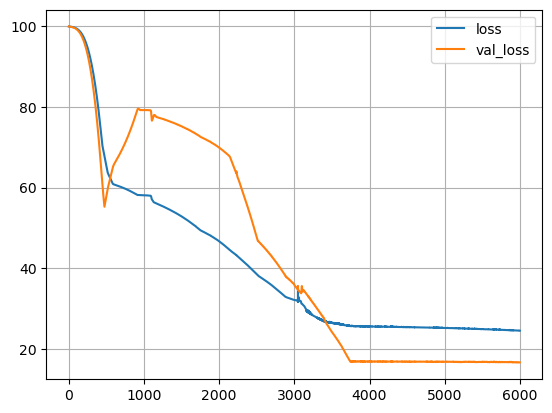

In [45]:
result_6_lstm = pd.DataFrame({'loss': history.history['loss'], 'val_loss': history.history['val_loss']})
result_6_lstm.plot.line(grid=True)

In [46]:
result_6_lstm['val_loss'].min()

16.591581344604492

In [47]:
result_6_lstm['val_loss'].idxmin()

5991

In [48]:
model_6_lstm.evaluate({'time_dependent': X_test,
    'time_independent': well_data_test},
    y_test)

1/1 [==============================] - 0s 19ms/step - loss: 80.5456 - mape: 80.5456


[80.5455551147461, 80.5455551147461]

# Предварительный вывод
Модель склонна к переобучению. Результаты нестабильны: повторные запуски дают другой результат.